Reddit is a social media news sharing website and forum where each subreddit is devoted to a certain topic, which might vary from technology to history to literature to debates and entertainment.

# Installing Pre-requisites

This step involves installation of the pre-requisite libraries of PRAW and TextBlob. 
<br> 1] PRAW - This stands for 'Python Reddit API Wraper'. It is a python library to interact with the Reddit API to fetch relevant information.
<br> 2] TextBlob - It is a python library which provides an API for natural language processing tasks like sentiment analysis.

In [ ]:
!pip install praw
!pip install textblob

Importing of the necessary libaries

In [1]:
import praw
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
import re
import pandas as pd

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Establishing connection with Reddit using the secure credentials

The object 'reddit_api' establishes a connection with the Reddit API. Using the function praw.reddit we will be fetching the post and comments and related information for the NLP tasks.
There are 2 distinct states to a reddit instance:
<br>a] Read-only
<br>b] Authorized
<br> For this SMA pipeline we have created a read-only Reddit instance by passing three keyword agruments - client_id, client_secret and user_agent

In [116]:
reddit_api = praw.Reddit(client_id='***************',
                         client_secret='****************',
                         user_agent='my_user_agent')

# Q1: Sentiment Analysis

## Fetching comments with structure and performing analysis at the same time

In this step, we use the submission class to look at submissions in a subreddit similar to if we were browsing. This dynamically provides attributes that reddit returns via the API. The url argument provides the link or the permalink the submission links to. Either id or url can be provided for this but not both.
<br> We are using the post titled 'Iceland just announced that every Icelander over the age of 18 automatically become organ donors with ability to opt out. How do you feel about this?' within the subreddit of 'AskReddit'.

In [117]:
## Optional step: Since the comments have been extracted and saved to disk, we can skip running this cell

# create object for VADER sentiment function interaction
sia = SentimentIntensityAnalyzer()

url = "https://www.reddit.com/r/AskReddit/comments/ac9038/iceland_just_announced_that_every_icelander_over/"
submission = reddit_api.submission(url=url)


pos_comms = []
neg_comms = []
neutral_comms= []

pos_ups = []
neg_ups = []
neutral_ups = []

main_ups = {}
# Sentiment analysis using TextBlob
def text_blob_sentiment(review, sub_entries_textblob):
    analysis = TextBlob(review)
    if analysis.sentiment.polarity >= 0.0001:
        if analysis.sentiment.polarity > 0:
            sub_entries_textblob['positive'] = sub_entries_textblob['positive'] + 1
            pos_comms.append(review)
            return 'Positive'

    elif analysis.sentiment.polarity <= -0.0001:
        if analysis.sentiment.polarity <= 0:
            sub_entries_textblob['negative'] = sub_entries_textblob['negative'] + 1
            neg_comms.append(review)
            return 'Negative'
    else:
        sub_entries_textblob['neutral'] = sub_entries_textblob['neutral'] + 1
        neutral_comms.append(review)
        return 'Neutral'


# sentiment analysis using VADER
def nltk_sentiment(review, sub_entries_nltk):
    vs = sia.polarity_scores(review)
    if not vs['neg'] > 0.05:
        if vs['pos'] - vs['neg'] > 0:
            sub_entries_nltk['positive'] = sub_entries_nltk['positive'] + 1
            return 'Positive'
        else:
            sub_entries_nltk['neutral'] = sub_entries_nltk['neutral'] + 1
            return 'Neutral'

    elif not vs['pos'] > 0.05:
        if vs['pos'] - vs['neg'] <= 0:
            sub_entries_nltk['negative'] = sub_entries_nltk['negative'] + 1
            return 'Negative'
        else:
            sub_entries_nltk['neutral'] = sub_entries_nltk['neutral'] + 1
            return 'Neutral'
    else:
        sub_entries_nltk['neutral'] = sub_entries_nltk['neutral'] + 1
        return 'Neutral'


# replication of comment section of reddit post
def replies_of(top_level_comment, count_comment, sub_entries_textblob, sub_entries_nltk):
    if len(top_level_comment.replies) == 0:
        count_comment = 0
        return
    else:
        for num, comment in enumerate(top_level_comment.replies):
            try:
                count_comment += 1
                print('-' * count_comment, comment.body)
                text_blob_sentiment(comment.body, sub_entries_textblob)
                nltk_sentiment(comment.body, sub_entries_nltk)
            except:
                continue
            replies_of(comment, count_comment, sub_entries_textblob,sub_entries_nltk)


def main():

    sub_entries_textblob = {'negative': 0, 'positive' : 0, 'neutral' : 0}
    sub_entries_nltk = {'negative': 0, 'positive' : 0, 'neutral' : 0}
    print('Title of the post :', submission.title)
    
    text_blob_sentiment(submission.title, sub_entries_textblob)
    nltk_sentiment(submission.title, sub_entries_nltk)
    print("\n")
   
    submission.comments.replace_more(limit=None)
    for count, top_level_comment in enumerate(submission.comments.list()):
        print(f"-------------{count} top level comment start--------------")
        count_comm = 0
        try :
            main_ups[top_level_comment.body] = top_level_comment.__dict__["ups"]
            print(top_level_comment.body)
            text_blob_sentiment(top_level_comment.body, sub_entries_textblob)
            nltk_sentiment(top_level_comment.body, sub_entries_nltk)
            '''replies_of(top_level_comment,
                       count_comm,
                       sub_entries_textblob,
                       sub_entries_nltk)'''
        except:
            continue
    print('\n\nOver all Sentiment of Topic by TextBlob :', sub_entries_textblob)
    print('\nOver all Sentiment of Topic by VADER :', sub_entries_nltk)
    
    print("\n***********************\nDominant Sentiment:",max(sub_entries_textblob, key=sub_entries_textblob.get))

    return sub_entries_textblob,sub_entries_nltk
if __name__ == '__main__' :
    sub_entries_textblob,sub_entries_nltk = main()

Title of the post : Iceland just announced that every Icelander over the age of 18 automatically become organ donors with ability to opt out. How do you feel about this?


-------------0 top level comment start--------------
As long as I can still taxidermy my body when I'm dead, they can have my organs. 
-------------1 top level comment start--------------
You know exactly how reddit feels about that shit
-------------2 top level comment start--------------
My organs are free for all if anyone needs them.
-------------3 top level comment start--------------
It's interesting, because this is actually very similar to their state church system. Icelanders are automatically registered as a member of their mother's church upon birth and have to opt out if they don't want to be registered as a church member. My Icelandic friends and I call it "Christian by default". Leads to a lot of interesting cultural and religious views of what it means to be religious or not.  Most people don't unregis

-------------69 top level comment start--------------
Right im from Iceland this is my time to shine 

Ye im fine with it
-------------70 top level comment start--------------
It's exactly as it should be. Truth be told, I'm even open to argument to drop the "right to opt out" clause. Not exactly sure why someone should have to die for want of an organ because you believe some bullshit skydaddy doesn't want you to save a life with meat you'll no longer be using.
-------------71 top level comment start--------------
How difficult is it to opt out?
-------------72 top level comment start--------------
Did you know that in America if an individual marks yes to be an organ donor on their license that their legal next of kin can NOT change it if the donor is eligible for donation?
-------------73 top level comment start--------------
You'd have to be a real dick to uncheck that box.
-------------74 top level comment start--------------
I'm fine with that but please make sure they're complet

-------------144 top level comment start--------------
it's great!! here in belgium it's been that way for years
-------------145 top level comment start--------------
What would make people not want to be organ donors? (serious question not sarcastic) 
-------------146 top level comment start--------------
it's been like that in France since 2016, unless you expressly say while you're living that you refuse to give organs, you're a potential organ donor.
-------------147 top level comment start--------------
seems like it's easier to opt out of being an organ donor than it is to register as one, I'd be totally for it and happy to donate myself
-------------148 top level comment start--------------
It's the same thing in Croatia. I think it's a great thing. Most people either don't care or are glad to donate their organs after they die. I'm pretty sure that's why we have the If you don't want to donate you just have to sign a statement at your doctor's office. [This Eurotransplant char

-------------209 top level comment start--------------
I love that. I've never understood why you wouldn't be an organ donor. Like, you're dead. You don't need your body anymore. Let someone else use the good parts. Or let them be used for science and medical research. 
-------------210 top level comment start--------------
Why would anyone pass up to opportunity to save multiple lives if something happens to you? I signed up to be an organ donor the day I got my motorcycle license. 
-------------211 top level comment start--------------
They don’t need those organs when they are dead.
-------------212 top level comment start--------------
I'm conflicted. I've always thought that the government should never be making that kind of decision for you, but is that really the world we live in anymore? This no doubt will help many people in need, and if the principle of it is too much then you can opt out. I think it's probably a net good. I'm an organ donor, and I think everyone should be, b

-------------273 top level comment start--------------
On one hand, it's a good thing on a practical level. On the other, it defies the concept of affirmative consent, and seems wrong on a moral level.
-------------274 top level comment start--------------
I’m a donor, but seems like that policy should be illegal.  The government doesn’t own the right to your body, dead or alive.
-------------275 top level comment start--------------
Great idea 
-------------276 top level comment start--------------
[deleted]
-------------277 top level comment start--------------
It's not theirs to give.   Without free will and liberty what's the point of life?    Saying that, donating one's organs is good and everyone should consider.  
-------------278 top level comment start--------------
Good. There aren't many good reasons to not donate
-------------279 top level comment start--------------
I don’t see why you need them if you’re dead. Why not save a life? 
-------------280 top level comment start

-------------360 top level comment start--------------
Fine with it. But I'd opt out. Call me selfish, but I don't want a doctor to let me die so they can save the lives of other patients. That's not a call they get to make.
-------------361 top level comment start--------------
I'm not sure if I want to be an organ diner, I don't know why but the thought of being cut open after I die and parts of me put in other people freaks me out..

Not saying I'm gonna opt out because of course it could mean saving someone else's life but it just feels weird to think about.. 
-------------362 top level comment start--------------
I like the freedom to choose
-------------363 top level comment start--------------
You have my father's eyes

..

No, really, those were his eyes.
-------------364 top level comment start--------------
Great as long as they track stats on murder rates before and after this. 
-------------365 top level comment start--------------
I personally don't mind but I think people

-------------448 top level comment start--------------
Its how it should be, the world over. You don't need your organs when you're dead, so there's no point in keeping them from those who might live a little longer. Benefits far outweigh the 'costs'
-------------449 top level comment start--------------
I mean, if I'm dead and someone else needs it, of course they can have my liver. It's not like I need it anyway.
-------------450 top level comment start--------------
It seems like a great idea! People who truly take issue with their organs bein used will take the time to opt out,  while people who don’t care don’t have to go through the hastle of opting in. I suspect that this will save many lives
-------------451 top level comment start--------------
Seems reasonable.  Not sure why all counties don’t do this?
-------------452 top level comment start--------------
I mean if we are dead we dont need them anyways 
-------------453 top level comment start--------------
it should be an o

-------------514 top level comment start--------------
When I was a kid, I got really upset when I found my Dad's organ donor card in his wallet. I thought that when someone died, they hung them up in a freezer until they need an organ.

Even if that WAS the case, I'd still be all for it.
-------------515 top level comment start--------------
Great idea. Behavioral economics for the win.
-------------516 top level comment start--------------
I’m dead, who cares. 🤷🏼‍♀️
-------------517 top level comment start--------------
they should do it in the U.S.
-------------518 top level comment start--------------
If they can opt out, that's fine. 
-------------519 top level comment start--------------
Wonderful. I wish more countries would do this. I am a strong supporter of organ donation. I mean, the hell do I need them for, I'm DEAD.
-------------520 top level comment start--------------
The same way I feel about children that don't want to play with a toy until they see another child playi

-------------598 top level comment start--------------
If you die why wouldn’t you donate your organs? What is the argument for not becoming a donor/opting out?
-------------599 top level comment start--------------
“Ima fuck up my organs so the next person can suffer”
-------------600 top level comment start--------------
uhm it's been like this in Austria forever? nothing revolutionary
-------------601 top level comment start--------------
I opted out of becoming a donor when I got my driver's license. I did it because to harvest organs you have to be in a brain dead state (heart still beating and organs still mostly operational) and many people have actually survived this state and even woke up on the harvesting table. 

I read a comment by someone saying "those who opt out should be put on the bottom of the list when recieving organs" made me think if I'd feel guilty taking someone else's organs or not when I refused to give up mine.
-------------602 top level comment start--------

-------------678 top level comment start--------------
Not of Icelandic descent but have done work in morgues. I was always pro-donation (I mean, what’s the use of holding onto dead organs) but was a bit shocked to see how personal and almost invasive it is to have your naked body lie there, completely exposed. I would love to have more certainty around how my post-humous privacy will be respected. May sound silly but think about it — if you’re even remotely known in a small community, the unintended ramifications could be quite embarrassing and potentially more than that.
-------------679 top level comment start--------------
They seem to be a country of solid integrity, so I would stand by it.
-------------680 top level comment start--------------
I always opt out. No way in hell I want to save anyone in this shithole
-------------681 top level comment start--------------
This should be the norm worldwide. If you can not donate your organs because of diseases fine, but if there is no

-------------771 top level comment start--------------
These super popular opinion posts are getting reeeal old.
-------------772 top level comment start--------------
Fine with it. People who feel strongly against it still get the option to say no.
-------------773 top level comment start--------------
Wasn't that bit about abortion being a woman's choice about the right to bodily autonomy regardless of how it affects the health of others? By this logic, if a government can decide what to do with your dead body then it can also decide other matters of bodily autonomy.
-------------774 top level comment start--------------
I don't approve.

Its the government claiming your organs, but being gracious enough to allow you to opt out. One day they may not be so gracious.

I'd prefer to be the one who decides when and how to be gracious.
-------------775 top level comment start--------------
Envious that the US hasn't just announced this. 
-------------776 top level comment start-----------

-------------877 top level comment start--------------
I believe there was a study done a number of years ago, regarding the substantial differences in organ donor rates between countries, with the results basically boiling down to:

> Countries with opt-out donorship have much higher donor rates than countries with opt-in donorship.

Which makes sense, given a significant portion of people just use the default option, whatever it is.

On topic, I'm in support of the change.
-------------878 top level comment start--------------
We have this in Wales. Although docs will always consult with the family. 
-------------879 top level comment start--------------
I wish we'd do it in the US.
-------------880 top level comment start--------------
Thought title was Ireland and was delighted - hopefully it’s on its way here though. 
-------------881 top level comment start--------------
I think quite a few countries do that already?  The amount of organ donors in those countries are surprisingly

-------------991 top level comment start--------------
Imo the only thing that is wrong with that is that you can opt out. your dead, you wont need your organs anymore.
-------------992 top level comment start--------------
Pretty good idea. We have the opt out option here and patients get donated organs quickly and we even have to export them to countries which don’t have the opt out option. Germany for example have to opt in and they often have to import organs because they are short of organ donors. 


I think it’s a fair system. Nobody is forced to donate and everyone can opt out. 
-------------993 top level comment start--------------
We’ve had the same in the Netherlands for years now.
-------------994 top level comment start--------------
Take whatever you can still get to work 
-------------995 top level comment start--------------
I do think that the US should adopt this same attitude. It respects bodily autonomy by allowing you to opt out, but for those of us who would prefer

-------------1055 top level comment start--------------
I think it's amazing and every country not doing it should follow suit.  We would save so many lives.

Edit:  I've read more comments and I want to go twenty steps further.  I think everyone should be forced to donate their organs.  I'm sick to death of these stupid religious exemptions.  I don't care if the flying spaghetti monster personally came to you and said you should be buried whole.  It's absurd and hurts humanity.  No one should die because you don't know what reality is.
-------------1056 top level comment start--------------
This has been a thing in Wales for a while
-------------1057 top level comment start--------------
Confused about why it's not already the obvious logical default everywhere on earth. 
-------------1058 top level comment start--------------
Good and it shouldn't come with an opt out option. I doubt your going to care when your dead or God is going to care what happens to the left overs. 
----------

-------------1144 top level comment start--------------
As long as the option to opt out is both easy and transparent, and STAYS that way... I don’t have a problem with this at all.
-------------1145 top level comment start--------------
Its not really unethical. You can opt in as easily as opt out seems like nothing changed. Just like the half full half empty question its still at the halfway point. 
-------------1146 top level comment start--------------
Isnt it even earlier when you become an organ donor in the uk?
-------------1147 top level comment start--------------
Amazing, why the fuck do we just bury and burn bodies?
-------------1148 top level comment start--------------
Why ask this, obviously everyone on this website is in favor of it
-------------1149 top level comment start--------------
We already have this in Belgium, not a problem at all
-------------1150 top level comment start--------------
As long as it doesn’t turn out to be some kind of scam for harvesting organs

-------------1257 top level comment start--------------
You wont need them, why not help those who need it most?
-------------1258 top level comment start--------------
We have this in Spain an it's great
-------------1259 top level comment start--------------
Should be mandatory world wide

-------------1260 top level comment start--------------
This is one of the few scenarios where nudging is actually good. 
-------------1261 top level comment start--------------
If they take everyone's organs who's to say they are all healthy organs?
-------------1262 top level comment start--------------
Great idea. 
-------------1263 top level comment start--------------
Great move, too many people never even think about it and lives are lost as a result. Well played Iceland!
-------------1264 top level comment start--------------
Should people who aren't organ donors be able to get them?
-------------1265 top level comment start--------------
Lol - what percentage of people *actually* from Icela

-------------1349 top level comment start--------------
Well I feel like a lot of people wouldn't mind being donors but just never register to be one. It would be better to have to opt out of it then to just forget to register for it. Just my opinion. 
-------------1350 top level comment start--------------
It already happens in the Netherlands, because a lot of people don't really care if their organs are used or not and are too lazy to put their name on the list
-------------1351 top level comment start--------------
In fact, Austria and many other European countries have this since 1978 (eg France, Sweden, Italy, Hungary). Seems to work properly :)
-------------1352 top level comment start--------------
Might not be the most popular opinion, but since I'm not very religious I have no issues with it. Once I'm dead I'm a husk, and keeping my organs to myself is greedy. I don't give a fuck what they do with me after I die.
-------------1353 top level comment start--------------
Good
--

-------------1463 top level comment start--------------
I think it’s fantastic!!! Not like they’re gonna do YOU any good once you’re dead
-------------1464 top level comment start--------------
Dead people don't need their organs,  great idea!
-------------1465 top level comment start--------------
Here in Mexico is a big black market, if you tried to get a free organ it's  almost impossible. So the idea of someone selling my organs and getting a lot of money is not cool.

If I'm certainly my organs will be donated to someone who really needs it im ok
-------------1466 top level comment start--------------
I don’t personally like being made to do things :/ but, okay I guess
-------------1467 top level comment start--------------
I would rather that in-order to be an organ transplant recipient you must have been an organ donor for 5 years previous with the exception of people under the age of 18.
-------------1468 top level comment start--------------
I mean......you don't  *really* nee

-------------1542 top level comment start--------------
My first thought was that a supermarket shouldn't get to decide what happens to my organs.

But then again I live in Wales where we have to opt out of organ donation, and I haven't opted out so far, so I think I'm fine with this.
-------------1543 top level comment start--------------
Cool with me
-------------1544 top level comment start--------------
Good. Maybe I would become useful for someone.
-------------1545 top level comment start--------------
I love it. 
-------------1546 top level comment start--------------
time to move to iceland i guess
-------------1547 top level comment start--------------
This should be a no-brainer 
-------------1548 top level comment start--------------
It’s been like that in Belgium for over 20 years, so yeah — obviously a good thing if more countries follow suit. 
-------------1549 top level comment start--------------
Will the Soylent Green program be opt out as well?
-------------1550 top l

Does this mean they are considered for living donation as well? Like kidneys and livers and the like?
-------------1596 top level comment start--------------
They're introducing it in Ireland this year and I'm delighted.. If I'm dead why would I not want to potentially save a life? It's great that people needing a transplant will have much greater ease in getting one, and at nobody's expense/pain really
-------------1597 top level comment start--------------
I think it's a brilliant idea. 
-------------1598 top level comment start--------------
The human brain are extremely lazy. It should be made as easy as possible to take good choices. Especially after Daniel Kaheman won the Nobel price for explaining the two systems in all humans thought process. 
-------------1599 top level comment start--------------
My dad died a few years ago waiting for a liver transplant. Opt-out systems are better and the way it ought to be everywhere. There’s no good reason not be an organ donor. 
---------

-------------1682 top level comment start--------------
About time 
-------------1683 top level comment start--------------
How about this one: 

“Dear co-citizen. 
We have a national donor registry. 
If you are signed up as an organ donor you can also be on the list to receive organs in case you get that need. 
If you are not signed up as a donor (whether deemed fit for actual donation or not will be irrelevant) you absolutely cannot be considered as a recipient. 
In short: To receive you must be willing (even if not able) to share/be shared. 
Kind regards from all of us and our state. “

That’s what I’d like for it to be in my country. 

(Edit: Spelling)
-------------1684 top level comment start--------------
Should be the case in every country. 
-------------1685 top level comment start--------------
This is how it's worked in Wales for a couple of years now. 

Though sadly it doesn't seem to have increased the number of organ donations. 
-------------1686 top level comment start---

-------------1797 top level comment start--------------
late to the party, austrian citizen here. its that way in austria, nobody cares and we can do a lot more lifesaving transplantations
-------------1798 top level comment start--------------
Its a good thing
-------------1799 top level comment start--------------
Yeah you have the option to opt out so it’s not that bad it’s better than having it be done so people can get the organs they need but if you don’t want to you don’t have to
-------------1800 top level comment start--------------
Doesnt matter to me, Im not using my organs anymore if im dead. Take whats needed.
-------------1801 top level comment start--------------
Sounds sensible really. 
-------------1802 top level comment start--------------
It's great!   If you obviously aren't using those organs, why shouldn't it save someone's life?
-------------1803 top level comment start--------------
Should be like this everywhere.
-------------1804 top level comment start-------

-------------1900 top level comment start--------------
Take what you can for medicine -> use what you need for science -> sell what you want for profit. Burn the rest and put it in a small grave with a long lasting Stone on top.

(To be fair, most of my Organs probably aren't the best candidates for donation anyways, but sometimes people need an eye or something vOv)
-------------1901 top level comment start--------------
I suggested organ donation as opt-out on reddit once and got absolutely crucified for it.

I think it's how everywhere should do it. Fuck some superstitious bullshit about your meat after you're dead, that shit can save lives.
-------------1902 top level comment start--------------
I love this. Got 5 or 6 years more with my Mom’s double lung transplant. Miss you Mom! 
-------------1903 top level comment start--------------
Just don’t like the idea of a government entity staking a claim on your body
-------------1904 top level comment start--------------
You can have 

-------------1983 top level comment start--------------
The opt out will almost certainly be temporary.


-------------1984 top level comment start--------------
Eh, personally I don't think you should be able to opt out... but I get it.
-------------1985 top level comment start--------------
Pretty good. If you receive one you should donate.
-------------1986 top level comment start--------------
My mom needed a life saving liver a few year back and a transplant saved her. I'd give an organ for anybody who needs it
-------------1987 top level comment start--------------
Considering this can't negatively impact anyone, I can't see how anyone could have a problem with this, with the exception of dying too quickly to opt out. 
-------------1988 top level comment start--------------
i dont care i dont live there
-------------1989 top level comment start--------------
Yeah that's great! I personally don't wanna have a single organ in my body when I'm dead. My grandma got ten more years bec

-------------2081 top level comment start--------------
When I die who cares what they do with my body. Take the organs and toss the rest into a ditch. I don’t care. I don’t need it anymore. 
-------------2082 top level comment start--------------
All in favour since I'd rather folks get organs they need that be left to die waiting. In the long run it shouldn't be needed though because synthetic organs are possible and if using one's own stem cells, preferable. 

Also I'd like to keep the heads and freeze them so they can be restored to life either through uploading to VI or a synthetically grown body. Why not hey? You get to opt out if you don't like.    
-------------2083 top level comment start--------------
I made a post saying this should happen on                r/unpopularopinion  so I think this is the right path to go
-------------2084 top level comment start--------------
I feel like this violates a person's autonomy. I'm all for organ donations and appreciate the shortages o

-------------2135 top level comment start--------------
This may of been asked but what about those who have a history of abuse such as alcohol or smoking or drugs, are they flagged as not potential donors due to their personal choices to prevent redundant surgeries?
-------------2136 top level comment start--------------
Good. Should be the same in all Countries.
-------------2137 top level comment start--------------
You think that's bad? Remember the time Michael Scott promised all those kids a college tuition!
-------------2138 top level comment start--------------
My only concern is criminal organ harvesting.

> Oooh, there's a young healthy person. Hit'em with your car!
-------------2139 top level comment start--------------
[deleted]
-------------2140 top level comment start--------------
I think it’s a great idea if there is an option to opt out! I wish other countries had something like this as I saw the other day that there is a stupid amount of viable organs wasted because s

-------------2200 top level comment start--------------
It’s brilliant.    So long as the cost of the donating doesn’t burden the families.    But since it’s not America, I assume it doesn’t.    For Americans, the donor has to pay for the surgery and transport, even if they’re dead.    
-------------2201 top level comment start--------------
This is great because I know a lot more people would become organ donors if there was no effort of registration. And they still have the freedom to opt out 👍🏼
-------------2202 top level comment start--------------
That's the way it should be everywhere.
-------------2203 top level comment start--------------
Seems like a good idea. If you don't want to donate your organs, opt out. Simple.
-------------2204 top level comment start--------------
We already have it where I live and honestly? After the initial hoo-haa about the whole thing, everyone has pretty much got on with things. I was a registered donor anyway but to be honest I think it will be

-------------2277 top level comment start--------------
Well, since the government doesn't own my body I'm not a huge fan of them deciding what gets done with it.
-------------2278 top level comment start--------------
This is how voting should be too
-------------2279 top level comment start--------------
It's a fine idea. I personally am not a donor because I'm worried that if I get in a crash, the doctors won't work as hard to save me so they can get my guts. Just an irrational fear. 
-------------2280 top level comment start--------------
Yayyy!!! I wish Canada would do this! 
-------------2281 top level comment start--------------
Am I right in thinking there would likely be a lot of potential matters considering that there is a lot of genetic homogeneity?

For the same reason the dating app exists there which informs people if they are related.
-------------2282 top level comment start--------------
In my heart of hearts...I approve.
-------------2283 top level comment start-----

-------------2381 top level comment start--------------
After reading some of the stories on this post of people getting XX number of years with family and friends due to organ donors I can't imagine why anybody would opt out. 

When I'm dead I couldn't care less what they do with my body, take whatever you want I won't need it anymore. 

If anybody reading this has opt'd out of being a donor I'd be interested in hearing why. No judgement or arguments I'm just genuinely interested, PM me if you must. 
-------------2382 top level comment start--------------
I'm fine with it as long as they lottery my pieces out to people instead of taking bids.  I don't want some rich drunk fucker snagging my liver out from under someone who deserves it.
-------------2383 top level comment start--------------
I hope it comes in Germany.  Waiting for kidney with 0- sucks. So much false info is spread tho
-------------2384 top level comment start--------------
This doesn’t go far enough, people who opt ou

-------------2457 top level comment start--------------
IMO This is a terrible attempt at serving an altruistic cause.  I can’t believe I’m actually typing this but shouldn’t humans have an explicit say in their own body parts?

No government should be anywhere near issues like this 
-------------2458 top level comment start--------------
What happens to this pile of meat after the last neuron gives up the ghost is literally none of my concern. It'll be a burden to those who have to dispose of it, so I'd be happy to offer up some usable parts as a karmic thank you. The non-useful parts I would like fed to my favorite animals, if possible. 
-------------2459 top level comment start--------------
I dont have a problem with organ donation but the fact that a government can just say "hey y'all we decided this for you over night" I don't agree with on principal. I would probably opt out for that reason.
-------------2460 top level comment start--------------
I think it's awesome. I mean hon

-------------2555 top level comment start--------------
As long as a dieing patient is not seen as a potential donor, in regards of further treatment i think it's fine. 
You run the risk to get worse treatment when its already a low chance if survival just so someone can get your organs 
-------------2556 top level comment start--------------
(USA). Works for me.  Let’s do that here.  While we’re at it make the ‘do not call list’ opt  IN.
-------------2557 top level comment start--------------
I think it's a great policy but isn't there some age beyond which your organs aren't really suitable for donation? if anybody knows.  Will google but answers still appreciated
-------------2558 top level comment start--------------
I mean if they can opt out I dont see a problem, its just like opting into it, nobodys making you.
-------------2559 top level comment start--------------
Heck yes! I've been saying that Canada should do this for years. My brother died of a brain injury at 18-- a prime

-------------2640 top level comment start--------------
Woe is the man who gets a penis transplant from me.
-------------2641 top level comment start--------------
I’m pretty sure they aren’t going to want any of my organs, but good luck and have fun if you get them!
-------------2642 top level comment start--------------
What a wonderful idea. I don't need them when I'm gone.  
-------------2643 top level comment start--------------
We have this in the Netherlands as well!
-------------2644 top level comment start--------------
All good as an idea...
-------------2645 top level comment start--------------
Neat. Go Iceland!
-------------2646 top level comment start--------------
You're dead and have zero use for your organs. Least you could do as a last act as a decent human being is give your good organs to those in need. Help your fellow man even in death, how fucking cool is that?
-------------2647 top level comment start--------------
Don't take my brain n we good
-------------2648

-------------2715 top level comment start--------------
Actually makes sense. You can fuss all you want now but when the scythe cuts your head off, you won't care.
-------------2716 top level comment start--------------
Is this only in affect after they die? Cause I'm all for it as long as they can't take a lung or kidney while you're alive. Every country should do this! 
-------------2717 top level comment start--------------
I don’t see anything wrong with it. Once you’re dead, nothing matters anymore.
-------------2718 top level comment start--------------
If I'm dead, I couldn't care less where my organs are. I don't need them anymore so might as well give them to someone that could use them.
-------------2719 top level comment start--------------
Hate it. They shouldn't be able to opt out. Also, lower the age. 
-------------2720 top level comment start--------------
This is phenomenal. Although it may have already been said, this should also apply to voter registration and mail-in

-------------2802 top level comment start--------------
Awesome. Should just be a thing worldwide. If my ass is dead but my squeedlespooch can save a life, have at it 'yo.
-------------2803 top level comment start--------------
Seems fair, why do you need them after you die? 
-------------2804 top level comment start--------------
Opt out is better than opt in.
-------------2805 top level comment start--------------
It’s the same in most of EU since 1983
-------------2806 top level comment start--------------
I feel there’s both a positive and negative aspect to it. The positive, obviously, is the access to organs the ill would have if something were to happen. However, there’s also a negative in the lack of choice. Some people don’t eat their bodies cut up on death, and if that’s their wish, it should be respected 
-------------2807 top level comment start--------------
That's how it should be, globally. Anyone who thinks otherwise is an idiot. 
-------------2808 top level comment sta

-------------2877 top level comment start--------------
A reported 7,256 people died while waiting for transplants in 2011. Although 90% of Americans support organ donation, just 30% of individuals polled knew the steps to take to become an organ donor, according to Donate Life America. http://mdnews.com/organ-donation-numbers

The fact that you have to opt in is the only reason why some 60 percent of U.S population does not donate. THIS IS ABSURD

France i guess does the same thing as Iceland. Just because you have to OP OUT as oppose to OPT IN. 90-95% of the population are donors. 

Why is something like this just fixed immediately. What the hell reasoning could support the current alternative. 
-------------2878 top level comment start--------------
Idunno... It's 2019 and my gov can't even vote to function. So, indifferent? 
-------------2879 top level comment start--------------
I wish my contrey would do this as well 
-------------2880 top level comment start--------------
I thin

-------------2971 top level comment start--------------
Yeah I just looked up this.
https://www.debate.org/opinions/should-the-opt-out-program-be-adopted-for-organ-donation-instead-of-the-current-opt-in-program

I guess the missing piece is the process.  If it was voted on and passed I think it’s fine.  The benefits of a program like this are clear.  I was just thinking that the Icelandic government one day decided they were going to do it and implemented it, but I’m assuming it was voted in.

Good chatting with you.
-------------2972 top level comment start--------------
Same happened in the UK and I’m all for it. It’s a big problem, there’s just not enough people giving consent. So now instead of giving consent you just opt out. If I die and one of my organs can save a life, then fuck yeah.
-------------2973 top level comment start--------------
On the one hand, I don't believe it is ethical to force someone to help someone else, and it could be argued that making it opt-out implies 

-------------3068 top level comment start--------------
Singapore has a similar policy. According to a government website: 

"Under the Human Organ Transplant Act (HOTA), four organs, namely the kidneys, liver, heart and corneas, can be recovered in the event of death for transplantation.
[...]
All Singaporeans and Permanent Residents who turn 21 years of age and who are not mentally disordered will be covered under the Act. Those who choose to remain under HOTA will have a higher priority in receiving an organ if they need a transplant in future."

[Source](https://www.gov.sg/factually/content/what-is-hota-all-about)
-------------3069 top level comment start--------------
It’s great because the majority of people are positive to organdonation anyway, if you have to sign up to be an organ donor it just creates all kinds of unnecessary problems.
-------------3070 top level comment start--------------
title is not clear. this is after death, right? 
-------------3071 top level comment st

-------------3164 top level comment start--------------
As long as you can still opt out, I have no problem with that. 
-------------3165 top level comment start--------------
So none of you guys thinks that the doctors won't work as hard trying to save your life if they know your organs will be used to sustain another human being, huh? Your body, your choice, I guess... Personally, I'd only make that decision on my deathbed.
-------------3166 top level comment start--------------
I thought this post was referring to Iceland the supermarket in the UK at first. I imagined them announcing it in the store. Time for bed. 
-------------3167 top level comment start--------------
How does Reddit feel about not slaughtering innocent children and puppies? I mean unpopular opinion, just throwing it out there. 
-------------3168 top level comment start--------------
I’m fine with this, I think it should be implemented in more places. 

My mother had a kidney transplant from a cadaver 25 years ago

-------------3210 top level comment start--------------
Sadly my organs are pretty much useless, I always wanted to be an organ donor... Made me feel pretty shitty when I found that out
-------------3211 top level comment start--------------
Damn socialist, trying to make it so everyone can have a better chance to live.
-------------3212 top level comment start--------------
Take what you need, compost the rest of me. O have a strong desire to be worm food.
-------------3213 top level comment start--------------
I don't mind donating organs while I'm dead. But I'd never donated organs while I'm alive. Not even blood.
-------------3214 top level comment start--------------
We have the same law here in chile. I signed up way before so I'm fine with it 
-------------3215 top level comment start--------------
Just watch the stupid drivers ed videos if you’re against it there’s no real argument against it especially since you can opt out if you’re a pos 
-------------3216 top level comment 

-------------3282 top level comment start--------------
Doesn't California do this?
-------------3283 top level comment start--------------
How do you feel about oxygen? 
-------------3284 top level comment start--------------
You’re going to be dead anyway so you should help people, fully support. America should do this 
-------------3285 top level comment start--------------
Why would you opt out? Like what kind of excuse do you have to do that?
-------------3286 top level comment start--------------
where can i buy the organs
-------------3287 top level comment start--------------
As long as there's an opt-out I see nothing wrong. 
-------------3288 top level comment start--------------
It’s a good thing. Who cares about what happens to your body after you’re dead, especially if it saves other people’s lives? And you’re able to opt out? Perfect!
-------------3289 top level comment start--------------
“When you can do the things that I can, but you don't, and then the bad things happ

-------------3393 top level comment start--------------
As a physician, this is makes me happy. It's really the most reasonable thing to do to give the most people the best chance at a life with organ donation. Canada really needs to follow suit....sigh
-------------3394 top level comment start--------------
If they outlaw motorcycle helmets too, it will be an organ recipient's paradise!
-------------3395 top level comment start--------------
I'm with Team Human so I'm cool with it. 

I mean its not like your free option to opt out of being a donator is kept secret from you. 
-------------3396 top level comment start--------------
I am not from Iceland. I am not going to post my opinion. 
-------------3397 top level comment start--------------
K
-------------3398 top level comment start--------------
There is a whole topic called nudges which has to do with default options and how like 90% of people use the default it will be quite beneficial to Iceland.
-------------3399 top level com

-------------3512 top level comment start--------------
Good. There should be no option to get out of it, either. If any of your organs can be used, they should be used - with or without you or your family's approval. There are too many people living in misery so that precious wankers can get buried or cremated with fully intact bodies.
-------------3513 top level comment start--------------
Either this or non-donors should be at the bottom of the list t recieve organs.
-------------3514 top level comment start--------------
My organs go to the one who killed me.
-------------3515 top level comment start--------------
You'll be dead, who the fuck cares. Save a life.
-------------3516 top level comment start--------------
I feel that your bullshit religious sensibilities are trumped by a person's need for a new organ.  It shouldn't even require a law but since it does, the law should read that every human being on the planet becomes a potential organ donor the moment they're born.
-----

-------------3622 top level comment start--------------
I think it encourages a social shift in mindset towards organ donation. I'd assume most wouldn't care enough to go out of their way to opt out, and those who do can go right ahead if it really matters to them. Basically if you don't care enough to opt out then you have to accept the fate of your body. I think it's a positive and would hopefully generate a new social norm around organ donation. 
-------------3623 top level comment start--------------
In Islam it says as long as it benefits someone in need, organ donation is accepted.

If your religion accepts it, I just can’t imagine any moral values would drift you in the other direction.
-------------3624 top level comment start--------------
I don't see a problem. 
-------------3625 top level comment start--------------
Personally, the reason I am not a donor is because I don’t know how, and am lazy so I haven’t looked into it.

I don’t know why anyone wouldn’t want to be a dono

-------------3712 top level comment start--------------
Had I lived in Iceland, which is nearly 99% homogeneous, I would have thought of it as an good idea. 
-------------3713 top level comment start--------------
Are there any rules for homicide or anything? I'm just thinking about someone knowing they have a match and finding a way to kill that person.
-------------3714 top level comment start--------------
I'm against compulsory stuff like this.
-------------3715 top level comment start--------------
Forces the people that are actually against it to do something rather than hoping people aren't lazy...
-------------3716 top level comment start--------------
They are welcome to my alcohol and burger king ravaged organs

-------------3717 top level comment start--------------
I'll never understand why people are against donating their organs. You're dead what difference does it make?
-------------3718 top level comment start--------------
This should be default in every country. Why w

-------------3779 top level comment start--------------
Isn't this like the norm? At lest here in finland its been the same.
-------------3780 top level comment start--------------
I'm planning full mummification. Get ya damn hands off my organs I'll need them in the afterlife 
-------------3781 top level comment start--------------
I think that both ways to handle organ donorship (is that a word?) are perfectly understandable. I guess in a small country like Iceland this new law is the better option, since the potential for abuse is lower than in countries where a much higher number of passive people would become organ donors by default.
From all I know quite some countries struggle with corruption in these sectors.

And one would also have to think about the question, whether a high demand for something is a sufficient reason or whether this has to be seen as a very isolated, special case. If not it could (not will, but could) lead to many more legislations in which participation is 

-------------3871 top level comment start--------------
Its like this in Spain for a long time .
-------------3872 top level comment start--------------
That's really great. I wish same comes to my country
-------------3873 top level comment start--------------
It seems like the most logical decision. It would seriously cut down on the organ shortage we have in the states (never thought that would be a sentence). Our organ transplant waiting list is so long, people are dying before they even reach the top 10.

Honestly, it severely disturbs me on a deep level that this isnt standard in all countries, there's no reason it shouldn't be.
-------------3874 top level comment start--------------
My body is ready
-------------3875 top level comment start--------------
its smart? end of story
-------------3876 top level comment start--------------
I cant tell for Iceland but the same thing has been proposed in Germany. If you look at where the bottleneck in organ donations is, you‘ll see that 

-------------3964 top level comment start--------------
Same as in Wales. Very happy with this :) 
-------------3965 top level comment start--------------
If I remember correctly, Austria has a similar law. I think it is absolutely fine to do it this way. Once you're dead, you don't need your organs anymore. So why waste it in cremation or six feet under? Makes no sense to me.
-------------3966 top level comment start--------------
I feel like you absolutely knew how reddit would feel about it but I digress... 
I think it’s a phenomenal idea. Especially with the option to opt out due to whatever reason, religious, etc. As a nurse in a trauma ICU I’ve watched families struggle to make a decision about whether or not their loved one would have wanted to be an organ donor. It’s rough on them. Honestly, most people do want to be organ donors but they fail to make that known to their family or register. This alleviates the decision making for the families if, god forbid, they get into that 

-------------4042 top level comment start--------------
Tacit consent is seen as an abomination of bodily autonomy and agency when it comes to sex, i.e. "it's not rape unless they say no or actively resist", so to be consistent so too is this.  


If you need to violate people's rights to save lives then there is no reason to treat them as rights in any other fashion.
-------------4043 top level comment start--------------
All developed countries should do this actually. Would save millions at the very least here in the US every year.
-------------4044 top level comment start--------------
We have it in our country for several years and we have shortest waiting time for response from registers.

&#x200B;

I don't understand why it is not norm everywhere.
-------------4045 top level comment start--------------
As long as they produce Hormones that would be still inappropriate 
-------------4046 top level comment start--------------
As long as you can opt out, I don’t care. 
------------

-------------4135 top level comment start--------------
I think it's cool. You should have to rectify to let someone die because you apparently care about your dead corpse, not the other way around. And a lot of people don't become donors because they never bothered doing the organisation stuff, but are okay with being a donor. 
-------------4136 top level comment start--------------
As someone with a dad who currently needs a transplant it’s news I wish I saw happening more 
-------------4137 top level comment start--------------
Personally I wouldn't care. If I'm dead, why not allow my body parts to possibly help someone else.
-------------4138 top level comment start--------------
Mad that my country isn't doing the same 
-------------4139 top level comment start--------------
How do i become a potential organ donor in Norway? 
-------------4140 top level comment start--------------
Not an icelander
-------------4141 top level comment start--------------
One step closer to the rich 

-------------4234 top level comment start--------------
This is great news! I hope every country will go that route soon. 
-------------4235 top level comment start--------------
Argentina has the same law on its citizens.
-------------4236 top level comment start--------------
It's very Orwellian. 
I think it sucks. 
-------------4237 top level comment start--------------
The same happens in my country, in Uruguay we have the same law since 2013
-------------4238 top level comment start--------------
I hope that they keep them on ice 
-------------4239 top level comment start--------------
I'm using all my stuff up... poison it all with alcohol
-------------4240 top level comment start--------------
I suspect not even McDonald's would want my organs. Nice idea, though.
-------------4241 top level comment start--------------
I would want my cock to be transplanted so at least that will live on to fuck another day.
-------------4242 top level comment start--------------
That’s really co

-------------4304 top level comment start--------------
Same deal in Finland since 2010. All for it. Dead people do not need their parts.
-------------4305 top level comment start--------------
To be honest I think it's great. 
If Germany did it though I would feel conflicted. I am not allowed to donate blood since I am part of a 'risk group' (homosexual) for transmitting HIV. Even though I have had less sexual partners than most hetero men my age probably and I get tested regularly. 
Yet if they decided I am a donor by default I might promt out. 
But probably not. But I might. My blood is not good enough but my organs are kind of thinking. 


But in general I think it's a wonderful thing and I wished more countries would do that. 
-------------4306 top level comment start--------------
I don't care what people do to my body after I die.   Have a Necro fest I don't give a fuck.
-------------4307 top level comment start--------------
Good. I feel good about this.
-------------4308 top l

-------------4398 top level comment start--------------
[deleted]
-------------4399 top level comment start--------------
This makes too much sense.  Thus America believes it is communist.  Trump announces Icelandic refugees are swarming the docks to escape becoming organ donors. 
-------------4400 top level comment start--------------
as long as am buried deep in ice am chilling .. get it? 😋😊😂
-------------4401 top level comment start--------------
Government overreaching again. I'm for donating my organs but keep the government away from me.
-------------4402 top level comment start--------------
They gave people the ability to opt out. Sounds fine to me. 
-------------4403 top level comment start--------------
Much better than my corpse wasting space in some "holy area for trash (corpses)".
-------------4404 top level comment start--------------
People are lazy, lives will be saved.
-------------4405 top level comment start--------------
I thimk this is great! We are talking about d

-------------4509 top level comment start--------------
[deleted]
-------------4510 top level comment start--------------
Opt out of being a donor, opt out of being a recipient
-------------4511 top level comment start--------------
Makes sense to me. Dead people don't need them, and it's less biological material that has to be burned or buried
-------------4512 top level comment start--------------
I think it’s great. 
-------------4513 top level comment start--------------
At least you can opt out.
-------------4514 top level comment start--------------
It's a corpse, it literally doesn't make a difference after you die what happens to it. If you have an issue with that, opt out. 
-------------4515 top level comment start--------------
It makes sense. Why let perfectly usable organs go to waste? Especially if the donor dies young in an accident or something. I've never understood people's desire to be buried with all of their organs. 
-------------4516 top level comment start--------

-------------4616 top level comment start--------------
Sure most people don't care, and most would probably not opt out....but I think it's more concerning that literally no one cares government just decided everyone's body parts were up for grabs. Some people might not even ever hear about this law....I myself will be an organ donor. I get that the top comments are from people being good hearted but...idk. Just seems like a little too much power to me.
-------------4617 top level comment start--------------
Though I've been an organ donor since I was 18, I'm not a fan of the idea that your body somehow belongs to the government after your death unless you actively choose to opt out. It's a sense of me wanting autonomy over my own body, in life and in death, rather than having the government making that choice for you by default. I truly understand the reasons behind the law (I think my country has a similar law) and I'm glad there will be more organ donors but I can't help but feelin

-------------4684 top level comment start--------------
I love this, when you die your organs have no use to you anyway
-------------4685 top level comment start--------------
There are psychology studies that show, statistically, that opt-out systems have a much higher participation rate than opt-in systems. From what I remember, countries with opt-out systems have something like 80% participation vs 20% or less in opt-in systems. It’s called the status-quo effect. On mobile or I’d find and link the studies. 

I am absolutely in favor of the opt-out system as long as it’s easy to opt-out if you’re so inclined. I personally see no reason to *not* donate your organs once you’re dead and gone, but  ¯\_(ツ)_/¯ 
-------------4686 top level comment start--------------
I feel like some people aren't organ donors out of laziness and it's not like you should care. You're dead.
-------------4687 top level comment start--------------
Love it. The fact that you can opt out is important, but to me 

-------------4738 top level comment start--------------
I think there shouldn't be an ability to opt out. This should be **mandatory**.
-------------4739 top level comment start--------------
I'm going to have an apparently unpopular opinion: My state, Germany, considers the same thing, and I am frankly *horrified* by it.

Please let me explain: I *am* an organ donor, almost the only one in my family. I chose this. I want this to be something I consciously agree to because it's such a gift. It should not be a state's right to just *take* it, it should be my right to give. And it will not magically cure having too few donor organs either. Almost third of my country, a bit less than 25 million people, carries a donor card. We had less than a thousand transplants in 2017. The solution to this problem quite evidently is not the sheer number of donors.

My mother died last year. Massive stroke out of the blue, intracranial hemorrhage that did not stop, the "perfect" organ donor. Only, she h

-------------4828 top level comment start--------------
I was torn... but after further thought and trying to think it through from both sides I agree with the move. 

The libertarian in me hates the fact that the government by default has control on your organs when you die. But then again those opposed will definitely make the effort to opt out whereas those who want to be organ donors will either forget or ‘never get round to doing it’.

So all in all, for the greater good it’s the right thing I think.
-------------4829 top level comment start--------------
Depends what the law is regarding resuscitation; I wouldn’t want to live in a country where they cart you off to the morgue when involved in a car crash, for example. They have to allow rehabilitation. 
-------------4830 top level comment start--------------
It's a good idea. But why only 18+? Why not everybody?
-------------4831 top level comment start--------------
i'm of two minds:

1. it's not informed consent
2. it could pot

-------------4922 top level comment start--------------
This is brilliant. If you don’t want to be an organ donor, opt out. I could understand a family maybe not wanting the skin to be donated however..
-------------4923 top level comment start--------------
Honestly? A great idea.  We must assume that doctors are doing what they can to preserve life.  If we all are organ donors, they will preserve more life.  If there are people that object to it (religious fanatics included), those persons "should" be able to opt out...  Maybe that will come over time... Maybe the Icelandic government intentionally did this to keep them out!. If so, ingenious, but pretty damned unethical! Haha!

I personally see it as a good thing. There are few good reasons not to donate. Cheers 
-------------4924 top level comment start--------------
You have complete sovereignty over your body when you are alive. When you're dead that is void.

If you don't agree, you disagree with archeology in general.
---------

-------------5022 top level comment start--------------
Id rather keep them, thanks.
-------------5023 top level comment start--------------
Would you give your organs to a serial killer?
-------------5024 top level comment start--------------
id Rather my body be cremated whole rather than be missing anything.
-------------5025 top level comment start--------------
I don't see what the problem is.  If your religious/personal beliefs don't allow you to donate your organs after you die you're still given the option to opt out.  It's almost no different at all.
-------------5026 top level comment start--------------
this is the way it should be.  
as someone who has family alive today because of organ donations, i am all for it.  

-------------5027 top level comment start--------------
You shouldn’t be able to opt out. There’s no reason they shouldn’t be made available to save someone’s life. I have an acquaintance who refuses to become a donor and when asked why it’s “they’re mine.” Re

-------------5106 top level comment start--------------
What about people who can't donate? 

Because of medical treatments, I can not donate my organs, or blood.

What about drug addicts? Shouldn't they be disqualified also?

Edit: Why the downvotes? I was asking a question wondering if people in my situation would be automatically disqualified.


-------------5107 top level comment start--------------
I wonder what's happen to the unfortunate people that dies on their birthday at 18 and they were against organ donors but had no time to opt out?
-------------5108 top level comment start--------------
It's blatant overreach and should be reversed.
-------------5109 top level comment start--------------
You shouldn't have to "opt out" when it comes to bodily autonomy.
-------------5110 top level comment start--------------
Bad news. 

Despite the idea being good, you should just make it easier to opt in. 

The government should never own your body at any time. 
-------------5111 top lev

-------------5180 top level comment start--------------
How do you plan on preforming the taxidermy if you are dead?
-------------5181 top level comment start--------------
Hijacking the top comment for an explanation of the logic behind this:

If you have an opt out vs. opt in system of organ donation, way more people donate at least in part because you have to deregister. I believe Germany does this as well and it massively increased their rates of organ donation.

Personally I am fine with this, I’m an organ donor already - but I had to opt in. There are far less people who do it voluntarily 
-------------5182 top level comment start--------------
Chuck Testa
-------------5183 top level comment start--------------
When I die, throw me in the trash.
-------------5184 top level comment start--------------
[deleted]
-------------5185 top level comment start--------------
Ask a Mortician, Caitlin Doughty, made a [very good video](https://www.youtube.com/watch?v=BpxO5LuYSbw) on why taxid

-------------5281 top level comment start--------------
and isn't it like, standard in majority of Europe? In Czech Republic you don't even have to be 18. If you're dead and you/your guardian didn't opt-out your organs are free for consideration. 
-------------5282 top level comment start--------------
I don’t know how reddit feels but fuck. Organs are a precious resource. If you’re a shitty religious person or whatever you should have the right to decline donorship. But we should to default to donorship, because otherwise we’re basically burning or burying a vital resource. I also imagine many jackasses that wouldn’t donate would also be too lazy to opt out. 

TLDR: auto donate for resource allocation. If you truly feel strongly against it (I don’t think any religion would be cool with that after a strong reading of text) then you can choose to opt out.
-------------5283 top level comment start--------------
Damn looks like you didn't do too bad for yourself either!
-------------5284 

-------------5391 top level comment start--------------
But that's what Grey's Anatomy told me! Those surgeons are hungry for my organs!
-------------5392 top level comment start--------------
Is that really the only reason why someone would not want to be an organ donor? You're right I wish the default was to be an organ donor because why the fuck not?

If I died right now I'd be happy if they got use out of any part of me. Even if someone needed a dick transplant. Chop it off and rehome it! I won't need it on account me being fucking dead! 
-------------5393 top level comment start--------------
Well if enough people are organ donors the logic fall through. They will no longer have a "reason". There is suddenly a surplus of organs because you have to opt out.
-------------5394 top level comment start--------------
American here - there's also the multi-billion dollar industry built on selling our donated organs that people aren't fans of. 

Like, I die and give my heart away to save 

-------------5459 top level comment start--------------
My sister did not have a will when she died suddenly in her 30s. Our entire family was able to confidently say "Yes, she wanted her organs donated." We found out later her liver saved one man who wrote my family a letter a year after the transplant. We then asked and were told her skin, corneas, other organs, were used to help more than 2 dozen people total. It was actually comforting to know a piece of her was still out there and helping others.
-------------5460 top level comment start--------------
In Singapore it works this way, but with the added factor that if you opt out then your name will be on the bottom of the waitlist should you ever require a donation. 
-------------5461 top level comment start--------------
When we lost my dad, 6 lives were saved. One of which was A 30 something y/o man with his heart, delivered on Valentine’s Day, 
-------------5462 top level comment start--------------
Someone else's kidney bought 

-------------5549 top level comment start--------------
This is smart policy.  Highly recommend everyone read the book “Nudge”
-------------5550 top level comment start--------------
Also, I'd give organ donors priority on transplants as well as an extra 0.1% contribution to their SS payments for each year they were opted in
-------------5551 top level comment start--------------
I like the idea too, but more so if those who could donate and opt out are excluded from receiving donated organs. No sense in providing such a benefit to those willing to take, but not give. 


-------------5552 top level comment start--------------
What about people that have had diseases that make them ineligible to donate but don’t care enough to opt out?
-------------5553 top level comment start--------------
You should not be opted into things concerning your body. It's yours, more than anything else in life, others should not decide what it's used for.


Just because intentions are good doesn't make the

-------------5639 top level comment start--------------
I'm Dutch, and a donor, but I think the precedent the government sets by making it opt-out rather than opt-in is ethically wrong. 
-------------5640 top level comment start--------------
Right, but this also reverses consent, and puts an unfair burden on someone to opt out of someone taking their organs when that shouldn't even be on the table without a person's clear and expressed approval.  Most of the people who support this probably wouldn't be okay with opt out systems for other things.
-------------5641 top level comment start--------------
IIRC there was quite an uproar about it and a lot of people were claiming the government was stealing their bodies. I think a lot of people registered to opt out out of principle, even though the law hasn't come into effect yet - more than they expected. Though those might have been the early birds that will pale in comparison to the amount of donors later. 

That being said, I am happy t

-------------5691 top level comment start--------------
That is questionable since you’re dead and you’re not in control of your body anyways. 
But even alive your state already has a significant control over your body, e.g. if your put in jail or even if your state/country still has death sentence. 
-------------5692 top level comment start--------------
I definitely see your point. For me personally though the worst part of every other system is, that relatives have the burden to decide what they want to happen with your body while they're still mourning. Especially if they dint know for sure how their dead loved one feels about it for certain... I think its a relief, because its the last thing I would want to think about in that moment.
-------------5693 top level comment start--------------
Prepare for the hate dm's :(
-------------5694 top level comment start--------------
Hey you are the first disgree!  You win the internet :).
-------------5695 top level comment start-----------

-------------5747 top level comment start--------------
Individual liberty.
-------------5748 top level comment start--------------
I'll admit it. This is a greedy bastard mindset and I acknowledge it but organ donor creeps me the fuck out. I can't explain it. Surgery is revolting to me. I have some sort of phobia about it. So the idea that someone will take my organs out when I die disgusts me. Like I just get the feeling that I AM my organ and a knife is in my stomach scooping it out and then I get all queasy and lightheaded just thinking about it. 
-------------5749 top level comment start--------------
Because there are a lot of things that the majority in some area may feel “everyone” should be forced to participate in unless they opt. 
-------------5750 top level comment start--------------
It violates the human right to bodily integrity. Other people - or in this case a government - laying claim to (parts of) your body is a problem. A system like Iceland has proposed, and is now

-------------5808 top level comment start--------------
I believe you're wrong for the right reasons. There's a book called ***Nudge*** by Richard Thaler that dedicates an entire chapter to opt-out organ donor programs. The result is countless lives saved and less burden on the health care system. It's a great benefit to everyone and the people who don't want to be organ donors can simply opt out with zero trouble and very little effort. The negatives you outlined pale in comparison to the documented positives. The way people make choices is highly detrimental towards organ donations for countries with opt-in programs. For example, if you compare Germany and Austria, the country with opt-in has about 12% organ donors, the country with opt-out has 99% organ donors. If you poll people on whether they would want to be a donor or not the figures are extremely high. An opt-out program would more closely align the significant majority in preference, it would result in less health care costs,

-------------5882 top level comment start--------------
Exactly, I wish we in the U.S. would follow their example. 
-------------5883 top level comment start--------------
But your organs would most likely go to some average Joe who will live an average life and love their average family. 
-------------5884 top level comment start--------------
How do you see it as them owning the bodies? 


I feel like without a real reason to bury your organs, it shouldn't be a big deal to save someone else's life after you are gone.
-------------5885 top level comment start--------------
Do you believe you should have access to the organ donor program if you yourself don't donate?
-------------5886 top level comment start--------------
Doesn't the government kind of own dead bodies, or is at least responsible for them? It's societies responsibility to deal with a body once it's dead. If the society decides the best way to deal with it is to bury or burn it, then I don't think there's anything wrong 

Probably because of the whole being told to do something vs doing something yourself. That whole motivation aspect 
-------------5963 top level comment start--------------
Found a study: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3914429/

TL;DR - Evidence points to more organ donors, but the environments for testing this, is not the best so an accurate conclusion can't really be measured.
-------------5964 top level comment start--------------
Which is why you can opt out of it. Which, I believe is a fantastic idea. Because that allows people who don’t care to get into the system and those who do can deny it.
-------------5965 top level comment start--------------
For a site so obsessed with body autonomy, I am surprised people are so excited about this and so naive to think that all EMTs and Doctors are perfect and well intentioned 
-------------5966 top level comment start--------------
Donnie! He'd have been the good one!
-------------5967 top level comment start--------------
It

-------------6062 top level comment start--------------
Philosophically i see where youre coming from, but i think this isnt a case of the government owning your body. They cant do shit with your body as long as your alive. However when you die, you abandon your body and thus no one really owns it at that time. Plus come on who cares what happens to your body when you die. 
-------------6063 top level comment start--------------
Government=the people
You are the government.
-------------6064 top level comment start--------------
But you are already forced to pay taxes and follow laws you never agreed on, with no realistic/convenient way of opting-out. Wouldn't someone with your views already view everyone as owned by the government?
-------------6065 top level comment start--------------
Despite all the downvotes you're making a good point. 

&#x200B;

The fact that you can opt-out doesn't really change the fact that the government shouldn't be making this decision for you in the first

-------------6143 top level comment start--------------
> but not every person wants that.

they're dead, why does it matter.

If you believe in an afterlife then your soul is already free of your body, and if you don't then you're just meat and it doesn't matter anyway.

Either way, save lives
-------------6144 top level comment start--------------
Controversially, I agree.
-------------6145 top level comment start--------------
But corpses can't feel pain. So it isn't wrong. What IS wrong is denying someone their life because of selfishness. They're dead, who cares? If someone can save a life, they should. If not, they are murderers.
-------------6146 top level comment start--------------
I mean, the people have no reason to oppose such policies.
-------------6147 top level comment start--------------
And you should know that our country is corrupt as hell. So imagine this, everyone is by default an organ donor now, so if someone needs an organ, knows who is compatible and has the me

-------------6205 top level comment start--------------
>Everyone who doesn't know about the law would be forced into it.

If you don't even know about it you are not really the kind of guy to make an informed decision.
-------------6206 top level comment start--------------
If I knew it will make shady money I would sell it.
-------------6207 top level comment start--------------
You can't really just sell our kidney on the black market comrade.
-------------6208 top level comment start--------------
[Some people think so](https://www.reddit.com/r/AskReddit/comments/ac9038/iceland_just_announced_that_every_icelander_over/ed6ppd3). It's hard to say how often his concerns would show up in the real world but knowing humans and governments it will not be 0 so I wouldn't completely chalk it up to ignorance, maybe cynicism.
-------------6209 top level comment start--------------
It's not about virtue signaling, how are they great when the purpose of this is that everybody does it.
---------

-------------6302 top level comment start--------------
[removed]
-------------6303 top level comment start--------------
Ownership rights terminate on death. 
-------------6304 top level comment start--------------
You should go outside and get some fresh air.
-------------6305 top level comment start--------------
[deleted]
-------------6306 top level comment start--------------
LMFAO
-------------6307 top level comment start--------------
> Literally government theft of organs

What happens to any of your possessions when you die?

Can a dead person own property? No. It's passed on to next of kin, if there are no next of kin to decide what to do with the property, generally it goes to the government.
-------------6308 top level comment start--------------
Once you're done with them, why shouldn't someone else have a chance at them?? Are you pro life?  Pro choice? What does it matter to you? 
-------------6309 top level comment start--------------
That's some ridiculous bending of yo

-------------6404 top level comment start--------------
I think you missed some info. People aren’t automatically donors until they are 18.
-------------6405 top level comment start--------------
You have the choice to opt out if you want to.
-------------6406 top level comment start--------------
Being an organ donor has no influence on whether or not medical personnel will attempt to resuscitate you. Stop spreading this myth.
-------------6407 top level comment start--------------
Except people don't opt in because they're too lazy or too indifferent.
-------------6408 top level comment start--------------
ahyes, your freedom to rot in the ground with all your parts intact! that's one to really fight for, G*d forbid my kidney saves the life of one of them damn libruls!
-------------6409 top level comment start--------------
>an organ transplant seems like it would be very expensive

In the US, perhaps. Most countries don't charge the patient for life saving procedures. 
-------------

-------------6525 top level comment start--------------
I just want to stuff and mount a giant beaver. 


-------------6526 top level comment start--------------
Even better, be put up next to pabloeskobear, the most dangerous predator on any continent. 
-------------6527 top level comment start--------------
Or you can be used as a hat stand/coat rack
-------------6528 top level comment start--------------
In a giant beaver. 
-------------6529 top level comment start--------------
I laughed out loud and it’s almost two in the morning. You got me. 
-------------6530 top level comment start--------------
Would you like your father mounted next to you and your mum as well?
-------------6531 top level comment start--------------
I read this as you 'want to be stuffed mounting a giant beaver'. Interesting.
-------------6532 top level comment start--------------
How do you think he died
-------------6533 top level comment start--------------
Nooope
-------------6534 top level comment start-

-------------6643 top level comment start--------------
Is here good?
-------------6644 top level comment start--------------
Kidney for iPhone
-------------6645 top level comment start--------------
But I'm still using them... :(
-------------6646 top level comment start--------------
r/rimworld

-------------6647 top level comment start--------------
Is this the part where Eric Idle comes out of the fridge and sings about space?
-------------6648 top level comment start--------------
Where'es the heart? The precious heart...
-------------6649 top level comment start--------------
Kindly get fucked 
-------------6650 top level comment start--------------
Depends... for what?
-------------6651 top level comment start--------------
Sure, why not.
-------------6652 top level comment start--------------
> a few minutes

alright, show-off. 
-------------6653 top level comment start--------------
minutes?
-------------6654 top level comment start--------------
That my kind of humor!
-------

-------------6738 top level comment start--------------
Its amazing you have 2 factor auth for government sites. We are so far behind.
-------------6739 top level comment start--------------
When it should be one; systems like this should be opt-in focused, not opt-out. To do it any other way is an inherent violation of one's bodily authority.
-------------6740 top level comment start--------------
Why would you opt out though?
-------------6741 top level comment start--------------
> two-factor ID

this discriminates against racial minorities 

- an american
-------------6742 top level comment start--------------
Lmao bot
-------------6743 top level comment start--------------
can you make it so you can't give a single testicle and havr to give both? i don't want my nuts to be in 2 guys a the same time
-------------6744 top level comment start--------------
Sure.
-------------6745 top level comment start--------------
Would you mind explaining why you did that? Is it for religious rea

-------------6785 top level comment start--------------
some religeons belive it is desecrating the dead. and even an autopsy to figure out exactly how they died could prevent them from getting into heaven.
-------------6786 top level comment start--------------
Ohh all kinds of irrational tears, like doctors letting people die because the are donors 
-------------6787 top level comment start--------------
Some people expect a certain amount of privacy and don’t want the government to have any more authority over them but there’s a bunch of dumbass knowitall redditors who clearly know better and think better than they do. 
-------------6788 top level comment start--------------
I'm not an organ donor, and my reason is 100% selfish (sorry not sorry). I'm on a list to be frozen when I die. I understand that the chances of being "resurrected" successfully at this point are extremely low, but I'm a man of science and I believe that the future holds a great deal of possibility. If there is 

-------------6828 top level comment start--------------
There have been actual lawsuits regarding this.  I don't get why everyone deifies doctors as if their profession is somehow immune to money/status hungry morons.  They exist, and in mass at that.  

My city had a clinic that was reusing needles and spread Hep C.  Not a single doctor.  THE ENTIRE CLINIC.  Sadly it took some major movers and shakers being pissed off for the tone to change from "well we're not sure we'll be able to punish them" to "yeah they've crossed the line"

Now obviously these fucks didn't care about the law, and such people won't care now, but I don't love laws that make it easier for them, and especially hate this idea that somehow this sort of thing doesn't already happen or slant the issue.
-------------6829 top level comment start--------------
[deleted]
-------------6830 top level comment start--------------
I support organ donation, but I also understand why people are apprehensive about it. Your argumen

-------------6889 top level comment start--------------
Then why are we having a discussion about donating organs after death? By your logic no one would be able to use them anyway. 
-------------6890 top level comment start--------------
Yep. This creeps me out so much and keeps me from being a donor. And doctors are human and make mistakes sometimes
-------------6891 top level comment start--------------
There are some things that can be harvested from a cadaver (e.g. corneas). 
-------------6892 top level comment start--------------
This is incorrect. You MUST be dead before organs can be taken out. In 95% of cases, the donor is brain dead and their body is kept “alive” (a better word would be “working” or “warm”) until after the organs are taken out. Brain death is LEGAL DEATH, it is not the same as being in a vegetative state or a bad coma or anything, and it must be verified before the hospital reports the death and checks if the patient is a donor.

In 5% of cases, their body is

-------------6995 top level comment start--------------
[deleted]
-------------6996 top level comment start--------------
[deleted]
-------------6997 top level comment start--------------
Most places will return the ashes after they are done. 
-------------6998 top level comment start--------------
Will your ass to them so all the haters can kiss it.
-------------6999 top level comment start--------------
In Ontario you can opt for both. They take what they can for other people. Whatever's left goes to science.
-------------7000 top level comment start--------------
My grandmother wanted that as well, though when she did pass there was some reason they didn't want/need her body, so we suddenly had to scramble to set up all the funeral stuff at the last minute. I'm probably gonna do the same thing, I know my dad is too. My life is all about science and learning, so it's fitting if I can be of help to aspiring doctors even in death. 
-------------7001 top level comment start-------------

-------------7097 top level comment start--------------
And thank YOU for that kidney last week
-------------7098 top level comment start--------------
Even in a conversation about Iceland, people will find some way to shit on America.
-------------7099 top level comment start--------------
How dare you donate my nipples! 
-------------7100 top level comment start--------------
Be sure to emphasize on women's nipples, since men can be as named as they want, other than underwear.
-------------7101 top level comment start--------------
[deleted]
-------------7102 top level comment start--------------
[deleted]
-------------7103 top level comment start--------------
Belgium is weird (as usual), in that it is automatic with opt-out, but the doctor has to give the family the chance to object, unless the donor explicitly opted in. So if you're Belgian, getting registered as a donor makes the whole process smoother (and ensures your family can't stop it).
-------------7104 top level comment s

-------------7183 top level comment start--------------
> Women in the US, in some states, have less rights than dead bodies.

What do you mean by this?
-------------7184 top level comment start--------------
When you're dead are you gonna care that your heart went to save little Timmy?
-------------7185 top level comment start--------------
It’s probably religion 
-------------7186 top level comment start--------------
Overreach by dictating, without individual consent, what happens to their citizens' bodies (which belong to each individual, not to the government) when they die. In other words, by violating the principle of bodily autonomy.
-------------7187 top level comment start--------------
[deleted]
-------------7188 top level comment start--------------
Yes thanks you Hitler for being democratically elected he totally didn’t overreach anything

edit: haha 2 upvotes and gold, thank you whoever did this
-------------7189 top level comment start--------------
Lots of militant athe

-------------7247 top level comment start--------------
Yes, but both opt-in and opt-out offer people this choice, just framed differently. The problem with opt-in is that it results in a very large disparity between people who are willing to be organ donors and people who are actually registered organ donors. For example, in the UK as of 2014 they had less than a third of people registered as organ donors despite 90% being in support of it. Unfortunately far too many people are either too lazy or too uncomfortable thinking about death, so they choose not to choose.

An opt-out system is far preferable as long as people are well informed before it takes effect and have a very simple way to opt-out. Those opposed to being organ donors have plenty of motivation and thus no trouble making the minimal effort to opt-out. But the lazy and squeamish who support being an organ donor in principle now can easily live up to their good intentions.

Here's a good article that touches on this topic:

-------------7310 top level comment start--------------
Because the government doesn't get your organs in a big jar and eat them for sustenance. They go to a hospital to save someone elses live. To think of it as the big scary government claiming your corpse for some nefarious end is a weird gut reaction to something that actually saves lives. It is a little crazy to see it at the government claiming your body. If they all went to keeping dick Cheney alive or something, ya that'd suck. But it can literally only help other people. 
-------------7311 top level comment start--------------
[deleted]
-------------7312 top level comment start--------------
> but it doesn't mean that the default is that I have to.

What? What's wrong with the default being to do it? How does that even change anything?
-------------7313 top level comment start--------------
There's no bother to it. It is completely private, you don't need to talk to anybody. It's just a checkbox on a website. You can even choo

-------------7389 top level comment start--------------
Democracy is generally a good source of legitimacy, but not necessarily of intelligent or moral decisions.
-------------7390 top level comment start--------------
>sadly people don’t think about it and don’t opt in unless made aware, even then many don’t because they are lazy

This is the main point in my opinion. People don't know or are lazy to opt-in.

This way, if you really oppose to being an organ donor you'll do something about it. And the ones who don't mind being an organ donor we'll be...

-------------7391 top level comment start--------------
>you can anonymously opt out

How will a hospital know not to take your organs then?
-------------7392 top level comment start--------------
Most people are against abortion laws. My body, my choice. Remember? 
-------------7393 top level comment start--------------
A well supported opinion in this thread is that people who are not donors do not deserve to receive donated organs. 

-------------7463 top level comment start--------------
What is wrong with calling people selfish in this case?
-------------7464 top level comment start--------------
I agree.  But if you opt-out or chose not to opt-in to this kind of program for reasons other than those related to your health (as in having a condition that makes you ineligible), everyone who choses to participate should be given priority over you.

Edit:  So from the downvotes, is it safe to assume that those who want to opt-out want to experience the same benefits from those who would support the program without being a part of it?
-------------7465 top level comment start--------------
I agree, and I feel like it’s important to make the choice, otherwise it feels less like donation and more like harvesting, as though our bodies are now just a resource. That may be true for some people but not for others, and I think it’s important to remember that we all have different feelings about death, they’re not necessarily 

-------------7553 top level comment start--------------
Yeah, I guess they had very low donor rates before this law was passed. Talk about an incentive.

I believe immediate family members of people who had their organs donated also got a bump in priority. So elderly grandparents could in effect bump the organ donation priority for their children, etc. 
-------------7554 top level comment start--------------
I’m not disagreeing with saving of life or the benefits of having donors. I’m just surprised the populace would go for something like that.  I understand they don’t make money off of your body parts, but essentially they own the right to use your corpse unless you opt out.  That would never fly in the U.S.
-------------7555 top level comment start--------------
Most likely 
-------------7556 top level comment start--------------
Cool thank you so much for finding the study!
-------------7557 top level comment start--------------
I can't agree with the default condition on licenses,

-------------7633 top level comment start--------------
But no power has been transferred. You retain exactly the same power of deciding to be an organ donor or not that you had before.

The only people affected by this are the ones who don't care either way and will go with whatever the default is. But even they aren't really affected, since they don't care either way 
-------------7634 top level comment start--------------
I'm sure there are exceptions to this but as a base rule, it seems to make sense.
-------------7635 top level comment start--------------
Well, given all their assets are passed on to either the next-of-kin or a nominated inheritor, I would say the body would be the property of whoever is looking after the deceased's estate.

Presumably, that's why the family is still asked to confirm that a deceased patient can donate.
-------------7636 top level comment start--------------
[deleted]
-------------7637 top level comment start--------------
By this logic, nobody has

-------------7699 top level comment start--------------
true but currently they'll just die because of lack of donors, i figure if its opt out,  theres a higher supply so that may not happen but even if it did  why shouldn't people have the right to profit from there organs.

currently with no effort you can be selfish and keep your organs by not going out of your way to be a donor, now that its reversed it takes effort not to be one.

there should be a benefit to the lazy or unprepared.

-------------7700 top level comment start--------------
If that's your thinking then why even allow an opt out?  
-------------7701 top level comment start--------------
[deleted]
-------------7702 top level comment start--------------
Yeah, I agree. But some people probably don't want their body to be cut up maybe, I don't know
-------------7703 top level comment start--------------
many reasons: religious, some people value bodily integrity after death, technology on the horizon like 3d printed orga

-------------7763 top level comment start--------------
Thanks! Very helpful.
-------------7764 top level comment start--------------
Do they determine a match by blood type plus something else?
-------------7765 top level comment start--------------
[deleted]
-------------7766 top level comment start--------------
Organs are a ready source for scientists to harvest stem cells; adult stem cells can be co-erced to form sex cells instead of the organ they're supposed to be in; basically it's an unlimited supply of embryos for research
-------------7767 top level comment start--------------
They will in theory allow me to process the life I’ve lived in the bardo state. It takes specifically 72 hours. I thought American was a country where people have a right live according to their own ideas and convictions generally. Don’t steal my bardo process since I believe it would turn me into a ghost. 
-------------7768 top level comment start--------------
My remains, my choice. Nobody else shoul

-------------7827 top level comment start--------------
That's a different case. Opting out is your own personal choice not a medical or physical assessment.
-------------7828 top level comment start--------------
Oh. I'm really not sure how this thing works. Do you just get a call saying someone needs an organ?
-------------7829 top level comment start--------------
I’m dead. I don’t care what they do with my body. If I’d be saving a life, no reason not to. 
-------------7830 top level comment start--------------
Because it's my body and I'm going to damn well have a say in what they do with it. Opt-in means having to prove that I said yes (with the assumption being no if they have trouble finding it), but Opt-out means proving that I said no (with the assumption being yes if they can't find evidence). I know that humans and tech are fallible.
-------------7831 top level comment start--------------
Harsh but fair. We should have no tolerance for such hypocrisy. 
-------------7832 top 

-------------7911 top level comment start--------------
Kingdom Hearts 3 is looking better and better.
-------------7912 top level comment start--------------
Sean Lock is the funniest motherfucker, I can't get over it.
-------------7913 top level comment start--------------
mR JaNGleS iS CoMInG To gET yOu
-------------7914 top level comment start--------------
Amazing TV. Sean Lock is a genius.
-------------7915 top level comment start--------------
It goes to show that personality is most important
-------------7916 top level comment start--------------
Is this some kind of bust? 
-------------7917 top level comment start--------------
“Who are you? And how did you get in here?”

“I’m a locksmith. And...I’m a locksmith.”
-------------7918 top level comment start--------------
Not nearly enough people seem to understand the relevance of this.

-------------7919 top level comment start--------------
nice
-------------7920 top level comment start--------------
If you hadn't said, I woul

-------------8037 top level comment start--------------
>  It's very obvious Reddit has a hivemind when it comes to certain opinions, 

My favorite one is the stupid opinion about what the word "hivemind" means, because it apparently means "popular opinion I don't agree with" according to a lot of idiots on this site.

Anyway, your opinion is incomplete; I don't understand your issues at all, and you haven't proposed an alternative, you've just said the current one is bad for vague reasons. You know they only take organs from dead people, right?

>because a person is more concerned about themselves then some complete stranger.

What concerns could they possibly have?

>But that's not the "right" way to feel about this. Why bother making this comment when I'll just get a bunch of people downvoting me and telling me I'm a horrible person for saying such things.

Certainly with this paragraph; this guarantees that you will get dowvnotes for complaining about getting downvotes and also pro

-------------8150 top level comment start--------------
I don't think elderly people make the best organ donor candidates anyways.
-------------8151 top level comment start--------------
[deleted]
-------------8152 top level comment start--------------
Easy, just don't die then
-------------8153 top level comment start--------------
The information campaign made it very clear that non computer users only have to talk to their doctor on their next visit, or a nurse at their health clinic.
-------------8154 top level comment start--------------
Also it should just apply to new 18 year olds. Leave the system the old one for people that have already turned 18.  

Edit: guys I meant automatic for those fresh 18 year olds. Everyone else manually opt in since there are some that will be unaware or technologically inept.
-------------8155 top level comment start--------------
I know you aren't "people" but the government is no more deciding for you now than they did before.
-------------8156 t

-------------8216 top level comment start--------------
That's why with a lot of social policies they often slap an "everyone born after X" clause on to it. Otherwise you quickly run into ethical issues exactly like that. What if someone in a coma dies after the law is signed? They essentially have no say in the matter. What about people with dementia? It just seems fair that policies like these are implemented gradually. Something like, everyone who turns 18 from the year 2020 and onwards. Anyone who is already 18 or older is exempt from the law. Eventually over time you get everyone, and virtually nobody can really argue they had no time to consider their options when they were sound of mind and of an adult age.
-------------8217 top level comment start--------------
Bro they are dead and if God was truly benevolent he'd want people to be organ donors. And I'm sick and tired of misinformation getting in the way of progress. So fuck em if they can't figure it out. Ain't no doctor goin

-------------8272 top level comment start--------------
I am from a small town where there is a large portion of people that have poor education in there background (which is really weird considering the town has one of the best high schools in the state, but I digress). This portion of people largely believe this. They think doctors are REALLY working for *insert convenient shady group of people like big pharma, the gov't, or socialists, or all three here* and that they would rather harvest your organs than save you. It is absurd.
-------------8273 top level comment start--------------
I would like to be able to opt out of having my organs donated to people who believe this.
-------------8274 top level comment start--------------
Should be great if a doctor could destroy this myth. Is there a doctor in the room?
-------------8275 top level comment start--------------
TV shows are not helping.   There are way too any plotlines about the caring doctor who has known Patient X for years, 

-------------8341 top level comment start--------------
Then you aren't opting out, you aren't even eligible.  That's *entirely* different.  I'm not looking to punish people for things that are out of their control.

I'm an organ donor but I can't donate blood because of the medication I'm on.  I don't lack the will, I lack the means.
-------------8342 top level comment start--------------
I can't donate either. I would support people CHOOSING not to donate to be put at the bottom of the list though.
-------------8343 top level comment start--------------
How does that not hold up to scrutiny?

"I want some soup."

"Okay, so sign up to make soup once a week and you'll get soup."

"No."

"Okay, then you can get your soup after everyone else has theirs if there's any left."

"NO. I WANT SOUP."

What isn't holding up? I don't follow. Leaving them OFF the list is excessive, but anyone willing to be a part of the group helping should have priority over anyone not. That seems incredibly logi

-------------8415 top level comment start--------------
Wtf is a “wallet biopsy”? The only time I ever look at a pt’s driver license is if they can’t talk or are altered and that’s just to get their name and DOB for my report, and most of the time they don’t even have it on them or I can’t find it. And I’m sure as hell not going to go digging through wallets or purses so I can be accused of theft later, I let the cops do that. Why would I look at organ donor status anyway? Do you think I have some kind of mobile surgical theatre in my rig? Why would I even have any say in who would be receiving organs? How would I know the organ was even compatible with a pt at the hospital? How would I even know who needs an organ in the first place? After I drop a pt off I don’t have any clue what happens to them, unless they reach out to me later or I see their name in an obituary. Privacy laws prevent us from learning such information, and it’s taken very seriously in a hospital setting.
----------

-------------8497 top level comment start--------------
That sounds lovely - it truly honoured her and avoided all the other fluff (no offence to anyone). I live in NB,  that sounds like a maritime thing! Sorry for your loss.
-------------8498 top level comment start--------------
>rural Nova Scotia

Isn't that kind of redundant?
-------------8499 top level comment start--------------
Ayyy Nova Scotia gang gang
-------------8500 top level comment start--------------
The cadavers we worked with during medical school were all from someone who donated their body specifically for education. Each cadaver was contained in it's own table and all dissected parts were kept together. At the end of anatomy each cadaver and all associated components were cremated. Then the ashes were given back to the donors families and a final dedication was held at the school where all the families of the donors could meet the students or just come participate in a celebration of the gift their family member pr

-------------8560 top level comment start--------------
Thank you this was beautifully written.
-------------8561 top level comment start--------------
This is great insight, Thank you for taking your time to explain all that. I definitely would love to give up my body to the science/medical team if it means benefiting the human race. 

When you're done with it just cremate, launch, and release me on the next shuttle to space. 
-------------8562 top level comment start--------------
I've read the book. Even the crash test dummies and forensic decomposition research subjects are used to save lives. It's not glamorous, but making a car more safe for people driving them, or finding ways to catch murderers would still be an honor.
-------------8563 top level comment start--------------
I highly recommend this book too. Mary Roach writes with a disarming charm and dry humor 
-------------8564 top level comment start--------------
I second this recommendation! I read this book years ago and 

-------------8649 top level comment start--------------
Caught me there. I guess the only benefit is that before the system was in place, most people don't bother applying for a donor card.
-------------8650 top level comment start--------------
Well shit, TIL.
-------------8651 top level comment start--------------
That by serving as an organ farm the Welsh are finally able to be net-contributors to humanity.
-------------8652 top level comment start--------------
And the same thing can be said from the other side. If I want to be an organ donor but cant be bothered to sign up am i really consenting to not bei g an organ domor?
-------------8653 top level comment start--------------
>I'm not sure why you're asking a question about why I'm uncomfortable with the idea.

I would have thought that was obvious: because I don't understand how anyone wouldn't be comfortable with the idea, so am interested to hear from someone who isn't.

>I can't explain why I'm not comfortable doing certain

-------------8695 top level comment start--------------
I was referencing abortion laws, which is another controversial issue. It’s another example of how what happens to a persons body should be between only the owner of the body and medical professionals. Some states in the US have very restrictive legislation regarding this topic. 
-------------8696 top level comment start--------------
Anti abortion laws and shit like that 
-------------8697 top level comment start--------------
It must be because there is literally zero actual reason to give a shit about your own future corpse. 
-------------8698 top level comment start--------------
You cannot have bodily autonomy when you are dead. You cannot make decisions about your body because you are dead. You are dead. And there is individual consent, it is simply implied consent which exist for many other valid cases where the government makes decisions for a person. 

Do you feel like courts should not be able to force a dna test for exa

-------------8740 top level comment start--------------
You know what's gross and creepy? If your kidneys are failing and you need a new kidney, they don't remove the bad one. It's much safer to leave it in there. Instead, they just attach the new kidney above your bad one, like a frankenstein's monster sorta way.

Of course, anyone that was on the verge of death probably doesn't mind.

EDIT: This wasn't intended to strike a religious/political argument, or persuade anyone of anything. I just like sharing gross body transplant facts.
-------------8741 top level comment start--------------
Realistically though when you're dead you're not using nor have a need for them, why not save someones life.
-------------8742 top level comment start--------------
>I still don't like the idea of being used for spare parts. 

The good news is that by the time it's a genuine concern, you won't have to worry about it. 


-------------8743 top level comment start--------------
Would you rather be worm f

-------------8807 top level comment start--------------
Exactly what I said. I can't believe the medical community supported this rule. 
-------------8808 top level comment start--------------
>Actually that sounds more like an exchange program far from the hippocratic oath to save lives.
>
>The only criteria to determine the urgency of elegibility should be medical and not quid pro quo.

What does the Hippocratic oath have to do with this? The surgeons can just wait in the OR until a patient and an organ show up.

Why do you think requiring someone to become an organ donor in order to receive a donated organ is unfair?
-------------8809 top level comment start--------------
Because the state collects a small "church tax" from all tax payers. It then forwards the money to the religious organization to which you belong. If you don't belong to any  religion the state simply keeps the money.
-------------8810 top level comment start--------------
If it's like here in Switzerland, for tax 

-------------8890 top level comment start--------------
I'm sure it is correct if it is the unchanged default position (heard it on Spegillinn earlier), but I'm also not sure if you have somehow affirmed this choice. For example, I was already a registered donor before this change and I filed really burdensome paperwork to register (I needed signatures from next of kin and two independent witnesses. This was 13 years ago). I don't know if my next of kin can still override my wishes. 
-------------8891 top level comment start--------------
Can you really argue to strip someone of control of their body?
-------------8892 top level comment start--------------
After 15 years in healthcare I am well aware of the benefits and I am a donor myself.

I still think people should make the choice for themselves to opt in.
-------------8893 top level comment start--------------
Some do not. 

https://academic.oup.com/ndt/article/26/2/437/1894177
-------------8894 top level comment start------------

-------------8964 top level comment start--------------
A selfish decision doesn't necessarily make someone a bad person. Heartless is the exact scenario he's trying to avoid, that's why he wants to be put in the ground whole. 
-------------8965 top level comment start--------------
Yeah but that argument only makes people want to do it LESS. You can call it selfish, you can call it heartless. But you gotta respect the decision.
-------------8966 top level comment start--------------
Why should I care about helping someone I've never known and will never meet who isn't a blood relatve?
-------------8967 top level comment start--------------
There is no "objective necessity".

If you believe that, then you should support harvesting the organs from living people.
-------------8968 top level comment start--------------
By that logic people should be forced to donate blood because sick people “don’t have a choice”
-------------8969 top level comment start--------------
im not sure your poi

-------------9043 top level comment start--------------
The only religious reason that I can think of is Ancient Egyptian, but I think it’s safe to assume that many cultures and religions preserve and embalm bodies for the after life.  As for Christianity, I’m not certain, but there were some verses about embalming and preservation of bodies.
-------------9044 top level comment start--------------
Thats not an argument. Nor does it answer my question.
-------------9045 top level comment start--------------
[deleted]
-------------9046 top level comment start--------------
I'm pretty sure that the next of kin can opt you out as well.
-------------9047 top level comment start--------------
I didn't say they were, just that they ought to be respected (just like non-religious convictions ought to be respected), so long as you acknowledge each individual as a sovereign entity.
-------------9048 top level comment start--------------
We've accommodated religion for millennia, try not to cut yo

-------------9143 top level comment start--------------
The assumption that the default control of your organs lies with the state is kind of a big deal.
-------------9144 top level comment start--------------
No
-------------9145 top level comment start--------------
It's less about the definition of good or bad and more about having the choice of where his own body parts go.
-------------9146 top level comment start--------------
Those drunks vote counts just as much as yours. 
-------------9147 top level comment start--------------
We elected Trump *without* a bunch of drunks  casting random votes, so I'm not sure it makes much difference.
-------------9148 top level comment start--------------
Most countries have election day on Sunday.
-------------9149 top level comment start--------------
Blank vote.
-------------9150 top level comment start--------------
Ya they didn't. It's still a choice. Like I said it just defaults to the better choice. Don't see the problem. I could tell s

-------------9190 top level comment start--------------
Ahh I see
-------------9191 top level comment start--------------
So what? Aren't the experiments at least slightly more useful than rot? I haven't met many dead using their organs for anything productive. 
-------------9192 top level comment start--------------
Didn't know kidneys could do that, I assumed that by not donating them you were an asshole that wanted them to rot in a box with you. Have fun with the second life your kidneys magically grant
-------------9193 top level comment start--------------
If you're dead you're done making choices. If someone choose to flash freeze you after death, smash you and hand out little bits as party favors, you would never care. Too busy being dead and all. Everyone has rights when living, no one should have rights over a decaying bag of meat. 
-------------9194 top level comment start--------------
I’m not familiar with the finer points of the law in Iceland, but I imagine the law exclud

-------------9266 top level comment start--------------
Yay anarchy!
-------------9267 top level comment start--------------
Because  
> People might chip away at their own health for financial gain.
-------------9268 top level comment start--------------
Yeah, but it’s implied that if you have an opinion share it. By saying you don’t care you add nothing so why say anything 
-------------9269 top level comment start--------------
exactly. shouldnt be any one elses but my own. 
-------------9270 top level comment start--------------
If they are uncomfortable with it but wont take the 5 minutes to opt out then tought shit to be honest. If you really dont want to do it then its easy to get out of it.
Edit:Tough.
-------------9271 top level comment start--------------
Your comment says nothing about an afterlife, that has nothing to do with it. It's the fact that you are afraid that you'll somehow still be alive with no heartbeat and they're gonna "steal" your organs while you're alive wi

-------------9411 top level comment start--------------
Because it's not a shitty decision, fuck off
-------------9412 top level comment start--------------
Literally nothing I said would imply I thought opting in or out cost anything
-------------9413 top level comment start--------------
Z is just as good.  In fact is better, is 2 more than X
-------------9414 top level comment start--------------
What’s a ZJ?
-------------9415 top level comment start--------------
Why not Zoidberg?
-------------9416 top level comment start--------------
Z is just as good, in fact it's better. It's 2 more than X.
-------------9417 top level comment start--------------
r/unexpectedfuturama
-------------9418 top level comment start--------------
Z Jay?
-------------9419 top level comment start--------------
You might feel large pain
-------------9420 top level comment start--------------
Username checks out.
-------------9421 top level comment start--------------
r/expectedfuturama
-------------9422 to

-------------9509 top level comment start--------------
I dunno, if they're serviced annually, and have regular oil and filter changes they should be ok. 
-------------9510 top level comment start--------------
This is Iceland so I think they're more concerned with kilometerage. 
-------------9511 top level comment start--------------
They can still donate skin and other things. My dad was 72 and diabetic and he was asked to be a doner when he died
-------------9512 top level comment start--------------
This doesn't mean old people don't feel "violated" by such a law
-------------9513 top level comment start--------------
Older remains could be donated to science.
-------------9514 top level comment start--------------
Not a doctor but the idea of getting an organ from someone much older than me makes me uneasy. I'd worry that the new organ would fail sooner than one I'd been born with and would need to seek another transplant. 
-------------9515 top level comment start--------------
O

-------------9593 top level comment start--------------
See: [Selena](https://simple.wikipedia.org/wiki/Murder_of_Selena)

edit: Hmm. It seems like my girlfriend lied to me and she actually did receive a transusion because she wasn't conscious to say no. But yeah, anyway she was a JW. My b!
-------------9594 top level comment start--------------
Bingo. Organs are fine for them. 
-------------9595 top level comment start--------------
Oops, thanks!
-------------9596 top level comment start--------------
Xtian religious cults all sorta look alike to me.
-------------9597 top level comment start--------------
[deleted]
-------------9598 top level comment start--------------
That's awesome! Glad you could get some marrow! 
-------------9599 top level comment start--------------
Oops, sorry, I edited.
-------------9600 top level comment start--------------
But not blood?
-------------9601 top level comment start--------------
No, the Catholic Church encourages organ donation.
-------------9

-------------9680 top level comment start--------------
That's extremely single minded. There are those that have religious reasons and those that just have other reasons in general.

I can say from experience that suddenly being asked about donating a deceased loved ones organs it's more difficult than what you just stated. When my father passed away I was asked if they could use his organs. I had to think about it, because suddenly I just had the thought of my father being carved up and harvested. I know it was the right thing to do, and unfortunately, or fortunately depending on how you look at it, his organs were not salvageable as his body wasn't found fast enough.

He wasn't just a sack of meat. He was still my father, and many people feel the same way. If someone willingly chooses to donate then power to them, that's well and good. But I wouldn't say it's a selfish dick move that shouldn't be tolerated by society. 
-------------9681 top level comment start--------------
 Very fe

-------------9736 top level comment start--------------
Is it really that disconnected? I mean, I think most people in the US believe that healthcare is exploitative. You're being asked to give organs without any substantive benefit to someone you likely have no connection to at all. 

Then you know that somewhere between your death and that person the insurers will take their dollar, the hospitals will take their dollar, the pharmaceuticals will take their dollar, the equipment manufacturers will take their dollar, the medical professionals will take their dollar. 

Oh, and they likely wont just take their from dollar from whom you're saving/improving quality of life, but likely take dollars from your surviving loved ones too. At the time when you have a home mortgage your partner now has to pay on their own, from the inheritance that might allow your grandkids to go to college without so much debt, and when you've plopped down the gigantic cost of  a funeral on those loved ones too.


-------------9816 top level comment start--------------
Look up your local medical schools. They should have something in their website discussing what needs to be done. I looked up the couple schools near to me and you have to apply and fill out paperwork. 
-------------9817 top level comment start--------------
I completely agree. I hadn't seriously thought about it before reading this book but now I really like the idea. Plus I've always hated the idea of paying a lot of money to bury or cremate my remains so this is doubly good. Help people learn and save my family money.
-------------9818 top level comment start--------------
A great book and in all circumstances discussed, even when the testing was a bit gruesome, the cadavers were treated with respect. 
-------------9819 top level comment start--------------
Don't they use actual dummies for crash tests?
-------------9820 top level comment start--------------
Is being kept in a vat of formaldehyde and being slowly dissected over

-------------9882 top level comment start--------------
[deleted]
-------------9883 top level comment start--------------
[deleted]
-------------9884 top level comment start--------------
[deleted]
-------------9885 top level comment start--------------
we are talking about how this policy is being implemented, not what the bodies will be used for. the usefulness of the bodies is not the problem here. it does not matter what the government wants to do with your body after you die; what matters is that the government wants to do it without your consent. 

the burden of action should not be on the non-consenting individual.
-------------9886 top level comment start--------------
if there's no effect in death, then we shouldn't have graverobbing or desecration laws
-------------9887 top level comment start--------------
“They aren’t punished, their care is just worse then everyone else’s!”
-------------9888 top level comment start--------------
Hey man, I appreciate you being so polite! Y

-------------9964 top level comment start--------------
Are you paranoid? What benefit does the government have in doing this? This makes as much sense as chemtrails.
-------------9965 top level comment start--------------
That's not the case in any of the countries where there is opt-out.

It doesn't make sense, virtually no one opts out even if it es super easy. In Austria, only about 2000 people of over 8 million opted out. You can just sign a form, but even a piece of paper in your wallet saying "I don't want to donate" would be enough.

Austria has this since 1978.
-------------9966 top level comment start--------------
[deleted]
-------------9967 top level comment start--------------
Abortion is subtle because there is debate about another human and its rights to bodily autonomy. For the most part both sides of the debate are arguing from a bodily autonomy perspective, they just disagree on at what point an unborn human becomes a person with those rights. Drugs, to be consistent,

-------------10054 top level comment start--------------
And the Icelandic government doesn't need you to be comfortable with their decision, and yet you decided to chime in anyway.
-------------10055 top level comment start--------------
Then they can opt out, and it shouldn’t bother them.
-------------10056 top level comment start--------------
Terrorists have a plethora of reasons for blowing themselves up in the name of a God. I guess they don't owe you an explanation and should be free of shame and guilt tripping?
-------------10057 top level comment start--------------
"Acceptable" literally is only a term that can exist with at least two conscious entities at minimum.... So yeah, it is partially ALL OF OUR decisions on what is acceptable. 


-------------10058 top level comment start--------------
No, because once I'm dead it doesn't matter what happens. I'm dead, I cant get any use or enjoyment out of those organs.

When I'm alive, I can. It's not your responsibility to keep yo

-------------10124 top level comment start--------------
Fair point. I don't really know where I stand on this but I just wanted to point out I didn't think you were making a good observation. In all honesty, you're completely right about them being just about the same thing.
-------------10125 top level comment start--------------
It's far from being the same thing because an organ donor is having their wishes respected by voluntarily giving someone the right over their property (in this case, the organs), rather than having someone assume it by default.
-------------10126 top level comment start--------------
That's the point I'm trying to get at. Thank you
-------------10127 top level comment start--------------
Of course not but I don’t see how that helps your argument. 

Spouses or children typically make funeral arrangements with legal authority.  If you want to say that a person’s lungs should be treated no differently than any other assets the person owns at the time of their d

-------------10179 top level comment start--------------
Because most people don't care one way or the other. That's the point of the law.
-------------10180 top level comment start--------------
That analogy fails when it affects your life day to day. By design, this choice will never affect you.
-------------10181 top level comment start--------------
That’s an obvious health code violation so no you can’t. There are very few things to be done with dead bodies that are sanitary. 
-------------10182 top level comment start--------------
> Its not a case of the dead still having rights to their bodies. They don't

They do in the Abrahamic faiths. For better or worse, the Catholic cemetery I work at has a ton of regulations for how to treat a body, or the cremains. 
-------------10183 top level comment start--------------
>But does that give the government a right to say "this is mine now"?

Dude... the government isn't keeping it. You know where the organs are going.
-------------10184

-------------10264 top level comment start--------------
They have made the decision they don't agree with organ donation and want nothing to do with it. How can someone be denied something they have refused?
-------------10265 top level comment start--------------
What? The opt out would be opting out from donating and opting out from being a priority recipient. That's the choice.
-------------10266 top level comment start--------------
People that don't donate due to religion... probably won't be receiving due to religion. Exceptions exist, though.

People who don't pay taxes get benefits because they are too poor and hence unable to pay taxes. It's not exactly something under their control. People that make a choice to not donate organs on the other hand, often MAKE that choice (some people cannot due to medical issues which I understand). I have no issues with them being at the bottom of the list. Basic ethics and morals would dictate that they donate.. if they don't, then they sho

-------------10344 top level comment start--------------
This but unironically. They start by claiming they’re “helping people” and after some time they start laying down Stalinist laws. Right now for example, they’re violating people’s body sovereignty.
-------------10345 top level comment start--------------
I honostly have never heard that, my father who is a pastor for nearly 40 years is a massive supporter of organ donation. But granted we may have totally different experiences with people. Either way, definitely should be an Opt Out situation :) we can definitely agree on that!
-------------10346 top level comment start--------------
100%! Or emailing. I'd subscribe to receive info from the government.
-------------10347 top level comment start--------------
not worth responding
-------------10348 top level comment start--------------
[deleted]
-------------10349 top level comment start--------------
It's never relevant until it is
-------------10350 top level comment start------

-------------10440 top level comment start--------------
HOLY FUCKING SHIT
-------------10441 top level comment start--------------
[applause]
-------------10442 top level comment start--------------
DON'T TOUCH MAH LEWT BOXES! 
-------------10443 top level comment start--------------
Riot
-------------10444 top level comment start--------------
But how do you really feel about circumcision Reddit?
-------------10445 top level comment start--------------
or the horror of putting women or minorities in video games
-------------10446 top level comment start--------------
"it's the end of the world as we know it" starts playing loudly!!!! 
-------------10447 top level comment start--------------
That's how I felt about TPP on reddit while the talks were still going on.

So we have this trade deal that will benefit millions of impoverished people, give the finger to China, and get you cheaper stuff. What ya think?

I cAn'T mOd mY gAmEs AnYmOrE!!!11!1!
-------------10448 top level comment s

-------------10552 top level comment start--------------
There's a genuine shortage of eye doners in the UK because people opt out of eye donation 
-------------10553 top level comment start--------------
My friend did that, with eyeballs. No idea why.
-------------10554 top level comment start--------------
I wish I had your nose
-------------10555 top level comment start--------------
Can a right eye be installed in a left socket and vice-versa?
-------------10556 top level comment start--------------
I understood that reference
-------------10557 top level comment start--------------
some diseases can make some-all of your organs nonviable for donation, tho I would think that would be marked by medical professionals already so individuals may not have to do that for themselves. another 1 that I know is that there are some people who just feel very strongly that their body should be left alone after they die.
-------------10558 top level comment start--------------
Testicle transplan

-------------10607 top level comment start--------------
Ok so after you die, nothing matters. I actually kind of agree but there is some personal reasons why we do have care what happens after we die. None of those reasons are logical though. For instance, necrophilia really has no negative effect. It brings joy to that person but it's not really hurting anyone. 

Do you think necrophilia is ok? 
-------------10608 top level comment start--------------
Because fuck you, thats why.
-------------10609 top level comment start--------------
I'm fine with people not being organ donors as long as they also can't receive organs to save their life. You need to pay into the system in order to benefit from it.
-------------10610 top level comment start--------------
By the way when you die I'm taking your skull. I know you won't mind
-------------10611 top level comment start--------------
"We don't want your kidney. You're 104 years old."

"Yeah, but it's all highway years."
-------------10612

-------------10693 top level comment start--------------
Maybe you're eyes won't be good enough either, if you take chloroquine e.g. resochin for too long.
-------------10694 top level comment start--------------
Yeah i know, but i don’t think that’s a good reason at all, in the same way i don’t think you believing in “children go straight to heaven” gives you a good reason to kill younglings.
-------------10695 top level comment start--------------
Would you object if those who opt out are automatically placed at the bottom of the organ receivers list?
-------------10696 top level comment start--------------
I support your right to opt out, but I will say that "I don't want to" isn't really a reason, so much as statement of intent. A reason would be more like "I don't want to because _______".
-------------10697 top level comment start--------------
Well the thing about this is that with the current donor shortage it might almost be viable to "take" one life to save a few others. But 

-------------10770 top level comment start--------------
That's a direct violation of the Hippocratic oath and a MASSIVE medical ethics violation, not to mention extremely illegal. If anyone were to found out the hospital would have an enormous lawsuit on their hands, the surgeon would have their medical license stripped and probably go to jail.
-------------10771 top level comment start--------------
If that were the case, wouldn’t it work both ways? 
-------------10772 top level comment start--------------
Tough? Like your culture or religion doesn't negate that there's a limited number of organs to go around. I think most religions by intent would probably say being a good person that let someone else live is way more important then going to the grave whole or whatever the other issue is. 
-------------10773 top level comment start--------------
Generally if your religion demands you not donate organs it also demands you not take them.
-------------10774 top level comment start-----

-------------10844 top level comment start--------------
Nope. This is not the same situation.

The decision to provide palliative support only to Mr. Navarro was discussed and made with the mother. It is only AFTER this decision was made that she was ever asked if he would be an organ donor. So, the decision to stop curative treatments for the patient was made without ever knowing the patient's organ donor status. The decision to "save" or harvest this patient could not have been based on his status as an organ donor because it had not even been decided yet.

>However the doctor hastened his death by overdosing him with narcotics and sedatives through his feeding tube.

That is pretty standard therapy for patient who are being terminally weaned. The process of dying through natural asphyxiation can be both painful, distressing and highly anxiety inducing. The most effective medications for this are narcotics and sedatives.

I do this for every single patient in whom I have withdrawn c

-------------10936 top level comment start--------------
You just made me realize that I've never once visited my grandparents gravesite.  It never occurred to me and I don't know why.  I was there  for each funeral and saw them get put into the ground, but have never thought once about going back.  I guess it's like you just said (so eloquently): they're always in my mind, my memories, my heart 
-------------10937 top level comment start--------------
in america, graves are sacred. its likely you will have your grave "forever" I always like the idea of being buried because then no one can build there, which makes sure the world has more gardens. 
-------------10938 top level comment start--------------
I have visited my maternal grandparents graves maybe 5 times in my 40+ years. GF died 17 years before I was born, GM when I was less than a year. I didn't know them and only went with my Mom. My paternal grands died when I was 12 and 29, visit theirs a couple times a year. I don't feel 

-------------11021 top level comment start--------------
Wrong, saving lives is hardly primitive, and effectively killing people because you'd rather waste organs is pretty clearly immoral. Your rights to your body end once your life ends.

It's not my problem, it's a problem to the innocent people who die because of insufficient organ donation. Hopefully one day the government will reduce this problem by making it impossible to opt-out of donating organs except for a clear medical reason.
-------------11022 top level comment start--------------
So you are saying "the end justifies the means". And in my opinion, no it doesn't. A human should NOT have to take permission from anybody if he didn't give it first. 
-------------11023 top level comment start--------------
Yea likely more people would get organs. But the end doesn't justify the means for me. Consent should be positively given, not assumed and needed to be withdrawn. Laziness or not.
-------------11024 top level comment start-

-------------11078 top level comment start--------------
If it’s that easy to just sign a form of sign a piece of paper and keep it in your pocket, then do it to opt-in and stop enforcing stuff on people. Opting-in is as easy as opting-out! So why are people not doing it hm ?

Beside, do you have a proper spurce for your numbers ? Austria still have a good portion of religious peop’e who would directly opt-out, so either your number is skewed, or opting out is not that easy and your forcing people to donate organs while they don’t want to.
-------------11079 top level comment start--------------
The body is still yours in prison. (ie, they can't rape you or harvest your organs, legally anyways). You just get limited freedom for breaking already established rules, which I think is fair enough. Now, that's not to say I think pot warrants jail time 
-------------11080 top level comment start--------------
But the default assumption for anyone to decide the fate of my body besides my will 

-------------11135 top level comment start--------------
Sure, I never said you weren't.
-------------11136 top level comment start--------------
I disagree, it's not your body part just because the guy is dead that's like saying you should get your dead neighbors house because he isn't going to use it.
-------------11137 top level comment start--------------
In your opinion. Not everyone feels the same way
-------------11138 top level comment start--------------
Sure, you can say it makes you an asshole. You still have no right to demand someone else's organs or body parts as if they're yours and if someone decides not to give them up woe is you. It's no different than crying about someone having more money than you and they should just give it to you and they're a dick if they don't, they've already got enough and your life would be better if you had some of it.
-------------11139 top level comment start--------------
And while they're dead, still no. Just like you're not allowed to 

-------------11213 top level comment start--------------
Yeah, it's the logical conclusion to your example.

Seriously what good does it do you or your roommate to let the milk spoil in the fridge once you die?

Your dead, let your roommate have the milk.
-------------11214 top level comment start--------------
It was just a bad example in general and not really the audience. The scenario in question is entirely based on some kind of inflection point (death) and not just ownership/responsibility. Your analogy was only about ownership with no inflection point.
-------------11215 top level comment start--------------
But no one is telling you that you *have* to share your milk, just that you have to specify that you don't want to share the milk in the case of your death. Otherwise we would simply be letting the milk spoil.

Now, since it was your milk in the first place, we will respect your specifically stated wish to not share your milk, even when you're dead, and instead will Bury the

-------------11297 top level comment start--------------
That's just it though, if you limit it to people who OPT out from receiving organs, this would not preclude those who medically cannot.  They didn't opt out, their organs just aren't viable.  Not the same.  Especially in this specific case, where the poster was a donor until they weren't able to be.

As I explain it to anyone who thinks they aren't healthy enough to donate, opt in anyways.  Let the professionals decide. 
-------------11298 top level comment start--------------
> Oh, so that's why...
> 
> 

No, I'm not some single minded rager, it's just by far the most spammed single strip of theirs on this site, so the example I'm most familiar with.
-------------11299 top level comment start--------------
Agreed
-------------11300 top level comment start--------------
[deleted]
-------------11301 top level comment start--------------
What’s your point. 
-------------11302 top level comment start--------------
[deleted]
--------

-------------11359 top level comment start--------------
> I actually find it **weird that we even have the option to NOT be organ donors.** Like if you're dead wtf do you need them for? Why not gift them to a living person who might need it to survive?

Stop pretending like I didn’t reply to this comment.
-------------11360 top level comment start--------------
Of course.  IIRC it was a checkbox on my drivers license form.  Or something like that.
-------------11361 top level comment start--------------
I agree! I'm just saying that there must always be an "automatic" choice so if you believe "auto donate" is wrong because they did not choose it then you must also believe "auto not donate" is wrong because they did not choose it.  
  
Then you'll realise that the "automatic = bad" argument falls down, because there *must always be a default*.   
  
There are quite a few people in this thread like the guy I replied to originally who believe the problem is in making it "automatic" but i

-------------11439 top level comment start--------------
That was the F ray...
-------------11440 top level comment start--------------
/r/unexpectedfuturama 
-------------11441 top level comment start--------------
You mean your only regret is having boneitis. 
-------------11442 top level comment start--------------
I have 5 dollars in my wallet...
-------------11443 top level comment start--------------
🏏💀🐴
-------------11444 top level comment start--------------
hey now he gets a share, Mr. GrinderMonkey
-------------11445 top level comment start--------------
Nah boi his butt is very on course
-------------11446 top level comment start--------------
Oh. I guess. It's also a thing where a lot of my family has scars like that so I don't think much of it. 
-------------11447 top level comment start--------------
Iceland about to be excommunicated. 
-------------11448 top level comment start--------------
Doesn’t like free investiture?!  Well, Nightblood will happily take it off his h

-------------11539 top level comment start--------------
Religious and personal beliefs are superstition, they mentioned it. I'm not sure what you mean by knowledge others may not have. Could you give an example? If it's like a disease then obviously that's a valid reason.

And your analogy is a false equivalence. Deciding who gets your house and money is useful for ensuring they will be put to good use. The equivalent would be deciding who gets your organs after you're dead, which people would probably do, were it practical. The equivalent of not donating organs would be demanding your house to be demolished and bury the rubble and all your money in the casket with you.

Leaving my house to a random homeless person seems interesting tho, they surely need it. Might consider putting that in my testament.
-------------11540 top level comment start--------------
Comparing necrophilia to donating your body to helping others. What. What!?!?!? 

Where are all the downvotes coming from?

Why 

-------------11662 top level comment start--------------
Doesn't matter what happens to the doctor if you are already dead from it. 
-------------11663 top level comment start--------------
What? Where did you get that bullshit from lol
-------------11664 top level comment start--------------
No ghost story here brah. I'm just reiterating what some people worry about. I'm not even arguing for it, just explaining.
-------------11665 top level comment start--------------
I opt in, its not really popular in my country. I dont even know if the card in my wallet will actually be acknowledged lol. I am just explaining what most people with the concern will be thinking about. Im not talking about 'if' countries do this mandatory opt in. I'm talking about the reality now that organs are scarce and people who actually think about something like organ donation will think about it in the rumour hearsay negative sensational angle. 
-------------11666 top level comment start--------------
You could

-------------11751 top level comment start--------------
You have my sympathies, O Guardian of Freedom of the City on a Hill.
-------------11752 top level comment start--------------
Oh, sorry. It didn't seem like a joke. It's a frequent leftist talking point that without universal healthcare people will or currently have to pay before their life can be saved during an emergency. In that usage it's a manipulatively spread knowing falsehood.
-------------11753 top level comment start--------------
I thought that meant a high credit limit.
-------------11754 top level comment start--------------
It's more a case of you can't reasonably be saved.
-------------11755 top level comment start--------------
Called the Black card. Most times it is used for the unsaveable but in really bad cases it can be "we only have so many resources and other people have a higher chance to live."
-------------11756 top level comment start--------------
That's a really shitty hospital. I'm an EMT and people w

Yes, they do have forms to complete ahead of time, and of course it requires a signed consent from the donor and two witnesses. If anyone else is curious, [more info](https://fac.utk.edu/body-donation/). Note that in the case of the  facility at UT, if you are within 100 miles, they will come get you, no charge, from a funeral home.

ETA: https://en.wikipedia.org/wiki/Body_farm
-------------11843 top level comment start--------------
Not to be confused with The Body Shop, which is very different
-------------11844 top level comment start--------------
My friend's mom is there! She died last year. We live about 4 hours away from it so had to arrange transportation as the university will only pick up bodies within an hour's drive.
-------------11845 top level comment start--------------
*waves chicken over head* BEHOLD, A MAN
-------------11846 top level comment start--------------
Ask the average person on the street to name some ancient philosophers. I bet you'll get Pluto, Aristotle, 

-------------11894 top level comment start--------------
I think it's selfish and the entitlement mentality of a rapist to think that other people's bodies are natural resources that can be exploited without affirmative consent. People have the highest right to the autonomy of their own bodies, and should not be pressured by rapists, predators, or organ vultures for it.
-------------11895 top level comment start--------------
From the government?
-------------11896 top level comment start--------------
Yeah since you didnt buy your body, your body was created, not manufactured, as such people aren't property, and we should be free to choose what happens to our bodies after death, including whether to donate organs or not. Your argument can also be used to justify slavery, for if you can own someone in their death why not own them in their life too? since if our corpse and by extension body is no different from property I should be able to go to the market and buy a slave, correct?
----

-------------11951 top level comment start--------------
> Are you on some HARD drugs? How can you say that abortion is against bodily autonomy? Abortions can only occur within a certain period of time. They never abort a 8 month old fetus. Not allowing abortions is in fact against bodily autonomy. Forcing someone to go through that because "well the week old fetus is a person too!" is rediculous. You are thus giving more power to the dead and unborn than you are to the living. So fuck right off with your bullshit of taking away the rights of women.

Thank you for proving my entire comment correct and proving exhibit A for what I’m talking about. Good job.

>As for your rediculous argument of them being in contrast.... Again you are ignoring the woman carrying the fetus. Plus wtf, are we now not allowed to drink? Smoke? Should we now get rid of them or are you only against drugs and chemicals that the media told you is bad? Cuz I'm sure you've eaten some sugar in your life? How about d

-------------12034 top level comment start--------------
Right, but the milk thing was in response to being asked a question about ownership.
-------------12035 top level comment start--------------
Or lazy people like me and all my friends and family, we want to donate our organs, but haven't opted in because we are young and don't think about that. Now we all are opted in and if we don't like it we can opt out with four mouse clicks.
-------------12036 top level comment start--------------
So because we have no use for them it’s the governments right to take them? If you have that opinion why have an opt out option at all?
-------------12037 top level comment start--------------
Do you think consent to having sex should be assumed?
-------------12038 top level comment start--------------
[deleted]
-------------12039 top level comment start--------------
>This is an incredibly simple concept.

And yet you just dont get it. Opt out is you being TOLD that your organs will be harvested a

-------------12109 top level comment start--------------
The state of being an organ donor (or not) has zero impact on a living person's life; it does not impact the care they get in a hospital situation, doctors will not try any less to save someone due to their donor status, and no one will take those organs while the person is alive. It only becomes relevant when the person is dead and their organs can be harvested to save lives. I'd like to also request more argumentation as to how living people's rights are being violated, especially since I'm only arguing that the default be opt-out rather than opt-in. How is having the burden of changing ones status a violation of some protected right? Aren't American children "opted in" to public school unless the parents undergo the burden of proving that they will be enrolled privately or adequately taught at home? Aren't we "opted in" to paying taxes if we wish to earn income in any sort of legal way? How is the government making a decision 

-------------12213 top level comment start--------------
Deus vult! 
-------------12214 top level comment start--------------
The tax only started after the end of the landesherrliche Kirchenregiment. Until the end of the monarchy in 1918 all protestant churches in Germany were de facto state churches with the kings (or whatever...) being the head of the church. When the tax started it was still a quite new concept to separate church and state. So nobody really feared the state to know about this.

There were even people liking this idea because now the churches (especially the single parishes) didn't know anymore who pays how much tax. This is to this day a major point that is often cited: your pastor does not about the amount of tax you pay and therefore won't be able to treat people according to what they pay.

For the churches and the state the tax is a win-win situation: the state keeps 3 to 4% of the tax for the tax collection service. If the churches did the collection themselve

-------------12287 top level comment start--------------
I knew someone would take that as a comparison but since we are on that. What is one logical reason you dont want someone to have sex with your dead body?
-------------12288 top level comment start--------------
A "Change of heart" if you will 
-------------12289 top level comment start--------------
It was 104 years old. 
-------------12290 top level comment start--------------
Hmm. Makes me think. Can a donated organ be donated again?
-------------12291 top level comment start--------------
I know what I have
-------------12292 top level comment start--------------
Revert heart swap performed professionally at 50years. Have receipt and service records if needed.  
-------------12293 top level comment start--------------
I usually get the two-pack, in case I need a spare.
-------------12294 top level comment start--------------
No lung kickers or low ballers, I know what I’ve got
-------------12295 top level comment start-------

-------------12367 top level comment start--------------
Except the choice is still there, I'm sure they could go to a number of places for assistance, and I'm sure their doctors are able to revise their choice if need be also.
-------------12368 top level comment start--------------
But its not a choice taken away, they can opt out, you can say this about anything, the elderly need help in many things, this is just one more thing that helps a lot of others in the process. 
-------------12369 top level comment start--------------
But they do have a choice. It's a simple opt out on a website.

Something friends, family, caretakers can do for them if they wish.

Really I was joking about old people needing a lesson, but I do agree with the law, I'm really not sure how there's any victims here.
-------------12370 top level comment start--------------
Like taxes?
-------------12371 top level comment start--------------
I don’t give a fuck what people FEEL.  
-------------12372 top level co

Then we have a difference of opinion. I think it is right. If you selfishly take viable organs to the grave with you instead of helping others, then you don’t get to benefit from others’ organs. 

People who act antisocial should not be allowed to benefit from social programs. You are either a functioning member of society or you aren’t. Decisions and choices have consequences 
-------------12458 top level comment start--------------
Well then it should be up to the donor before they die who can have the organ.  Only available to someone that donates or available to all.

As it stands donors do not get to pick who receives their organs. 
-------------12459 top level comment start--------------
Uh, they already deny people transplants based on choices. If you are extremely unhealthy due to a life of smoking drinking and quarter pounder, they'll totally deny you. I keep being told that those are choices.
-------------12460 top level comment start--------------
But you don't have an argum

-------------12532 top level comment start--------------
denial is often preferable to making overhauls to your worldview
-------------12533 top level comment start--------------
That's not a lady, it's Bart Christian, a very fat and racist comic.
-------------12534 top level comment start--------------
Just as I suspected 
-------------12535 top level comment start--------------
Yeet
-------------12536 top level comment start--------------
r/SubsYouFellFor
-------------12537 top level comment start--------------
r/twentycharacterlimit
-------------12538 top level comment start--------------
I checked that sub just hoping to see your name with a purple dotted line through it.

I am sorry brother.

Can my name have a solid blue line?
-------------12539 top level comment start--------------
The male default is bullshit. Eat my dick. 
-------------12540 top level comment start--------------
In a breath.
-------------12541 top level comment start--------------
Yeah im retarded, i wrote kid

-------------12616 top level comment start--------------
Actually with proper education, i believe a 10yo can also understand organ donation and make informed decision. And yes, mostly a 17yo is not less capable than a 18yo.
-------------12617 top level comment start--------------
Totally agree but wondering: what if parent and child disagree? Parents want them to opt out but they don't want to? Kid wants to opt out because they're scared and don't understand it but parents want them to donate? Who gets the final say and at what age do the child's wishes outweigh the parents'?
-------------12618 top level comment start--------------
[deleted]
-------------12619 top level comment start--------------
I don't think children can really grasp the decision they would be making here.

I appreciate the utilitarianism but we don't live in a utopia. People can't even recycle their trash, I don't know how you think it's even remotely realistic to have a perfect organ recycling policy. 
----------

-------------12689 top level comment start--------------
It can, that's why relatives can choose whether to donate in Iceland.
-------------12690 top level comment start--------------
But wills are written by a conscious and in a sane state of mind person.

And in most cases, you have to follow specific rulings, such as including date/signed signature etc.
-------------12691 top level comment start--------------
The "IT" is an ESTATE and NOT a person!! Or the "it" can actually be the codicil to the will itself....
-------------12692 top level comment start--------------
What? 
What are you talking about? How does someones useless, soon to be rotting organs going to save a life instead of going in the ground compare to not wanting to go to war?
-------------12693 top level comment start--------------
Even if they are uneducated, unethical, illogical beliefs, opinions and decisions 

Go FREEDOM
-------------12694 top level comment start--------------
Because all of those things have tang

-------------12736 top level comment start--------------
That's what I mean with backwards logic. 

In one case you have to actively initiate the "saving a life" process and sacrifice time, pain, risk of injury and what have you all while you're still alive and perfectly capable of making a choice. 

In the other case you're dead and do nothing, feel nothing and have no ability to make a decision. And nothing that happens has any influence on you. Because you're dead. 

One situation is completely active decision to save a life and one is a completely active decision to deny a life being saved.

If you can't see how there is a huge difference I honestly don't know how to help you. 
-------------12737 top level comment start--------------
I remember touching on The Selfish Gene back in school. I've never actually read it but have the general gist of it, and I agree with you entirely.
-------------12738 top level comment start--------------
The argument is entirely more nuanced than you 

-------------12805 top level comment start--------------
But in my will, I specifically state that none of my organs are to be donated. Should they still be forced out of me, despite my last will & testament forbidding such action?
-------------12806 top level comment start--------------
One could argue the government buying organs creates a perverse incentive. 

Of course, these are side issues. We agree encouraging more use from more organs is a Good Thing.
-------------12807 top level comment start--------------
So stupid that it becomes enigmatic. I like your strategy. Despite you being a greedy organ horder I like your style. 
-------------12808 top level comment start--------------
Stealing from a dead man is a good example. As it happens, lots of western governments have a system for dealing with a dead person’s estate. If they die with no family AND no will, the governments takes ownerships of the estate, based on a public policy of avoiding waste. In the US, when this happens,

-------------12889 top level comment start--------------
No they don't. Unless people I leave behind don't get anything out of it, I will never register. Nothing is free, I learned that the hard way
-------------12890 top level comment start--------------
Your entire argument that it makes society a better placed is premised on the idea that less net deaths makes society a better place.  There is no reason to believe that.  The is no "are you a good person" evaluation board for organ recipients. Crappy people that make the world worse, people that contribute nothing to the society theat you feel you are benefitting, they get those organs as well.
-------------12891 top level comment start--------------
That's not a negative effect of not being an organ donor. You arent causing the deaths you're just not preventing them. Theres a massive difference even if it doesnt sound like there is. I'm all for signing up to be an organ donor, but judging people for feeling uncomfortable about it is

-------------12987 top level comment start--------------
I'd very much like you to be correct as well, however I don't have as much faith in humanity as you, and even if you were right, that doesn't change peoples past actions.
-------------12988 top level comment start--------------
Yeah I agree, this seems more like old people wanting the world to cater to them than anything else 
-------------12989 top level comment start--------------
For me it's not about the choice, it's about the government stepping over a line where I'm no longer in charge of my body. I know I can opt out. That is not the issue. Am I the one to say what happens to me, or is someone else? It's the principle. I was a donor before, but I have since opted out because that's the only way I can make myself heard.
-------------12990 top level comment start--------------
Then don’t expect anyone to give a fuck about what you feel.
-------------12991 top level comment start--------------
I fucking hate your emoji usage.

-------------13084 top level comment start--------------
[deleted]
-------------13085 top level comment start--------------
[deleted]
-------------13086 top level comment start--------------
[deleted]
-------------13087 top level comment start--------------
Y'all are fucked up. I guarantee that half the people spouting this bs in this thread haven't even opted into their own countries respective organ donor systems and are shitting on people who would choose to opt out.

Opt in by default is good, wanting to punish people for choosing to opt out for whatever reason is fucked up. People love being indignant it seems.
-------------13088 top level comment start--------------
[deleted]
-------------13089 top level comment start--------------
[deleted]
-------------13090 top level comment start--------------
[deleted]
-------------13091 top level comment start--------------
Bro how mad are you right now?
-------------13092 top level comment start--------------
Ok, but that wasn't the point 

-------------13168 top level comment start--------------
> why do we prosecute a 20 year old having sex with a 14 year old but not a 14 year old having sex with another 14 year old?

This is a bad example, because we can and do.


-------------13169 top level comment start--------------
A parent has the right to have a 14 year old boy or girl charged with having sex with their 14 year old. 
-------------13170 top level comment start--------------
Prosecuting two 14 year olds isn’t in the public interest compared to someone older who preyed on someone vulnerable. 

I agree that a child under a certain age can’t really understand organ donation, so you get their parents to decide. Which they do whether the system is opt in or opt out. Parent can discuss with child if they feel it’s appropriate. 
-------------13171 top level comment start--------------
Gobshite 
-------------13172 top level comment start--------------
It was just another example of how people adjust religion to their own 

-------------13217 top level comment start--------------
Again, though, that's the ability to exploit a poorly written will, not the blanket authority to disregard it all willy-nilly.
-------------13218 top level comment start--------------
But you can't harm a dead person, because they're not a person, right?  They're just a sack of bones.

Whether or not there's a consciousness inside that sack of bones when I poke a hole through it shouldn't make any difference. 
-------------13219 top level comment start--------------
What the fuck are you talking about? Grandfather clocks and tables also cannot sign off as being executors of wills, because THEY'RE THE THINGS BEING MANAGED BY THE ESTATE. The whole point of this hypothetical is that the corpse is now also one of the THINGS BEING MANAGED BY THE ESTATE. Jesus.
-------------13220 top level comment start--------------
>But wills are written by a conscious and in a sane state of mind person.

And a decision to be a donor isn't?

--------

-------------13288 top level comment start--------------
Let's be real here, if the government decided to turn against its own people yo'd be fucked. You can't argue that a bunch of citizens with guns would be able to take out the military that has fucking tanks and drones. This isn't some plucky hollywood move like red dawn. 
-------------13289 top level comment start--------------
Reeeal mature.
-------------13290 top level comment start--------------
muuuuuuh guuuuuuuns muuuuuuh freeeeeeedom 

This is why Americans get made fun of. You give us a bad reputation. 
-------------13291 top level comment start--------------
Well, that's a question, rather than an argument, and is therefore meaningless.
-------------13292 top level comment start--------------
>"why does it even matter to you, when you're probably going in the ground (or oven) whole anyway..."

Irrelevant. My body isn't government property.
-------------13293 top level comment start--------------
You send a notification to 

-------------13372 top level comment start--------------
Personally I wouldn't care. After all, I'd be dead. However necrophilia isn't going to save anyone's life, so I don't see how this question is relevant, unless you are trying to make a false equivalency. 
-------------13373 top level comment start--------------
I'm not trying (at the moment) to prove anyone wrong. I'm just saying that the existence or non-existence of an afterlife isn't a matter of opinion. It's a matter of fact.

I am confident that an afterlife is not possible, and I'm willing to explain why if you're interested, just as I'd be willing to explain why I think evolution is a real thing to someone curious about it.
-------------13374 top level comment start--------------
so you're saying that you think that it's good policy to let someone's religious beliefs on how they handle their corpse matter more than the lives of true, needy people? 
-------------13375 top level comment start--------------
But that's not the

-------------13459 top level comment start--------------
I've known a lot of poor people, most have some form of ID because there's plenty of stuff you could get carded for and such, even if you don't drive. Florida also has tons of opportunity for vouchers that'll completely cover the cost of your ID, so it literally costs only your effort.

they also ask yes/no for  organ donation when you get an ID /license, 
-------------13460 top level comment start--------------
The purpose of this is to get as many people as feasible.

If people don't get IDs, then they just never make the decision.


-------------13461 top level comment start--------------
[deleted]
-------------13462 top level comment start--------------
This argument is such a crock and no excuse for not having an ID. A person needs an ID to do a multitude of things. It costs about ~~$11~~ $16 in my state for an ID card (not drivers license).  If you cannot afford that, then all you have to do is speak to the rep to get a vou

-------------13532 top level comment start--------------
Wow, spectacular point you've made.
-------------13533 top level comment start--------------
> I just don't believe in any sort of tiered healthcare. Everyone should get what they need.

That is a fair position and honestly it's probably the correct position. 

I just can't get passed the idea that there is a person out there who would accept an organ donation if necessary but who would never consent to donate an organ themselves. I cannot see that as anything other than selfish. 

Organ donation is probably the one area where everyone can be treated the same in their actions since very few people know when they opt in or opt out if any of their organs will be useful after their deaths.
-------------13534 top level comment start--------------
This isn't tiered healthcare due to financial or political issues, though; there is a limited supply of organs, and in many cases, when someone does get an organ, that's an organ that someon

-------------13589 top level comment start--------------
No, not counting emotional damages. 
-------------13590 top level comment start--------------
i love how people say this all the way down
-------------13591 top level comment start--------------
Sometimes slippery slopes are real.
-------------13592 top level comment start--------------
People have been discussing *why* they think the opt out option is not right for a while, by this point in the discussion. Simply stating "you can opt out" is not providing any new info at this point, and doesn't add anything to the discussion.

Saying that some countries already do it is not an argument for (or against) it.
-------------13593 top level comment start--------------
it removes affirmative consent

> UK is different now

what makes you think it can't change to your idea of a flawed democracy in the future
-------------13594 top level comment start--------------
It is the default because that's how we're born and how bodies work. It w

-------------13636 top level comment start--------------
That's not so because it has to do with nonliving individuals. Nonliving individuals dont need rights. It's fine that your view differs but my argument is not flawed. Should you or your kin need an organ transplant, you would prefer the opt out system or you would be lying. Here's hoping you dont need it.
-------------13637 top level comment start--------------
So you’re telling me if you died leaving a gallon of milk in the fridge, your roommates should be like “well he didn’t specifically leave me the milk after he died so I guess we shouldn’t drink it”?
-------------13638 top level comment start--------------
Now you’re the one pulling the strawman arguments out
-------------13639 top level comment start--------------
Id be perfectly fine with that
-------------13640 top level comment start--------------
Which is why you can opt out.
-------------13641 top level comment start--------------
[deleted]
-------------13642 top leve

-------------13713 top level comment start--------------
I am, and I am an adult with things to do. Congrats on still living with your parents lol
-------------13714 top level comment start--------------
You're joking but for example with kidneys, if they are not actively destroying the body, they are gonna be left in and the new one just goes to an other place, so you can end up with more organs, yes
-------------13715 top level comment start--------------
This made me laugh unnecessarily hard. 
-------------13716 top level comment start--------------
Nope. Old one out.
-------------13717 top level comment start--------------
That's the deal, take it or leave it.
-------------13718 top level comment start--------------
Will he be complaining? More firepower under the hood. People usually pay extra for that. 
-------------13719 top level comment start--------------
And they called him three ball willy.
-------------13720 top level comment start--------------
Keep going until its an eve

-------------13797 top level comment start--------------
Check yourself again, you didn't discredit anything.

High horse much? Why do ppl always get like this.
-------------13798 top level comment start--------------
>There's also a third party for his argument, the person who needs the organ to live.

That would be the second party dude. Let's count:

1st party: dead organ donor

2nd party: living transplant patient

3rd party: ???

> You're saying a fetus has a right to live

No, I'm saying that this is the assumption pro-life people use when framing their argument.

> but a fully conscious human beings can go fuck themselves even if there is an organ shortage? 

If there's an organ shortage there's no choice dude. That's the definition of a shortage, not enough organs to go around. Keep in mind, these people still retain their right to life. A doctor can't diagnose someone with terminal liver failure then say "whelp you're terminal buddy, I'm going to go ahead and put you down now 

-------------13865 top level comment start--------------
Well, technically he said " racism is not protected by the freedom of speech" though the example he was responding to was in regards to  speech.  Racism covers more than hate speech, but the first amendment wouldn't be the basis for its illegality, the Civil Rights Act would be, when applicable, or perhaps incitement.  Soooo.  Not sure how to answer that.  I think my first answer was what he meant, maybe he'll confirm?
-------------13866 top level comment start--------------
Yeah same would rather die tbh
-------------13867 top level comment start--------------
[deleted]
-------------13868 top level comment start--------------
The fact that they appear to have come out the ass of a wannabe hippie.
-------------13869 top level comment start--------------
Because they're funny. And honestly? Because you're just a tad insufferable (at least in this thread - I don't know you personally). So I felt a jab was warranted. 
-------------1

-------------13937 top level comment start--------------
It has shifted to the option that saves more lives. I just can't fathom that you would rather the organs just rot.  
-------------13938 top level comment start--------------
I understand that you believe the burden shouldn't be on the person to revoke consent. What I was saying is that someone refusing to revoke consent for a number of years when the process is easily available is indicative of consent. The assumption isn't that you're fucking with someone's body without their clear and expressed approval, it's that you're fucking with their rotting meat with their implied approval.   


>  The assumption is that you don't have consent until it's given, not that you do have consent unless it's revoked. 

The argument is that this isn't necessarily the best way to handle consent in all cases. Particularly when a large portion of the population doesn't care enough one way or the other to go out of their way to give consent to a pot

-------------13987 top level comment start--------------
And my opinion will remain that I don't believe anyone is inherently burdened with someone's death unless they directly caused the situation. People die and I don't believe it's right to assume that someone else's unfortunate situation should constitute a jump to the top of every single persons list of priorities. There are a lot of things people could fix by not being selfish. This law will certainly help for those who feel indifferent. I simply disagree that people should be chastised for choosing to opt out, for personal reasons or otherwise. There are plenty of measures in place to make sure living donors aren't being coerced into choosing to give. Regardless of what a dead person "looses" or lack of ability thereof to experience loss, I think just think it's wrong to harvest from someone who wouldn't want that for themselves. I certainly wouldn't want to recieving organs from a deceased party that had wished otherwise.
-----

-------------14052 top level comment start--------------
>Because it is their body. They get to decide what happens to it, no matter what. 

For how long? After their body decays do they get a say in the atoms? Do they get to tell the microbes who helped process their body where to go?

What about the elements in my body that were used in previous human bodies? Do the dead still own them? Who chooses what happens to them when I die?

This is the same problem of my tomato soup and the ocean. If I dump my tomato so into the ocean, do I still own the tomato soup? Do I now own the whole ocean? Or did I lose my tomato soup?
-------------14053 top level comment start--------------
they are dead. it's over. they need to respect other humans who need the organs. it's totally unnecessary to let any unregister. if it improves the availability of good organs.

and no, if they are hurting people then they should not be respected. they need to have some fucking decency and let their organs go to th

-------------14122 top level comment start--------------
Your analogy is faulty. I only have two kidneys, but I have more than two dollars and I can earn more money. Besides, what specifically is being deprived of me when I pay taxes?
-------------14123 top level comment start--------------
I mean, honestly imo not donating organs should be a crime as well. Tax evasion reduces the revenue of the government, but with an extreme lack of organ donors, not donating organs literally causes people to die. To me, not donating organs, barring special medical conditions, is a greater crime than tax evasion. But then you'll see all these comments saying it's their own body and the government shouldn't have the right to take their organs away etc.

&#x200B;

Another point that can be raised is that organ donation is more directly related to well, organ donation. In some way, a punishment must fit the crime. If you evade taxes, it makes sense for you to pay more taxes in compensation; and if you c

-------------14186 top level comment start--------------
Ignorance is not an excuse, and if the individual is incapable of making the decision or of being informed at all, then they likely have someone else who is making the decision anyway. Someone who should know the issue before they make a decision.
-------------14187 top level comment start--------------
What "other things" are you referring to. 

As an example, take autopsies. You can legally request (as family member, or before death) no autopsy be performed. Yes, this can be overruled, but requires serious consideration. 

There's no such due process in what you're describing, and I don't think it's feasible to get that process, given the time pressure. 

Ultimately, I don't think there's a 'right' answer for this. 
-------------14188 top level comment start--------------
Yeah fully agree. And generally I think the issue wouldn't come up for kids unless there was an expectation of the kid dying before they turned 18 (eg termina

-------------14244 top level comment start--------------
Oh it will be, glad you consented first. Would be awkward otherwise 
-------------14245 top level comment start--------------
I miss you 
-------------14246 top level comment start--------------
You did not show me that I was wrong. I addressed both of your thought experiments. You objected primarily that my answer was too complex and that you hate the gub’ment stealing from you. My answer was as simple as I could make it. I’m sorry you can’t process it. You are not intellectually honest enough for this discussion. Whether you respond or not, this is my last comment.
-------------14247 top level comment start--------------
So now I know what kind of retarded analogy this is : the one a retard would make. 
-------------14248 top level comment start--------------
Still didn’t say what you lose. It’s relevant so we can understand your position.
-------------14249 top level comment start--------------
No one is talking about the US
-

-------------14289 top level comment start--------------
>I guess I need to spell it out for you. In your argument, first party is the legislators. Second party is the women in your abortion argument. 3rd party is the fetus.

What? We're discussing ethics/morality here dude, not legislation. In the organ donation scenario you have two parties:

1st party: Dead donor who wants to keep his organs after dying

2nd party: transplant patient who wants access to said organs against dead dude's will

and in the abortion scenario you have:

1st party: Woman who wants an abortion

2nd party: People who argue against abortion

3rd party: The fetus, whose fate depends on the outcome of the argument.

The point here is that the abortion debate has a party, namely the fetus, who is an innocent (if you want to use that descriptor) bystander not *involved* in the argument yet who is *directly affected by its outcome*.  In the abortion scenario the 2nd party is ostensibly arguing on behalf of the fetu

-------------14339 top level comment start--------------
I even proposed revamping a culture of private, community-centered, voluntary charity (which I personally participate in, by the way, feeding 100+ local families a month) instead of your dystopian idea of top-down, wasteful charity at gunpoint — and I'm the unempathetic one?

I believe in letting people keep their income and use it how they best decide, while you envy the successful and would forcibly remove their income, only to pour it into a broken bureaucracy — and I'm the self-centered one?

You're out of your mind! 
-------------14340 top level comment start--------------
Yeah, you're right, the big amorphous blob called "the government" is to blame.

It's never anything to do with multiple levels of state government, federal government, NGOs, healthcare professionals, charitable organisations.

THE GOVERNMNET is to blame and controls everything.
-------------14341 top level comment start--------------
[deleted]
-----------

-------------14397 top level comment start--------------
Do the living have the right to continue living?
-------------14398 top level comment start--------------
That’s cool dude, have a good one
-------------14399 top level comment start--------------
If that's what you want, then you're allowed to believe thaf. But I'd never want to see a blanket rule enforced on the whole community
-------------14400 top level comment start--------------
I'm not even sure that there's a slope.
-------------14401 top level comment start--------------
Young men driving fast cars are also a great and sad source of organs. I was under the impression most donation was from recently deceased/brain dead with consent etc. 
-------------14402 top level comment start--------------
In the states, isn’t it up to individual state laws?  
-------------14403 top level comment start--------------
In most US states there is a very well defined level of kinship who IS entitled to your property, and even the control 

-------------14457 top level comment start--------------
Back to the rape analogy. You didn’t protest, so I thought we’d decided that ability didn’t work. You also seem to have missed where I stated that ethical laws are dependent on situation: of course affirmative consent is the only way to operate with rape, but sex and organ donation are not at all the same thing. You can’t just apply ethics from one area to another without considering the differences. Anyway, see my other comment, I bow out. I’m done here. Its clear you are very steadfast in your belief and I am very steadfast in mine, and this discourse is only growing more hostile. I thank you for sharing your beliefs with me: though I cannot say I agree, it is discussion like this that allows us to grow in our own philosophy. 
-------------14458 top level comment start--------------
if decomposition is the way one wishes to go, that's how they should go

under your analogy of consent, you might as well go around killing people 

-------------14509 top level comment start--------------
That's an appeal to nature fallacy. Natural is not inherently good, unnatural is not inherently bad.
-------------14510 top level comment start--------------
>That seems like shortening another's life by making an active decision.

There's a difference between shortening someone's life and failing to extend that person's life.
-------------14511 top level comment start--------------
But i'm pro-choice lol. 
-------------14512 top level comment start--------------
I kind of like it!
-------------14513 top level comment start--------------
Nowhere. They're making the point that "if organ donation were like abortion rights it would involve still living donors". No country or state requires people to be living donors.
-------------14514 top level comment start--------------
They're making a comparison between organ donation and a foetus, that it would require a living donor. No country or state in the world requires people to be a do

-------------14555 top level comment start--------------
For the decisions they made while alive to restrict access to the organs they no longer need? Yes.
-------------14556 top level comment start--------------
But you keep popping back in because you have such deep thoughts the world simply cannot live without. Nothing to do with the last word. Nope. Not at all. Nuh uh.

And I’m the one making unsubstantiated claims?
-------------14557 top level comment start--------------
>So we should just abandon logic and do whatever irrational thing we feel like?

No. But in cases where it makes little difference either way, we go with our feelings because it's easier. I may also be able to formulate some sort of argument that draws ideas from virtue ethics but fuck doing that right now. That would take a long time although that sort of thinking is something I want to do at some point. 

>Benefit is entirely perception based.  Giving a million dollars to someone who's going to be brain dead 1 s

-------------14615 top level comment start--------------
Actually I am in the majority on Reddit. 

As you say, I can't stop you. But you don't deserve any respect for being an arse.
-------------14616 top level comment start--------------
You have failed to tell me why, though. Your body is your body, even after death. It is your responsibility to communicate with your loved ones what you want done with your body. They can (and should!) sue if anything goes against your wishes, this includes organ donation. 

Look. This is simple. It’s my body, my choice. I don’t have to give you my organs if I don’t want to. If the United States implemented a system like this, I’d opt out out of spite and protest because of bodily autonomy, which I don’t think you understand at all. 

I can’t put it into any other words for you. We’re done here. Have a good one. 
-------------14617 top level comment start--------------
Remember me awkwardly 
-------------14618 top level comment start--------------
"M

-------------14668 top level comment start--------------
https://www.dailymail.co.uk/news/article-5967505/Yes-means-yes-New-Spanish-law-silence-means-no.html

https://medium.com/@inaradeluna/silence-does-not-equal-consent-ffe5debcb1e2

http://time.com/3453656/affirmative-consent-law-silence/

https://www.thecut.com/2014/10/oh-yes-means-yes-the-joy-of-affirmative-consent.html

I've been discussing informed, non-duressed, AFFIRMATIVE consent for a while now
-------------14669 top level comment start--------------
Is that not where people vote for a party and the parties are assigned an amount of seats proportional to the amount of votes they get?
-------------14670 top level comment start--------------
I am consistently amazed that people actually argue against organ donation as a default. It's awe-inspiring.
-------------14671 top level comment start--------------
Everyone keeps talking about effort like checking a box, online or otherwise, is some herculean task
-------------14672 top 

-------------14708 top level comment start--------------
I understand. You were frustrated, I was frustrated. But you said you were done responding. I don't want to come off as patronizing, but I've had this issue in the past.

If some stubborn jerk like me argues with you and you know it's a lost cause, tell them the conversation is over, and if they respond, don't fall for the bait. It's pointless to do so, and a real troll (I wasn't trolling, but some people do) will use it against you.

Good luck.
-------------14709 top level comment start--------------
And now the default standard has been changed to something more beneficial to the community. There’s no objective argument for burial being a better standard default.
-------------14710 top level comment start--------------
Why should we care about your wishes when you don't care about others?

You should work on that ego problem.
-------------14711 top level comment start--------------
1. Actually the trolley problem is a classical

In [118]:
## Optional step: Since the comments have been extracted and saved to disk, we can skip running this cell

# Saving the fetched comments by sentiment

df1 = pd.DataFrame(pos_comms,columns=['Positive Comments'])
df2= pd.DataFrame(neg_comms,columns=['Negative Comments'])
df3 =  pd.DataFrame(neutral_comms,columns=['Neutral Comments'])
df_up = pd.DataFrame(list(main_ups.items()),columns = ['column1','column2'])

df1.to_csv('Positive_Comments.csv', sep='\t')
df2.to_csv('Negative_Comments.csv', sep='\t')
df3.to_csv('Neutral_Comments.csv', sep='\t')
df_up.to_csv('Upvotes.csv', sep='\t')

### Visualization for Sentiment analysis
Below is the visualization of the sentiment analysis achieved using the TextBlob and the VADER tools. It shows an elaborate comparison between the two and based on the post we can observe that TextBlob achieved better results as compared to VADER.

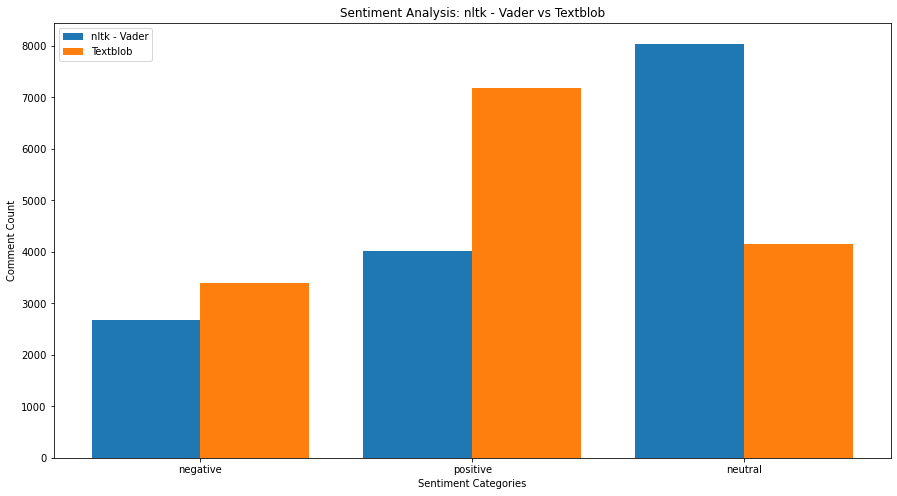

In [119]:
## To produce visualization, the above cells that fetch the comments from reddit will need to be executed

from matplotlib import pyplot as plt
import numpy as np
plt.figure(figsize=(15,8))

x_axis = np.arange(len(sub_entries_textblob))

plt.bar(x_axis -0.2, sub_entries_nltk.values(), width=0.4, label = 'nltk - Vader')
plt.bar(x_axis +0.2, sub_entries_textblob.values(), width=0.4, label = 'Textblob')

plt.xticks(x_axis, sub_entries_textblob.keys())

plt.legend(loc='upper left')
plt.xlabel("Sentiment Categories")
plt.ylabel("Comment Count")
plt.title("Sentiment Analysis: nltk - Vader vs Textblob")
plt.show()

In [66]:
#Loading comments

df_pos = pd.read_csv('Positive_Comments.csv', sep='\t')
df_pos.drop(['Unnamed: 0'],axis='columns',inplace=True)
df_neg = pd.read_csv('Negative_Comments.csv', sep='\t')
df_neg.drop(['Unnamed: 0'],axis='columns',inplace=True)
df_neutral = pd.read_csv('Neutral_Comments.csv', sep='\t')
df_neutral.drop(['Unnamed: 0'],axis='columns',inplace=True)
df_upvotes = pd.read_csv('Upvotes.csv', sep='\t')
df_upvotes.drop(['Unnamed: 0'],axis='columns',inplace=True)

In [67]:
# Cleaning dataset

def word_extraction(sentence):
    #ignore = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]    
      
    ret = sentence.lower()
    return ret

df_pos["Positive Comments"] = df_pos["Positive Comments"].apply(word_extraction)
df_neg["Negative Comments"] = df_neg["Negative Comments"].apply(word_extraction)
df_neutral["Neutral Comments"] = df_neutral["Neutral Comments"].apply(word_extraction)
df_upvotes['column1'] = df_upvotes['column1'].apply(word_extraction)

# Q2: Have people been discussing the pros and cons of this motion? 

## Create summary for positive and negative

### LSA - implementation without LSA library

Importing all the necessary libraries for text summarization using LSA.

In [4]:
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
from warnings import warn
from nltk.tokenize import sent_tokenize, word_tokenize
from numpy.linalg import svd as singular_value_decomposition
from operator import attrgetter
from collections import namedtuple
import math
import numpy

Latent Semantic Analysis(LSA) is an unsupervised learning approach alongwith the usage of Natural Language Processing(NLP) which extracts the hidden context of semantic structures. The three main step includes:
<br> 1. Creation of the input matrix helps to perform calculations on it where the matrix cell represent the importance of the words.
<br> 2. Singular Value Decomposition models relationships among words and sentences and reduces noise to improve the performance. The document term matrix created in the previous step is then represented as vectors which are used to display the text in the Euclidean space.
<br> 3. Sentence Selection uses the result of the SVD to select topics and sub-topics 
<br>The by-products during the execution of LSA processing are dictionary and encoding matrix. Dictionary contains a set of all the words present in the text. The encoded matrix contains the word of the sentences with respect to their individual strengths.

In [5]:
class ItemsCount(object):
    def __init__(self, value):
        self._value = value

    def __call__(self, sequence):
        if isinstance(self._value, (bytes, str,)):
            if self._value.endswith("%"):
                total_count = len(sequence)
                percentage = int(self._value[:-1])
                # at least one sentence should be chosen
                count = max(1, total_count*percentage // 100)
                return sequence[:count]
            else:
                return sequence[:int(self._value)]
        elif isinstance(self._value, (int, float)):
            return sequence[:int(self._value)]
        else:
            ValueError("Unsuported value of items count '%s'." % self._value)

    def __repr__(self):
        return to_string("<ItemsCount: %r>" % self._value)


SentenceInfo = namedtuple("SentenceInfo", ("sentence", "order", "rating",))

class BaseSummarizer(object):
    
    def __call__(self, document, sentences_count):
        raise NotImplementedError("This method should be overriden in subclass")

    @staticmethod
    def normalize_word(word):
        return word.lower()

    @staticmethod
    def _get_best_sentences(sentences, count, rating, *args, **kwargs):
        rate = rating
        if isinstance(rating, dict):
            assert not args and not kwargs
            rate = lambda s: rating[s]

        infos = (SentenceInfo(s, o, rate(s, *args, **kwargs))
            for o, s in enumerate(sentences))

        # sort sentences by rating in descending order
        infos = sorted(infos, key=attrgetter("rating"), reverse=True)
        # get `count` first best rated sentences
        if not isinstance(count, ItemsCount):
            count = ItemsCount(count)
        infos = count(infos)
        # sort sentences by their order in document
        infos = sorted(infos, key=attrgetter("order"))

        return tuple(i.sentence for i in infos)
    

class LsaSummarizer(BaseSummarizer):
    MIN_DIMENSIONS = 3
    REDUCTION_RATIO = 1/1

    _stop_words = list(stopwords.words('english'))

    @property
    def stop_words(self):
        return self._stop_words

    @stop_words.setter
    def stop_words(self, words):
        self._stop_words = words

    def __call__(self, document, sentences_count):

        dictionary = self._create_dictionary(document)
        
        if not dictionary:
            return ()

        sentences = sent_tokenize(document)

        matrix = self._create_matrix(document, dictionary)
        matrix = self._compute_term_frequency(matrix)
        u, sigma, v = singular_value_decomposition(matrix, full_matrices=False)

        ranks = iter(self._compute_ranks(sigma, v))
        return self._get_best_sentences(sentences, sentences_count,
            lambda s: next(ranks))

    def _create_dictionary(self, document):
        """Creates mapping key = word, value = row index"""

        words = word_tokenize(document)
        words = tuple(words)

        words = map(self.normalize_word, words)

        unique_words = frozenset(w for w in words if w not in self._stop_words)

        return dict((w, i) for i, w in enumerate(unique_words))

    def _create_matrix(self, document, dictionary):
        """
        Creates matrix of shape where cells
        contains number of occurences of words (rows) in senteces (cols).
        """
        sentences = sent_tokenize(document)
        words_count = len(dictionary)
        sentences_count = len(sentences)
        if words_count < sentences_count:
            message = (
                "Number of words (%d) is lower than number of sentences (%d). "
                "LSA algorithm may not work properly."
            )
            warn(message % (words_count, sentences_count))

        matrix = numpy.zeros((words_count, sentences_count))
        for col, sentence in enumerate(sentences):
            words = word_tokenize(sentence)
            for word in words:
                # only valid words is counted (not stop-words, ...)
                if word in dictionary:
                    row = dictionary[word]
                    matrix[row, col] += 1

        return matrix

    
    def _compute_term_frequency(self, matrix, smooth=0.4):
        """
        Computes TF metrics for each sentence (column) in the given matrix and  normalize 
        the tf weights of all terms occurring in a document by the maximum tf in that document 
        according to ntf_{t,d} = a + (1-a)\frac{tf_{t,d}}{tf_{max}(d)^{'}}.
        
        The smoothing term $a$ damps the contribution of the second term - which may be viewed 
        as a scaling down of tf by the largest tf value in $d$
        """
        assert 0.0 <= smooth < 1.0

        max_word_frequencies = numpy.max(matrix, axis=0)
        rows, cols = matrix.shape
        for row in range(rows):
            for col in range(cols):
                max_word_frequency = max_word_frequencies[col]
                if max_word_frequency != 0:
                    frequency = matrix[row, col]/max_word_frequency
                    matrix[row, col] = smooth + (1.0 - smooth)*frequency

        return matrix

    def _compute_ranks(self, sigma, v_matrix):
        assert len(sigma) == v_matrix.shape[0]

        dimensions = max(LsaSummarizer.MIN_DIMENSIONS,
            int(len(sigma)*LsaSummarizer.REDUCTION_RATIO))
        powered_sigma = tuple(s**2 if i < dimensions else 0.0
            for i, s in enumerate(sigma))

        ranks = []
        
        for column_vector in v_matrix.T:
            rank = sum(s*v**2 for s, v in zip(powered_sigma, column_vector))
            ranks.append(math.sqrt(rank))

        return ranks

In [69]:
pos_comms = df_pos["Positive Comments"].to_list()
neg_comms = df_neg['Negative Comments'].to_list()
main_ups = dict(df_upvotes.values)

pos_comms_sorted = []
neg_comms_sorted = []

sorted_upv = sorted(main_ups.items(), key=lambda x: x[1], reverse=True)
for comm in sorted_upv:
    if comm[0] in pos_comms:
        pos_comms_sorted.append(comm[0])
    elif comm[0] in neg_comms:
        neg_comms_sorted.append(comm[0])
        
        
positive =  " . ".join(pos_comms_sorted[0:1000]).replace("\n","")
negative =  " . ".join(neg_comms_sorted[0:1000]).replace("\n","")

In [71]:
def lsa_summarizier_(ls,stopwords):
    
    summarizer = LsaSummarizer()
    stopwords = stopwords.words('english')
    summarizer.stop_words = stopwords

    summary =summarizer(ls, 4)

    print("\n========= Summary =========")

    print("\n\n".join(summary))
    print("========= End of summary =========")
    
print("FOR POSITIVE:")
lsa_summarizier_(positive,stopwords)

print("\n\n*************************************************\n\nFOR NEGATIVE:")
lsa_summarizier_(negative,stopwords)

FOR POSITIVE:

========= Summary =========
even selfish idiots (or deluded people) deserve to have their lives saved or improved if possible.  . just to play devil’s advocate...if her husband is brain dead, is he really going to get any meaningful use out of that kidney?

if they had a little red heart on it then we’d wait for them to croak before playing rock paper scissors go on shoot best out of three to divide your crap up before tossing your organs into a cooler and selling them to rich hospital donors that are on their third liver.

the society also  has a right to tell your selfish ass that you don't get to benefit from others deaths.  . i love the idea in theory but one issue..what if you opt out, are in an accident and the hospital cannot find your id that states you opted out?

she finds out it's the last thing the eyes original owner saw before she died.i was thinking it was before anything you referenced other than the twilight zone, so i went looking for the year it aired 

### Using Sumy

Sumy is a Python library for automatic extraction and summarization of texts. The basic architecture consists of:
<br> 1. Document - This is the document which needs to be summarized. In this case we have given the positive and negtive comments.
<br> 2. Tokenizer - The tokenizer is used to create a document/parser. Below we have sent a pull request to Sumy with the language argument as "English".
<br> 3. Parser - There are 2 implementations of parsers provided by sumy. PlainTextParser and the HTMLParser. Here we have used the PlainTextParser.
<br> 4. Summarizer - The arguments to a summarizer consists of the document which needs to be summarized and the count of the sentences that needs to be returned. The different summarizers are implemented below.

In [ ]:
!pip install sumy

#### LexRank

The LexRank summarizer works on the principle that a sentence has high priority if it is similar to many other sentences. A sentence is ranked higher and hence given more importance if it is recommended by the other sentences. 

In [49]:
def lexrank():

    from sumy.summarizers.lex_rank import LexRankSummarizer

    summarizer_lex = LexRankSummarizer()
    summary = summarizer_lex(parser.document,6)

    main_summary = []
    print("**Summary - LexRank:\n")
    for sentence in summary:
        print(sentence,"\n\n")
        main_summary.append(sentence)

#### LSA

Latent Semantic Analysis uses algebraic method by applying SVD to  the term-document frequency. It can identify synonyms for texts and topics which might not have been explicitly mentioned. Above we have implemented our own implementation of the LSA. Here we directly use the LsaSummarizer provided by Sumy.

In [50]:
def lsa():

    from sumy.summarizers.lsa import LsaSummarizer
    summarizer_lsa = LsaSummarizer()
    summary =summarizer_lsa(parser.document,6)

    main_summary = []
    print("\n\nSummary - LSA:\n")
    for sentence in summary:
        print(sentence)
        main_summary.append(sentence)

#### KL - Sum

KL-Sum algorithm adds sentences greedily in such a way that it reduces the KL Divergence. It is based on the KL-Sum algorithm which uses the concept of similarity of word distribution to select sentences.

In [51]:
def kl():    
    from sumy.summarizers.kl import KLSummarizer
    summarizer_kl = KLSummarizer()

     # Summarize using sumy KL Divergence
    summary =summarizer_kl(parser.document,6)
    main_summary = []
    print("\n\nSummary - KL:\n")
    for sentence in summary:
        print(sentence)
        main_summary.append(sentence)

In [73]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

positive =  " . ".join(pos_comms_sorted[0:1000]).replace("\n","")
negative =  " . ".join(neg_comms_sorted[0:1000]).replace("\n","")

#generating summary for the positive comments using LexRank, LSA and KL
parser = PlaintextParser.from_string(positive,Tokenizer("english"))
print("\nSUMMARY FOR POSITIVE:\n")
lexrank()   
lsa()
kl()

#generating summary of the negative comments using LexRank, LSA and KL
parser = PlaintextParser.from_string(negative,Tokenizer("english"))
print("\n\n************************************************************\n\nSUMMARY FOR NEGATIVE:\n")
lexrank()
lsa()
kl()


SUMMARY FOR POSITIVE:


Summary - LexRank:

but in that case i don't want my organs going to *you*, which is *my* autonomy. . what's the most interesting thing to me is the fact that if you do opt out, you're at the bottom of the list for receiving organs, meaning if you don't give, you can't take (as easily). 


you can't make someone give up their right to be whole if they don't want to be. . > except it's super easy to opt in to be an organ donor.sure, but this conversation was about 'all programs in general'.>  if you have a drivers license, you've had a chance to say yes.which is good, but not practical for many other programs.> if you don't have a drivers license you probably aren't a productive member of societyor you're under 16... or you're simply too poor to bother with cars. . i could name a few more apt heirs than the government tho. . if people *really* want to be an asshole and keep life-saving organs to be buried with them, they have the ability to opt out. 


it's 2 mo

### tf-idf

Term Frequency-Inverse Document Frequency is a statistical based approach which is used here for text summarization. Term frequency denotes the how frequently does a particular word appear in the document. The Inverse Document Frequency simply implies that we decrease the weight for commonly used words and increase the weight for the words that have not been used frequently in the document. In this method the Zipf's law is used which says that 'The Frequency that the word appears is inversely proportional to its rank'.
<br>The main steps include:
<br>1. Removal of the stopwords from the document.
<br>2. Defining a function to calculate  the frequency matrix.
<br>3. Defining a function to calculate the Term- frequency matrix.
<br>4. Defining a function to calculate the Inverse document frequency
<br>5. Defining a function to combine the TD-IDF functions.

In [74]:
def _create_frequency_matrix(sentences):
    frequency_matrix = {}
    stopWords = set(stopwords.words("english"))
    ps = PorterStemmer()

    for sent in sentences:
        freq_table = {}
        words = word_tokenize(sent)
        for word in words:
            word = word.lower()
            word = ps.stem(word)
            if word in stopWords:
                continue

            if word in freq_table:
                freq_table[word] += 1
            else:
                freq_table[word] = 1

        frequency_matrix[sent[:15]] = freq_table

    return frequency_matrix


def _create_tf_matrix(freq_matrix):
    tf_matrix = {}

    for sent, f_table in freq_matrix.items():
        tf_table = {}

        count_words_in_sentence = len(f_table)
        for word, count in f_table.items():
            tf_table[word] = count / count_words_in_sentence

        tf_matrix[sent] = tf_table

    return tf_matrix


def _create_documents_per_words(freq_matrix):
    word_per_doc_table = {}

    for sent, f_table in freq_matrix.items():
        for word, count in f_table.items():
            if word in word_per_doc_table:
                word_per_doc_table[word] += 1
            else:
                word_per_doc_table[word] = 1

    return word_per_doc_table


def _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents):
    idf_matrix = {}

    for sent, f_table in freq_matrix.items():
        idf_table = {}

        for word in f_table.keys():
            idf_table[word] = math.log10(total_documents / float(count_doc_per_words[word]))

        idf_matrix[sent] = idf_table

    return idf_matrix


def _create_tf_idf_matrix(tf_matrix, idf_matrix):
    tf_idf_matrix = {}

    for (sent1, f_table1), (sent2, f_table2) in zip(tf_matrix.items(), idf_matrix.items()):

        tf_idf_table = {}

        for (word1, value1), (word2, value2) in zip(f_table1.items(),
                                                    f_table2.items()):  # here, keys are the same in both the table
            tf_idf_table[word1] = float(value1 * value2)

        tf_idf_matrix[sent1] = tf_idf_table

    return tf_idf_matrix


def _score_sentences(tf_idf_matrix) -> dict:
    """
    score a sentence by its word's TF
    Basic algorithm: adding the TF frequency of every non-stop word in a sentence divided by total no of words in a sentence.
    :rtype: dict
    """

    sentenceValue = {}

    for sent, f_table in tf_idf_matrix.items():
        total_score_per_sentence = 0

        count_words_in_sentence = len(f_table)
        for word, score in f_table.items():
            total_score_per_sentence += score

        sentenceValue[sent] = total_score_per_sentence / count_words_in_sentence

    return sentenceValue


def _find_average_score(sentenceValue) -> int:
    """
    Find the average score from the sentence value dictionary
    :rtype: int
    """
    sumValues = 0
    for entry in sentenceValue:
        sumValues += sentenceValue[entry]

    # Average value of a sentence from original summary_text
    average = (sumValues / len(sentenceValue))

    return average

def _generate_summary(sentences, sentenceValue, threshold):
    sentence_count = 0
    summary = ''

    for sentence in sentences:
        if sentence[:15] in sentenceValue and sentenceValue[sentence[:15]] >= (threshold):
            summary += " " + sentence
            sentence_count += 1

    return summary

In [125]:
from nltk import sent_tokenize, word_tokenize, PorterStemmer  

'''
We already have a sentence tokenizer, so we just need 
to run the sent_tokenize() method to create the array of sentences.
'''

def tf_idf_(sentences):
    total_documents = len(sentences)
    
    # 2 Create the Frequency matrix of the words in each sentence.
    freq_matrix = _create_frequency_matrix(sentences)

    '''
    Term frequency (TF) is how often a word appears in a document, divided by how many words are there in a document.
    '''
    # 3 Calculate TermFrequency and generate a matrix
    tf_matrix = _create_tf_matrix(freq_matrix)

    # 4 creating table for documents per words
    count_doc_per_words = _create_documents_per_words(freq_matrix)

    '''
    Inverse document frequency (IDF) is how unique or rare a word is.
    '''
    # 5 Calculate IDF and generate a matrix
    idf_matrix = _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents)

    # 6 Calculate TF-IDF and generate a matrix
    tf_idf_matrix = _create_tf_idf_matrix(tf_matrix, idf_matrix)

    # 7 Important Algorithm: score the sentences
    sentence_scores = _score_sentences(tf_idf_matrix)

    # 8 Find the threshold
    threshold = _find_average_score(sentence_scores)

    # 9 Important Algorithm: Generate the summary
    summary = _generate_summary(sentences, sentence_scores, 3*threshold)
    print(summary)
    
positive = df_pos["Positive Comments"].to_list()[0:1000]
negative = df_neg["Negative Comments"].to_list()[0:1000]
print("SUMMARY FOR POSITIVE:\n")
tf_idf_(positive)
print("\n******************************************************\nSUMMARY FOR NEGATIVE:\n")
tf_idf_(negative)


SUMMARY FOR POSITIVE:

 absolutely all for it.  seems reasonable fantastic move good good  love it! cool
 awesome! great idea  doesnt sit right with me tbh i love it love it good move for society  very good great good cool happy cake day awesome! that's awesome great idea absolutely perfect. i feel good very good cool awesome! brilliant cool. fine modern problems require modern solutions good fine good fantastic  great! honestly it should be the norm fine with it smart this is amazing beautiful  dae popular reddit opinion??!?!???? amazing news.  great! lol cool with me excellent. there are no downsides.  awesome that's cool fucking awesome that it is normal ? excellent idea

******************************************************
SUMMARY FOR NEGATIVE:

 howdoyoufelboutthis


fuck off should be mandatory world wide like this tbh not an icelander, but as long as the opt-out process isn’t annoyingly bureaucratic for those who have legitimate issues with organ donation... i don’t see a prob

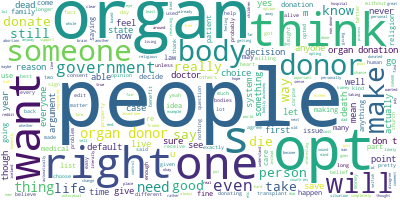

In [104]:
from wordcloud import WordCloud

positive =  " . ".join(pos_comms_sorted[0:1000]).replace("\n","")
negative =  " . ".join(neg_comms_sorted[0:1000]).replace("\n","")

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud for positive
wordcloud.generate(positive)

# visualize the word cloud
wordcloud.to_image()

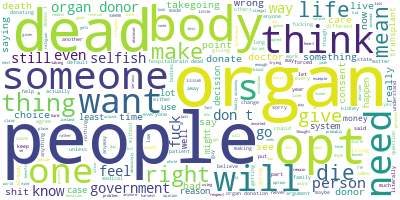

In [105]:
# generate a word cloud for negative
wordcloud.generate(negative)

# visualize the word cloud
wordcloud.to_image()

# Q3: Topic Modelling

## LSA with gensim for analysis

Importing the necessary libraries for LSA with genism.

In [ ]:
!pip install gensim

In [86]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer 
from gensim.models.coherencemodel import CoherenceModel

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In the below steps we define the following methods
<br> 1. preprocess_data - To pre-process the document by tokenizing the sentence, removing the stop words and then cleaning.
<br> 2. prepare_corpus - To create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
<br> 3. create_gensim_lsa_model - To create LSA model using gensim
<br> 4. compute_coherence_values - To compute c_v coherence for various number of topics

In [87]:
''' Document list as an argument to preprocess_data which will return preprocessed text as output'''
def preprocess_data(doc_set):
    
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [lemmatizer.lemmatize(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

'''the preprecessed document as an argument to the prepare_corpus which returns the term dictionary and Document Term Matrix'''
def prepare_corpus(doc_clean):
    
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

'''It creates an lsa model based on the number of topocs, words and the preprocessed document'''
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

'''This function generates a list of LSA models along with their corresponding coherence values'''
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

'''Function to visualize the topics with respect to their coherence score generated by the compute_coherence_values method.'''
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [88]:
#For positive
number_of_topics=4
words=10
document_list = pos_comms_sorted
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)
model.show_topics(formatted=False)

# Commenting out the part used to figure out the optimal number of topics
'''start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)'''

#For negative
number_of_topics=4
words=10
document_list = neg_comms_sorted
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)
model.show_topics(formatted=False)
'''start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)'''

[(0, '0.519*"organ" + 0.368*"people" + 0.247*"opt" + 0.239*"donor" + 0.174*"would" + 0.137*"life" + 0.137*"body" + 0.136*"one" + 0.134*"think" + 0.128*"right"'), (1, '0.676*"organ" + 0.343*"donor" + -0.308*"people" + -0.229*"body" + -0.161*"right" + -0.119*"like" + -0.102*"opt" + -0.100*"would" + -0.098*"think" + 0.097*"donation"'), (2, '-0.631*"opt" + -0.376*"people" + 0.261*"consent" + 0.229*"body" + 0.214*"person" + 0.203*"someone" + 0.157*"right" + -0.131*"donor" + 0.126*"life" + 0.123*"dead"'), (3, '0.627*"opt" + -0.567*"people" + 0.295*"consent" + -0.194*"donor" + 0.124*"someone" + 0.116*"person" + 0.085*"want" + 0.083*"donation" + 0.081*"body" + 0.077*"system"')]
[(0, '0.564*"organ" + 0.346*"people" + 0.202*"donor" + 0.193*"dead" + 0.165*"opt" + 0.162*"would" + 0.156*"life" + 0.149*"someone" + 0.135*"body" + 0.127*"like"'), (1, '-0.651*"organ" + 0.529*"people" + 0.272*"opt" + -0.158*"donor" + 0.129*"thing" + 0.124*"like" + -0.096*"dead" + 0.093*"make" + 0.081*"one" + 0.079*"gove

'start,stop,step=2,12,1\nplot_graph(clean_text,start,stop,step)'

## LDA for complete analysis

### Performing Analysis for positive

In [ ]:
!pip install pyLDAvis

In [ ]:
!pip install spacy==3.0
!python -m spacy download en_core_web_sm

In [89]:
import sys
import numpy as np
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline

In [90]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [lemmatizer.lemmatize(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts



data = pos_comms_sorted
data_words = preprocess_data(data)

id2word = corpora.Dictionary(data_words)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.038*"organ" + 0.028*"people" + 0.024*"opt" + 0.016*"would" + '
  '0.016*"right" + 0.014*"life" + 0.014*"government" + 0.013*"person" + '
  '0.012*"donor" + 0.012*"want"'),
 (1,
  '0.045*"someone" + 0.040*"make" + 0.023*"know" + 0.018*"going" + '
  '0.017*"sure" + 0.016*"family" + 0.014*"else" + 0.014*"pretty" + '
  '0.013*"transplant" + 0.012*"get"'),
 (2,
  '0.018*"question" + 0.017*"opinion" + 0.017*"anyone" + 0.017*"better" + '
  '0.014*"shitty" + 0.014*"medical" + 0.013*"come" + 0.012*"free" + '
  '0.011*"used" + 0.010*"fact"'),
 (3,
  '0.049*"one" + 0.039*"dead" + 0.025*"take" + 0.023*"feel" + 0.020*"well" + '
  '0.020*"something" + 0.019*"time" + 0.017*"body" + 0.017*"first" + '
  '0.014*"use"')]


In [91]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

C:\Users\shubh\AppData\Local\Temp/ipykernel_3364/2260404858.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\shubh\AppData\Local\Temp/ipykernel_3364/2260404858.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               0              0.6738   
1            1               1              0.7573   
2            2               2              0.4500   
3            3               0              0.8074   
4            4               1              0.6563   
5            5               0              0.7744   
6            6               2              0.4928   
7            7               0              0.7779   
8            8               2              0.6487   
9            9               0              0.9358   

                                            Keywords  \
0  organ, people, opt, would, right, life, govern...   
1  someone, make, know, going, sure, family, else...   
2  question, opinion, anyone, better, shitty, med...   
3  organ, people, opt, would, right, life, govern...   
4  someone, make, know, going, sure, family, else...   
5  organ, people, opt, would, right, life, govern...   
6  question, opinion, anyone, better, shitty, med...   
7  organ, people, opt, would, right, life, govern...   
8  question, opinion, anyone, better, shitty, med...   
9  organ, people, opt, would, right, life, govern...   

                                                Text  
0  [long, ability, opt, easy, evident, care, edit...  
1  [always, said, way, got, extra, 13, year, dad,...  
2                        [organ, free, anyone, need]  
3  [smart, idea, care, enough, organ, donor, opt,...  
4    [know, heart, edit, serious, note, great, idea]  
5  [super, easy, online, tried, signing, site, tw...  
6  [right, want, stuffed, mounted, next, giant, b...  
7  [seems, weird, stigma, people, think, organ, d...  
8  [take, lung, gill, come, 2, week, edit, first,...  
9  [sean, lock, organ, donation, go, long, organ,...

In [92]:
df_positive_processed = pd.merge(df_dominant_topic, df_pos,
                                 left_index=True, right_index=True)
df_positive_processed.sort_values(by = ['Topic_Perc_Contrib'], 
                                  ascending=False)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
5766         5766               0              0.9697   
6229         6229               0              0.9672   
6925         6925               0              0.9641   
4162         4162               0              0.9619   
4308         4308               0              0.9600   
...           ...             ...                 ...   
4110         4110               2              0.2513   
6994         6994               2              0.2508   
5942         5942               1              0.2503   
5945         5945               0              0.2500   
3666         3666               0              0.2500   

                                               Keywords  \
5766  organ, people, opt, would, right, life, govern...   
6229  organ, people, opt, would, right, life, govern...   
6925  organ, people, opt, would, right, life, govern...   
4162  organ, people, opt, would, right, life, govern...   
4308  organ, people, opt, would, right, life, govern...   
...                                                 ...   
4110  question, opinion, anyone, better, shitty, med...   
6994  question, opinion, anyone, better, shitty, med...   
5942  someone, make, know, going, sure, family, else...   
5945  organ, people, opt, would, right, life, govern...   
3666  organ, people, opt, would, right, life, govern...   

                                                   Text  \
5766  [people, right, die, people, right, conceived,...   
6229  [informed, non, duressed, affirmative, presume...   
6925  [government, able, decide, body, upon, death, ...   
4162  [long, stigma, willing, donate, im, donating, ...   
4308  [portuguese, law, place, since, 2006, way, aro...   
...                                                 ...   
4110  [great, real, legitimate, response, next, ques...   
6994                         [course, real, dick, deny]   
5942                    [honestly, know, thinking, lol]   
5945                                                 []   
3666                                                 []   

                                      Positive Comments  
5766  yes, they do have forms to complete ahead of t...  
6229        yeesh.  wow.  yikes.  oh.  oof.  yeah, wow.  
6925  so it sounds to me like you just don't care mu...  
4162  if you don't mind me asking, what would be som...  
4308  that's how the klingons feel when someone dies...  
...                                                 ...  
4110  that's why with a lot of social policies they ...  
6994  your argument falls apart when you look at how...  
5942  i'm sure there are, with enough money. there a...  
5945  i like kevin smith's philosophy which he put i...  
3666  yeah, i assumed it was unpopular here from jus...  

[7082 rows x 6 columns]

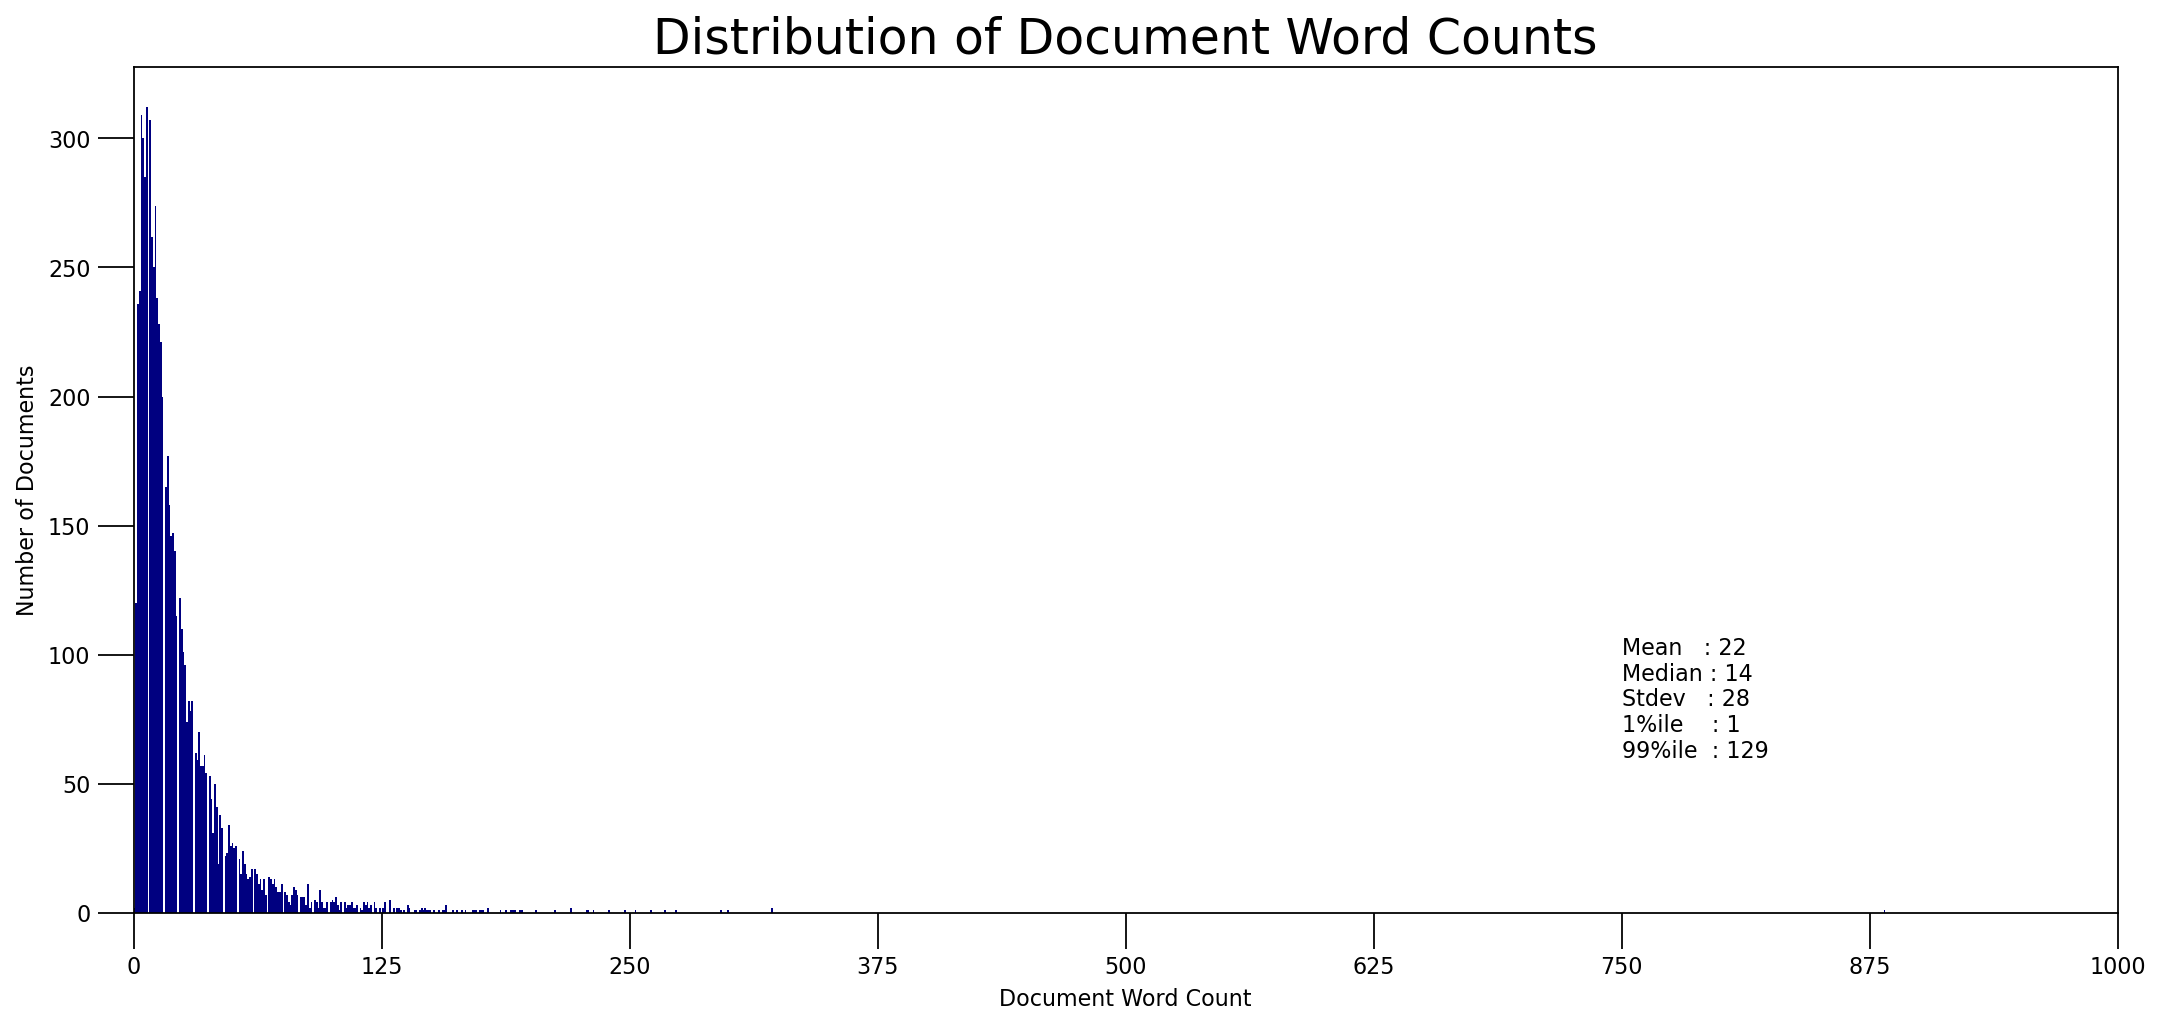

In [93]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [ ]:
!pip install seaborn

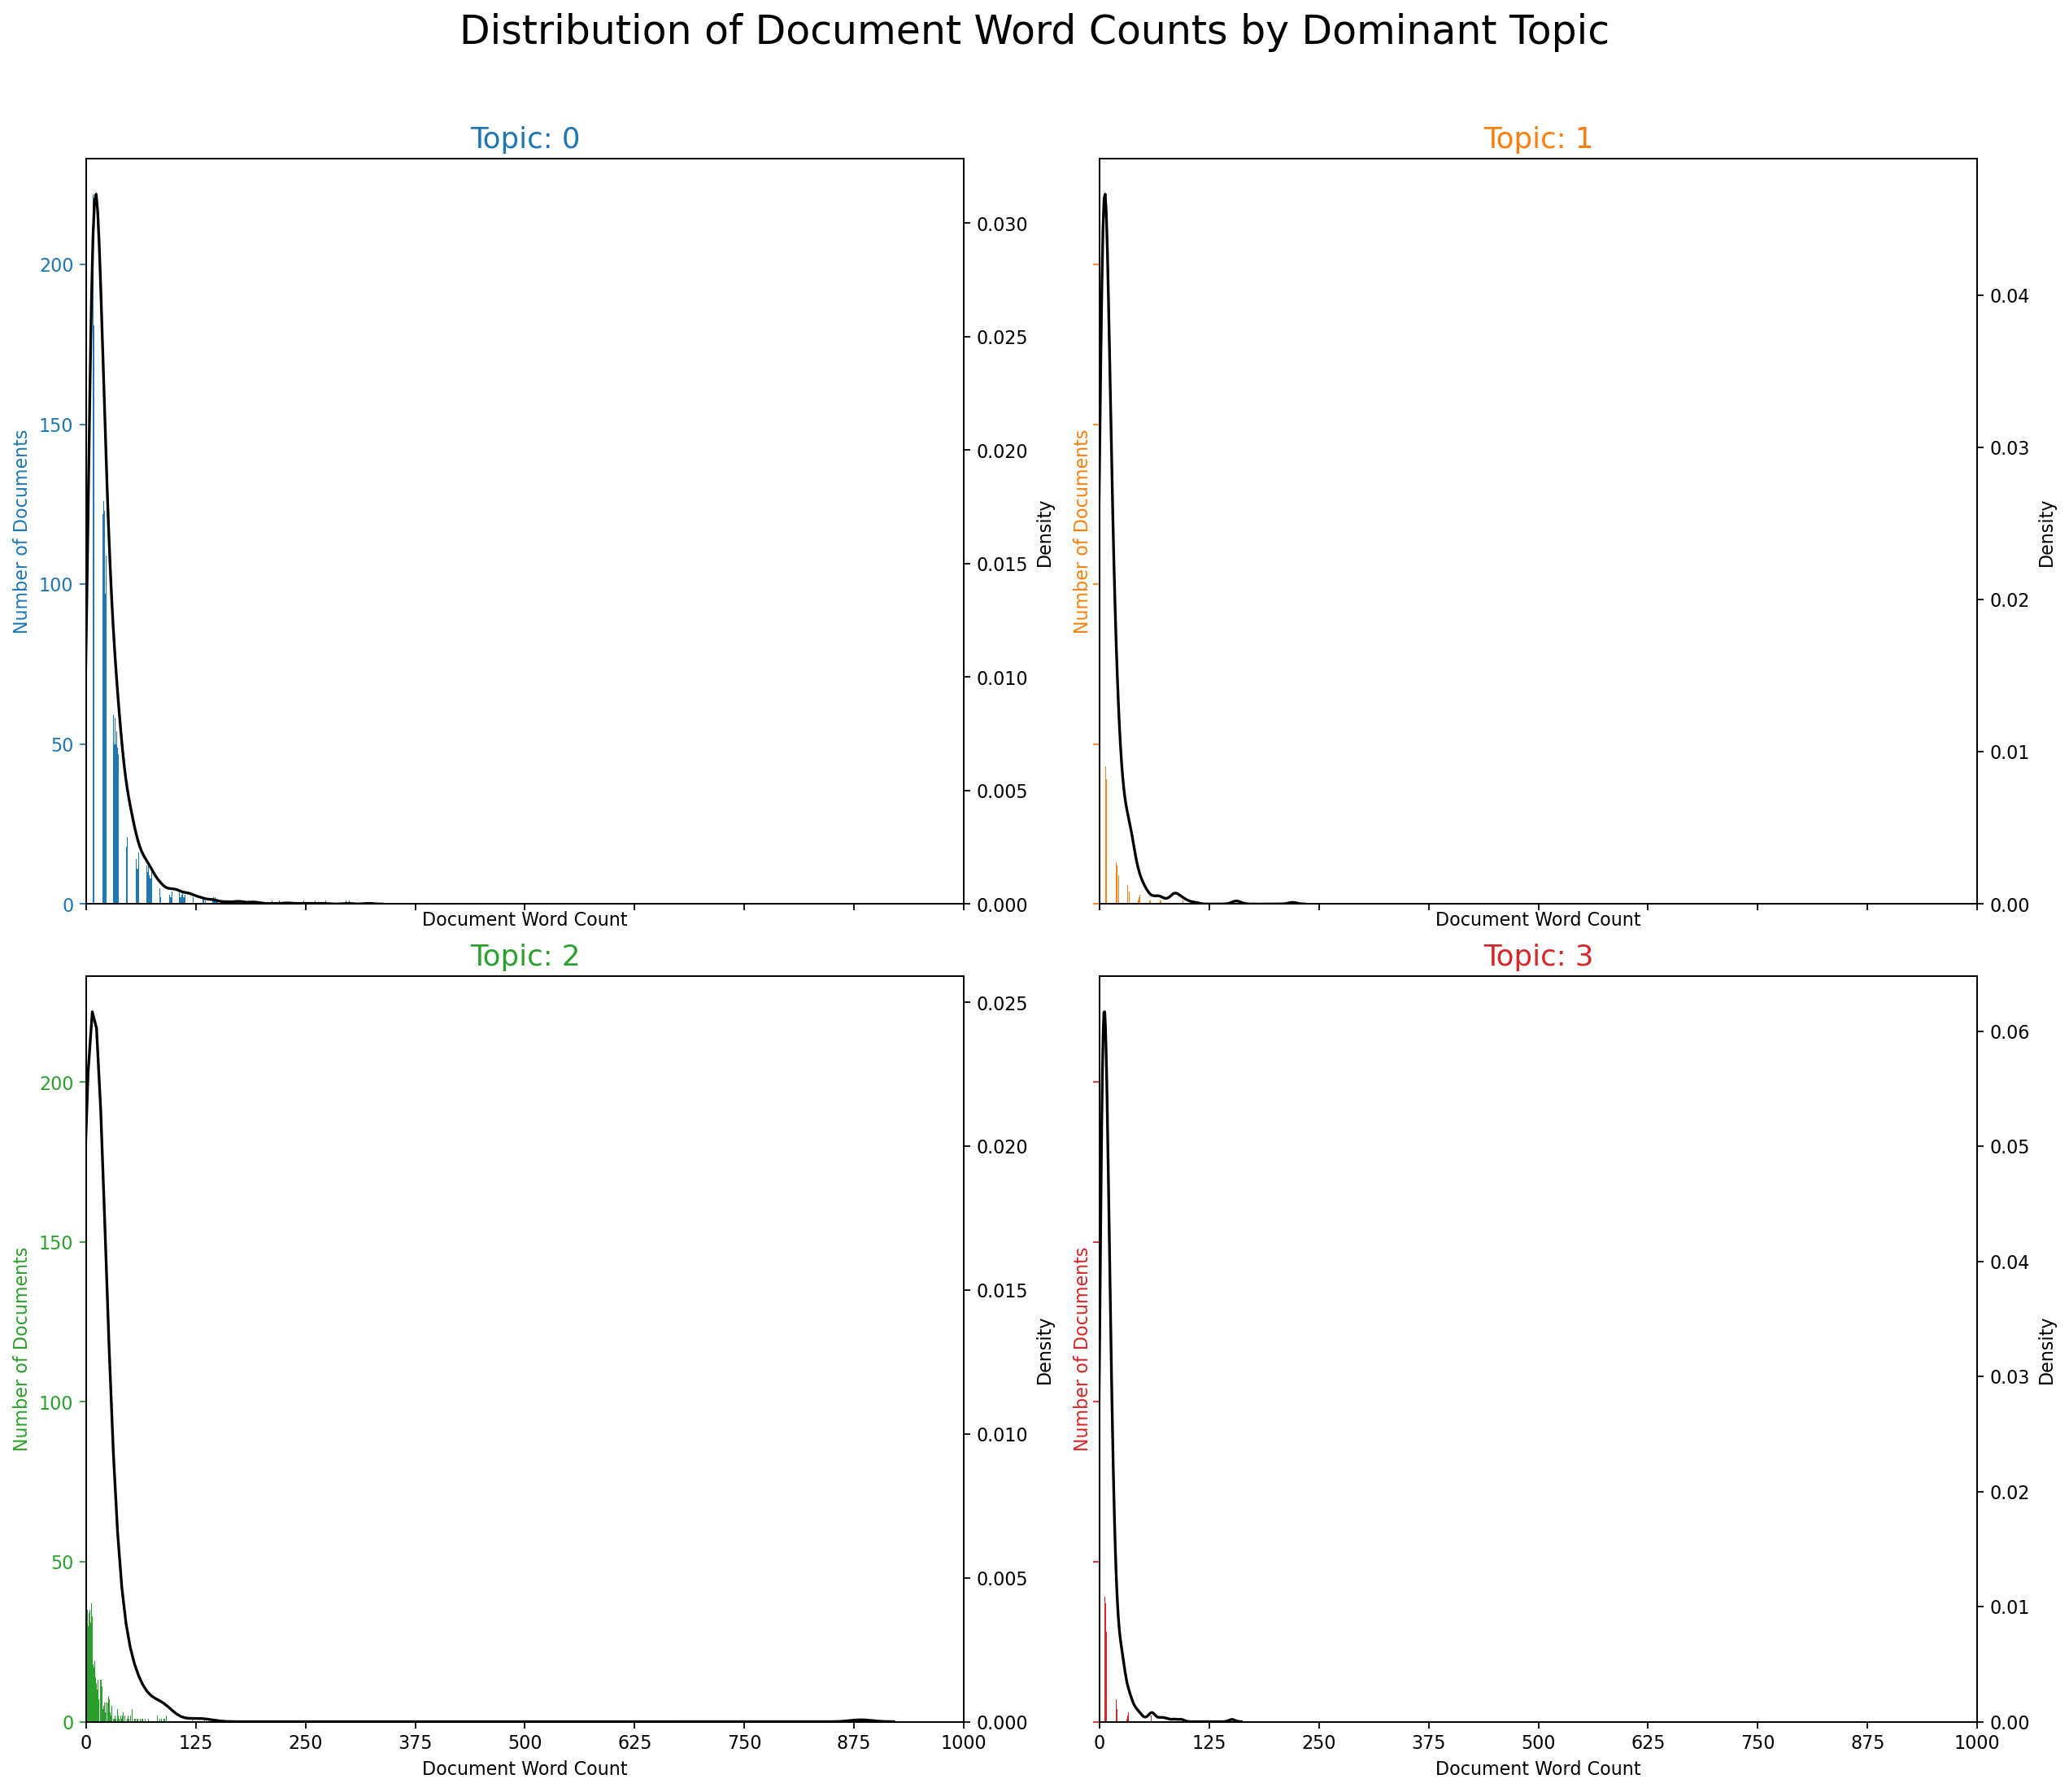

In [95]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [ ]:
!pip install wordcloud

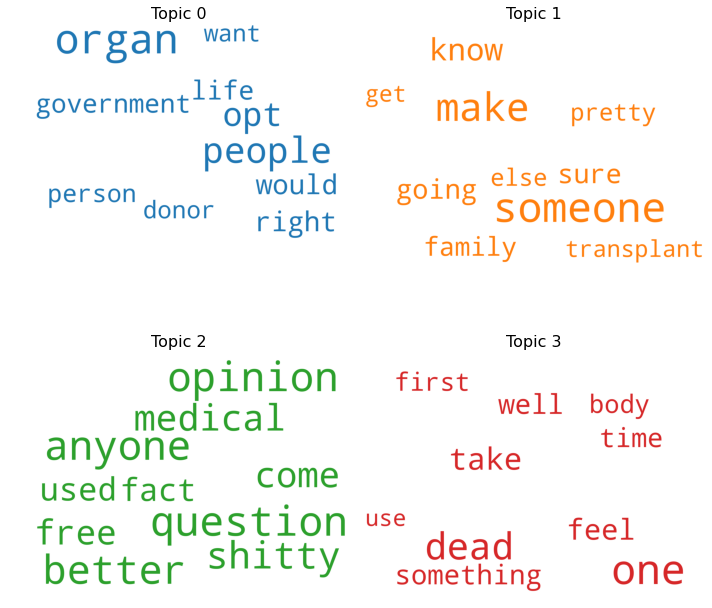

In [96]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [97]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

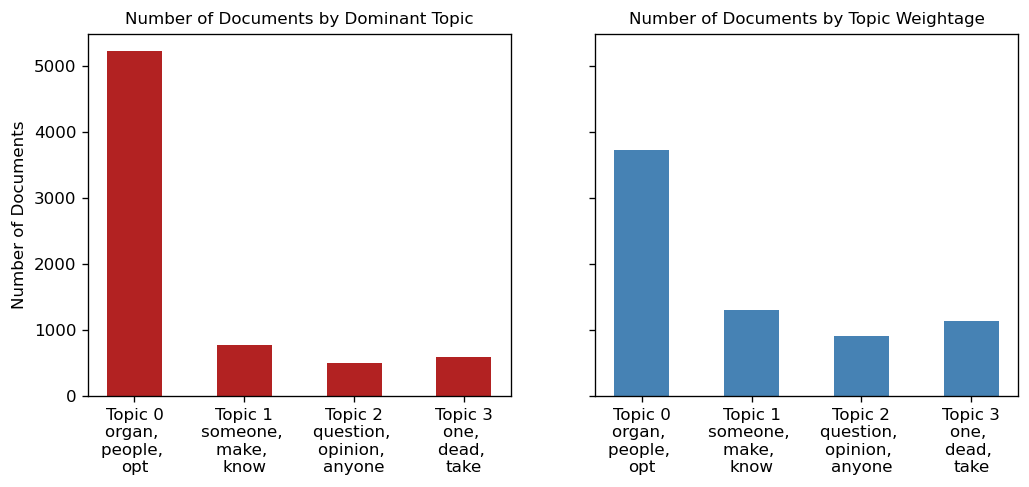

In [98]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')


# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [99]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\shubh\anaconda3\envs\tf-gpu\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.360294  0.035200       1        1  56.447604
1     -0.135167  0.226288       2        1  17.058903
3     -0.072646 -0.275163       3        1  14.733519
2     -0.152481  0.013676       4        1  11.759974, topic_info=         Term         Freq        Total Category  logprob  loglift
166       one  1146.000000  1146.000000  Default  30.0000  30.0000
54    someone  1216.000000  1216.000000  Default  29.0000  29.0000
51      organ  3405.000000  3405.000000  Default  28.0000  28.0000
49       make  1086.000000  1086.000000  Default  27.0000  27.0000
211      dead   920.000000   920.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
953     guess    99.973656   100.674116   Topic4  -5.2271   2.1335
283      call    94.700514    95.412825   Topic4  -5.2813   2.1330
988    common    98.923946    99.741915   Topic4  -5.2377   2.1322
2110      www    81.611762    82.307023   Topic4  -5.4300   2.1320
499     group    97.611249    98.452070   Topic4  -5.2510   2.1319

[161 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
519       3  0.992322   already
31        2  0.992227    always
1         4  0.994966    answer
61        4  0.998996    anyone
746       1  0.997978  argument
...     ...       ...       ...
447       2  0.051200     would
2110      4  0.996270       www
3481      3  0.992705     x200b
252       2  0.998362      yeah
60        2  0.995421      year

[134 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

### Performing Analysis for Negative

In [106]:
data = neg_comms_sorted
data_words = preprocess_data(data)

id2word = corpora.Dictionary(data_words)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())



[(0,
  '0.039*"one" + 0.023*"choice" + 0.018*"also" + 0.016*"money" + '
  '0.013*"argument" + 0.012*"sorry" + 0.010*"anyone" + 0.010*"forced" + '
  '0.009*"rather" + 0.008*"saying"'),
 (1,
  '0.048*"opt" + 0.035*"like" + 0.029*"government" + 0.026*"thing" + '
  '0.019*"point" + 0.018*"people" + 0.017*"donation" + 0.015*"bad" + '
  '0.015*"idea" + 0.011*"law"'),
 (2,
  '0.059*"organ" + 0.043*"dead" + 0.033*"people" + 0.022*"body" + '
  '0.022*"selfish" + 0.022*"need" + 0.017*"right" + 0.017*"make" + '
  '0.016*"give" + 0.015*"fuck"'),
 (3,
  '0.029*"life" + 0.027*"someone" + 0.027*"want" + 0.025*"person" + '
  '0.018*"get" + 0.018*"think" + 0.017*"die" + 0.016*"people" + 0.013*"would" '
  '+ 0.013*"save"')]


In [107]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


C:\Users\shubh\AppData\Local\Temp/ipykernel_3364/2260404858.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\shubh\AppData\Local\Temp/ipykernel_3364/2260404858.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               2              0.8886   
1            1               0              0.3224   
2            2               2              0.9529   
3            3               3              0.8392   
4            4               2              0.4022   
5            5               2              0.8088   
6            6               1              0.8809   
7            7               2              0.5345   
8            8               1              0.4905   
9            9               0              0.3349   

                                            Keywords  \
0  organ, dead, people, body, selfish, need, righ...   
1  one, choice, also, money, argument, sorry, any...   
2  organ, dead, people, body, selfish, need, righ...   
3  life, someone, want, person, get, think, die, ...   
4  organ, dead, people, body, selfish, need, righ...   
5  organ, dead, people, body, selfish, need, righ...   
6  opt, like, government, thing, point, people, d...   
7  organ, dead, people, body, selfish, need, righ...   
8  opt, like, government, thing, point, people, d...   
9  one, choice, also, money, argument, sorry, any...   

                                                Text  
0        [long, still, taxidermy, body, dead, organ]  
1                             [alright, please, lie]  
2  [getting, really, tired, reddit, would, feel, ...  
3  [die, seriously, thinking, going, donate, body...  
4  [redditors, reddit, would, feel, politician, l...  
5                              [holy, fucking, shit]  
6  [feel, like, tempted, put, something, weird, l...  
7                   [allowed, one, testicle, sacred]  
8  [reddit, would, feel, law, banning, thing, bad...  
9                          [mind, use, anus, minute]

In [108]:
df_neg_processed = pd.merge(df_dominant_topic, df_pos,
                                 left_index=True, right_index=True)
df_neg_processed.sort_values(by = ['Topic_Perc_Contrib'], 
                                  ascending=False)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
2               2               2              0.9529   
2092         2092               2              0.9315   
3295         3295               3              0.9249   
2501         2501               2              0.9247   
2325         2325               2              0.9216   
...           ...             ...                 ...   
2611         2611               3              0.2583   
2369         2369               1              0.2514   
1178         1178               0              0.2506   
3325         3325               3              0.2505   
761           761               0              0.2500   

                                               Keywords  \
2     organ, dead, people, body, selfish, need, righ...   
2092  organ, dead, people, body, selfish, need, righ...   
3295  life, someone, want, person, get, think, die, ...   
2501  organ, dead, people, body, selfish, need, righ...   
2325  organ, dead, people, body, selfish, need, righ...   
...                                                 ...   
2611  life, someone, want, person, get, think, die, ...   
2369  opt, like, government, thing, point, people, d...   
1178  one, choice, also, money, argument, sorry, any...   
3325  life, someone, want, person, get, think, die, ...   
761   one, choice, also, money, argument, sorry, any...   

                                                   Text  \
2     [getting, really, tired, reddit, would, feel, ...   
2092  [make, sense, dead, people, need, le, biologic...   
3295  [heard, killer, doctor, nurse, serial, killer,...   
2501  [mean, making, claim, providing, resource, bac...   
2325  [dead, case, neuron, longer, firing, whole, al...   
...                                                 ...   
2611  [haha, maybe, little, sorry, put, wrong, first...   
2369               [opting, irrelevant, thought, count]   
1178                     [sorry, difficult, time, must]   
3325  [context, comment, reddit, work, edit, got, id...   
761                                                  []   

                                      Positive Comments  
2     it's interesting, because this is actually ver...  
2092  i think it's a better system than we have here...  
3295  you don't  care, but grieving relatives usuall...  
2501  isn't that normal in other countries too (in m...  
2325  i'd much rather prefer it that having to sign ...  
...                                                 ...  
2611  i can see that being a good idea for an island...  
2369  as long as they can opt out who cares? sounds ...  
1178  reading this made me question myself, why have...  
3325  when mom passed away, we couldn't bear to allo...  
761                                              great.  

[3377 rows x 6 columns]

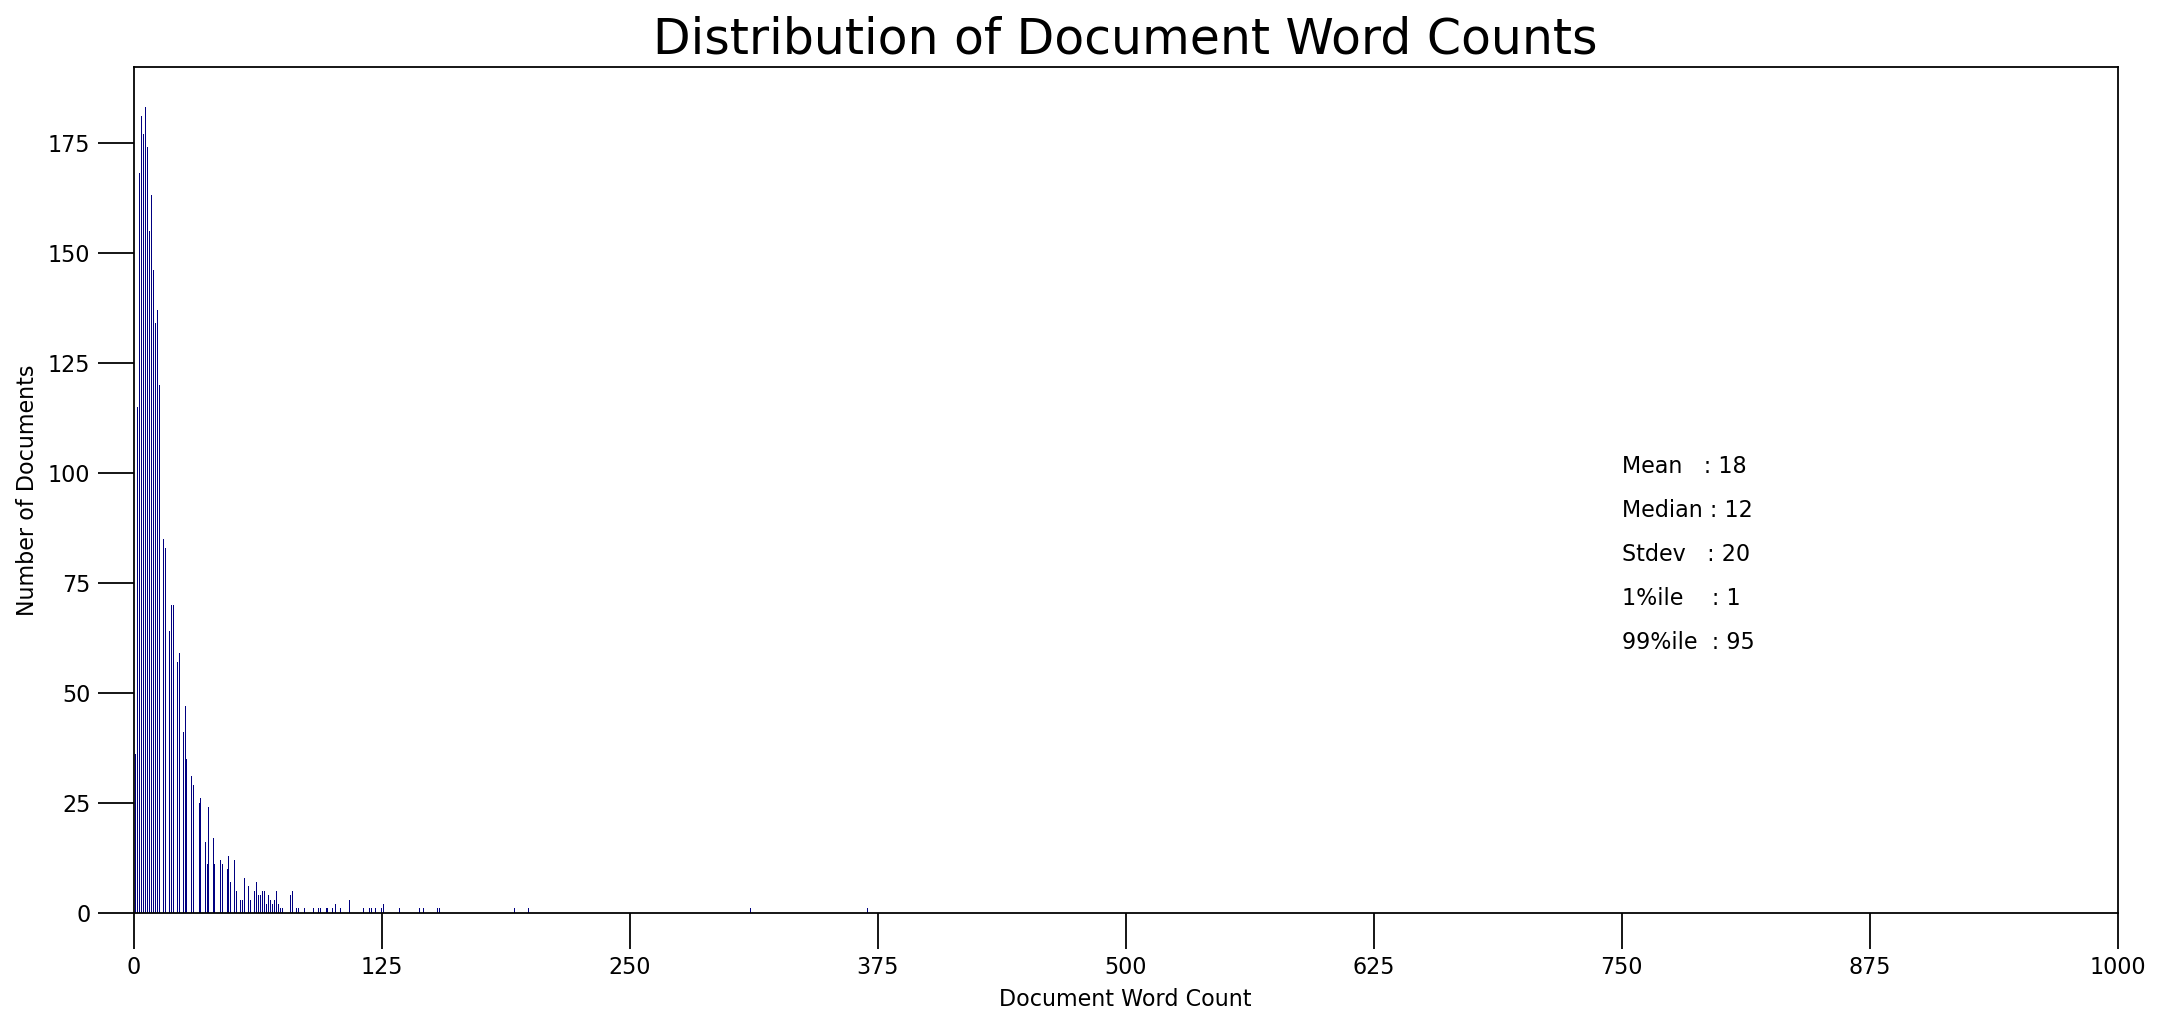

In [109]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()


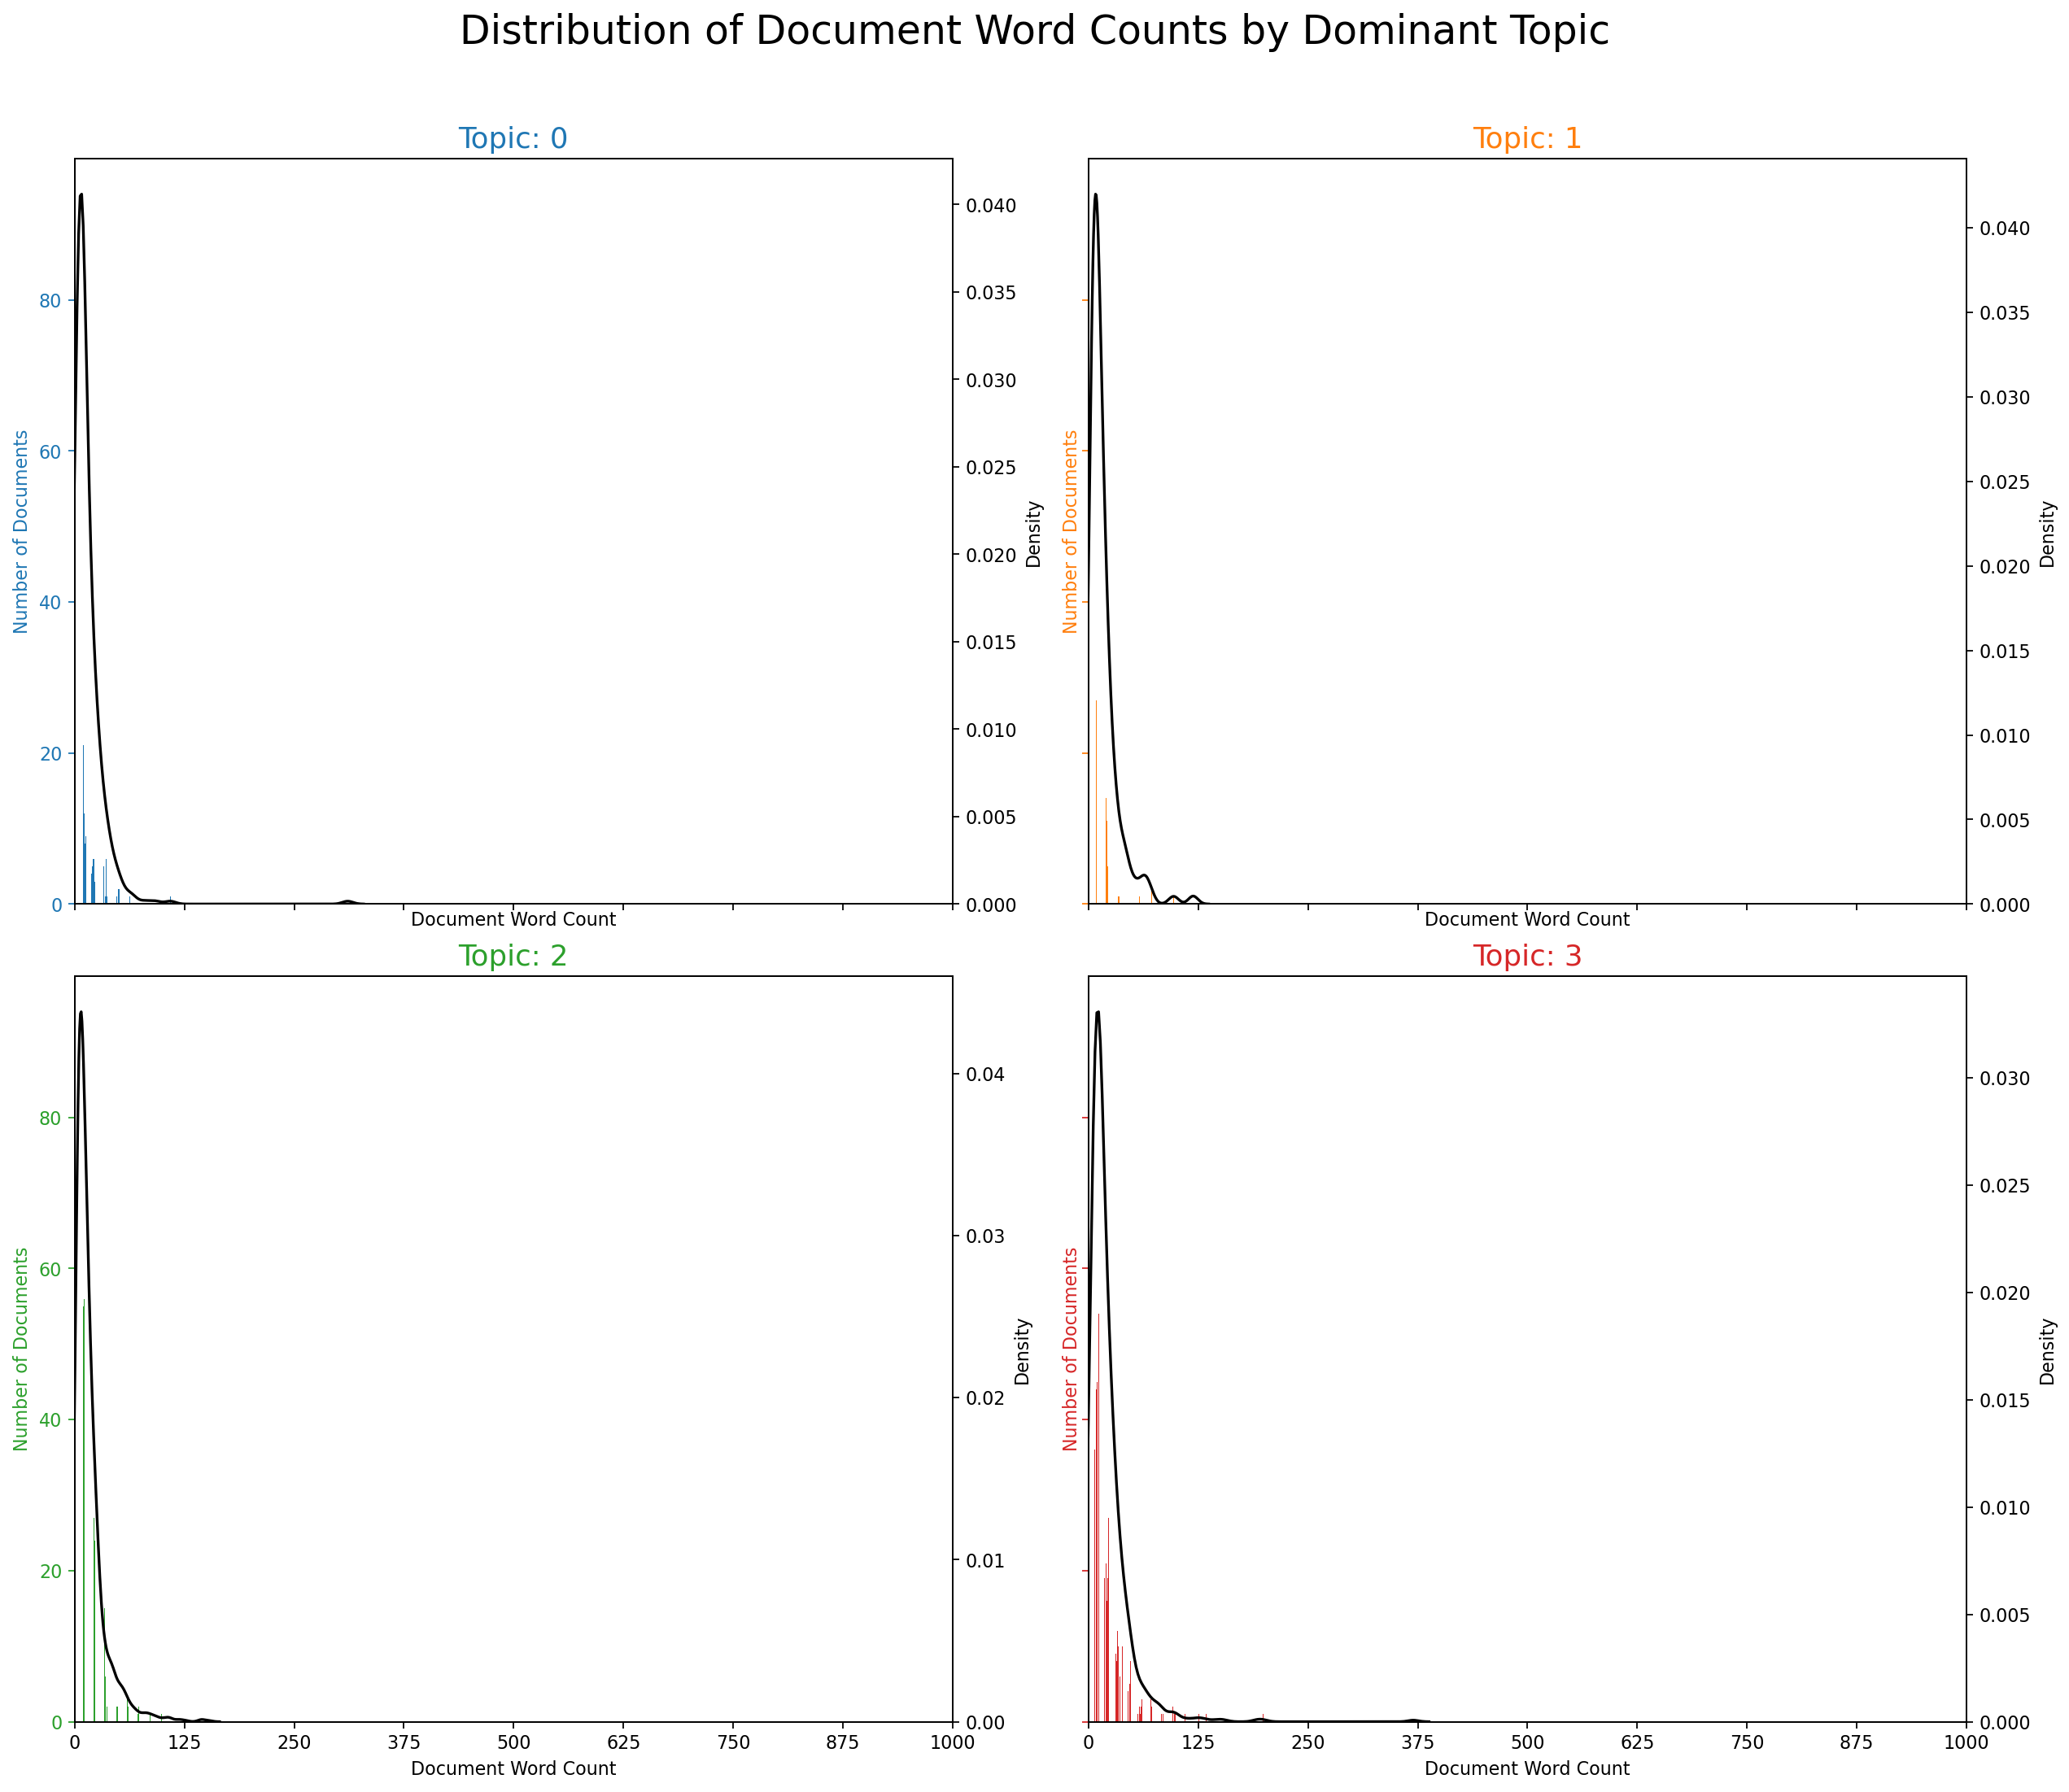

In [110]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()


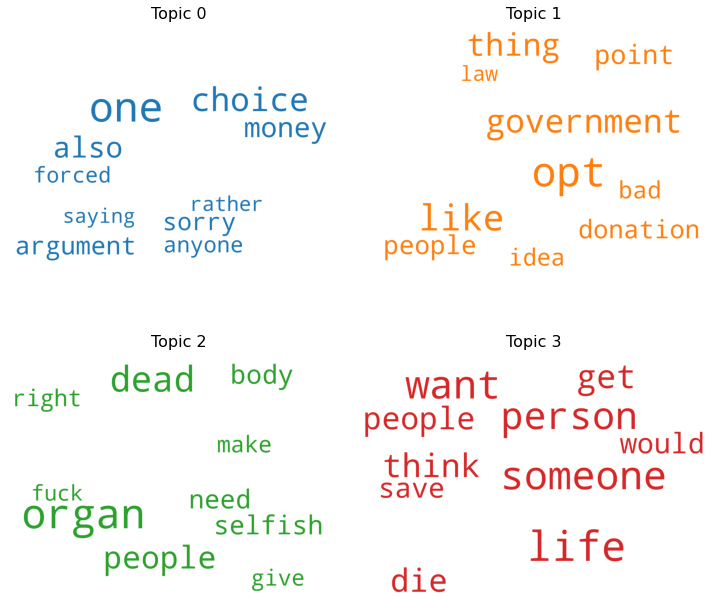

In [111]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [112]:
dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)


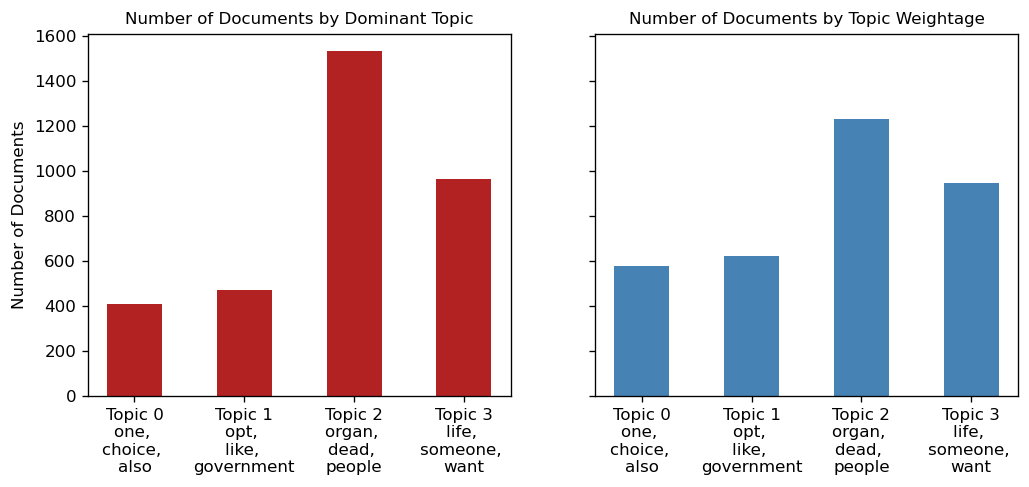

In [113]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')


# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [114]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\shubh\anaconda3\envs\tf-gpu\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.281670  0.112438       1        1  34.360144
3      0.019478 -0.297627       2        1  30.669010
1     -0.101759  0.113200       3        1  18.347484
0     -0.199390  0.071990       4        1  16.623362, topic_info=            Term         Freq        Total Category  logprob  loglift
3          organ  1219.000000  1219.000000  Default  30.0000  30.0000
1           dead   875.000000   875.000000  Default  29.0000  29.0000
61           opt   528.000000   528.000000  Default  28.0000  28.0000
68           one   386.000000   386.000000  Default  27.0000  27.0000
60          like   386.000000   386.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1100      better    55.392474    56.213711   Topic4  -5.1880   1.7796
1368      fucked    55.579118    56.405525   Topic4  -5.1846   1.7796
97         sound    54.652782    55.471790   Topic4  -5.2014   1.7795
2067  healthcare    56.753611    57.694108   Topic4  -5.1637   1.7779
557     everyone    65.329126   112.198496   Topic4  -5.0230   1.2535

[173 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
822       3  0.993717        able
440       3  0.980460  absolutely
674       1  0.996855    actually
123       4  0.987895       alive
134       4  0.995132        also
...     ...       ...         ...
22        1  0.375173       would
22        2  0.625288       would
388       1  0.995794       wrong
170       4  0.986289        year
954       1  0.992376         yes

[153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])